<p>Table of Contents</p>

<font size="2">[Data Wrangling](#[Data_Wrangling])</font>

<font size="2">[Feature Engineering](#[Feature_Engineering])</font>

<font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>

<font size="2">[Modeling](#[Modeling])</font> 

<font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> 

<font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> 

<font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

In [1]:
skip_decision_tree_bootstrap_means = False

In [2]:
!pip install ipython-autotime --quiet
%load_ext autotime

time: 443 µs (started: 2022-08-29 22:33:11 -07:00)


In [3]:
!pip install geopy
!pip install Nominatim
!pip install haversine
!pip install timezonefinder

time: 5.61 s (started: 2022-08-29 22:33:11 -07:00)


In [4]:
import NBA_Game_Score_Difference_Prediction as nsp
from NBA_Game_Score_Difference_Prediction import p, rcp, rpp, rcr, sr, pl, pdc, save_and_return_data_frame

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from functools import reduce
import sqlite3
from sklearn.model_selection import TimeSeriesSplit

time: 1.86 s (started: 2022-08-29 22:33:16 -07:00)


In [5]:
from NBA_Game_Score_Difference_Prediction import initialize_custom_notebook_settings
initialize_custom_notebook_settings()

time: 1.87 ms (started: 2022-08-29 22:33:18 -07:00)


<font size="5"><a id='[Data_Wrangling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

<font size="6"><a id='[Data_Wrangling]'>Data Wrangling</a> </font>

<font size="4">Get 'game_date' and 'game_id' pairing [[1]](#[1]). Then save it.</font>

In [6]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='2game_id_game_date.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_game_date_game_id_1 = df_readback
else:
    #get game_date and game_id
    df_game_date_game_id_1 = nsp.get_game_date_game_id_1()
    #save it
    df_game_date_game_id_1 = save_and_return_data_frame(df=df_game_date_game_id_1, filename='2game_id_game_date.csv.gz', parse_dates=['game_date'])
p(df_game_date_game_id_1)

This file already exists
(16790, 2)


game_date   game_id
0     2006-01-01  20500434
1     2006-01-01  20500435
2     2006-01-01  20500436
3     2006-01-02  20500437
4     2006-01-02  20500438
16785 2017-12-31  21700540
16786 2017-12-31  21700541
16787 2017-12-31  21700542
16788 2017-12-31  21700543
16789 2017-12-31  21700544

time: 18.1 ms (started: 2022-08-29 22:33:18 -07:00)


In [7]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_6', 'df_game_date_game_id_1', 'df_readback']
time: 617 µs (started: 2022-08-29 22:33:18 -07:00)


<font size="4">Get and Clean NBA Team Box Scores [[2]](#[2]) </font>

In [8]:
#read in box score dataset and filter for season's and season_type's. 
season_list = ['2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18']
season_type_list = ['Regular Season', 'Playoffs']
df_team_box_scores_2 = nsp.read_clean_and_filter_nba_box_scores_2(filename='nba_games_all.csv', season_list=season_list, season_type_list=season_type_list)
p(df_team_box_scores_2)

(31036, 28)


game_id  game_date     team_id is_home wl  w_pct  min  fgm  fga  \
0      20600003 2006-11-01  1610612737       f  L  0.000  240   26   78   
1      20600003 2006-11-01  1610612755       t  W  1.000  240   31   74   
2      20600004 2006-11-01  1610612766       t  L  0.000  240   37   78   
3      20600004 2006-11-01  1610612754       f  W  1.000  240   35   86   
4      20600005 2006-11-01  1610612753       t  W  1.000  240   35   59   
31031  21700102        NaT  1610612756       f  W  0.429  240   45   96   
31032  21700103        NaT  1610612760       f  W  0.571  240   40   81   
31033  21700103        NaT  1610612749       t  L  0.571  240   32   77   
31034  21700104        NaT  1610612765       f  L  0.625  240   41   94   
31035  21700104        NaT  1610612747       t  W  0.429  240   45   91   

       fg_pct  fg3m  fg3a  fg3_pct  ftm  fta    ft_pct  oreb  dreb  reb  ast  \
0       0.333     4    17    0.235   19   22  0.863636    17    25   42   11   
1       0.419     3     9    0.333   23   25  0.920000    15    32   47   19   
2       0.474     4    10    0.400   21   32  0.656250    11    35   46   23   
3       0.407     6    16    0.375   30   41  0.731707    18    32   50   26   
4       0.593     6     8    0.750   33   42  0.785714     6    30   36   21   
31031   0.469    10    22    0.455   22   24  0.916667    10    56   66   18   
31032   0.494    12    28    0.429   18   21  0.857143     9    37   46   24   
31033   0.416     9    31    0.290   18   22  0.818182     4    27   31   24   
31034   0.436    10    33    0.303    1    3  0.333333    10    34   44   21   
31035   0.495    12    26    0.462   11   14  0.785714    11    42   53   30   

       stl  blk  tov  pf  pts  season_year     season_type   season  
0        9    4   18  24   75         2006  Regular Season  2006-07  
1       10    6   16  22   88         2006  Regular Season  2006-07  
2        8    7   22  29   99         2006  Regular Season  2006-07  
3       14    5   17  26  106         2006  Regular Season  2006-07  
4        7    7   23  23  109         2006  Regular Season  2006-07  
31031    5    5   18  26  122         2017  Regular Season  2017-18  
31032    6    3   15  20  110         2017  Regular Season  2017-18  
31033    8    4   14  22   91         2017  Regular Season  2017-18  
31034    7    3   12  11   93         2017  Regular Season  2017-18  
31035    9    5   14  14  113         2017  Regular Season  2017-18

time: 272 ms (started: 2022-08-29 22:33:18 -07:00)


In [9]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_6', '_8', '__', 'df_game_date_game_id_1', 'df_readback', 'df_team_box_scores_2']
time: 746 µs (started: 2022-08-29 22:33:18 -07:00)


<font size="4">Fill missing NBA Team Box Scores 'game_date' [[2]](#[2]) with [[1]](#[1]) and Clean Team Box Scores [[2]](#[2]). Then save it.</font>

In [10]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='3game_id_game_date_team_id.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_box_scores_2_1 = df_readback
else:
    #fill box scores data frame missing game_date's
    df_team_box_scores_2_1 = nsp.fill_team_box_scores_game_date_2_1(df0=df_team_box_scores_2, df1=df_game_date_game_id_1)
    df_team_box_scores_2_1 = save_and_return_data_frame(df=df_team_box_scores_2_1, filename='3game_id_game_date_team_id.csv.gz', index=False, parse_dates=['game_date'])
del [df_game_date_game_id_1, df_team_box_scores_2]
p(df_team_box_scores_2_1)

This file already exists
(31036, 28)


game_id  game_date     team_id is_home wl  w_pct  min  fgm  fga  \
0      20600001 2006-10-31  1610612741       f  W    1.0  240   39   79   
1      20600001 2006-10-31  1610612748       t  L    0.0  240   25   65   
2      20600002 2006-10-31  1610612756       f  L    0.0  240   40   77   
3      20600002 2006-10-31  1610612747       t  W    1.0  240   46   83   
4      20600003 2006-11-01  1610612737       f  L    0.0  240   26   78   
31031  41700402 2018-06-03  1610612744       t  W    1.0  240   47   82   
31032  41700403 2018-06-06  1610612739       t  L    0.0  240   40   92   
31033  41700403 2018-06-06  1610612744       f  W    1.0  240   42   81   
31034  41700404 2018-06-08  1610612739       t  L    0.0  240   30   87   
31035  41700404 2018-06-08  1610612744       f  W    1.0  240   39   86   

       fg_pct  fg3m  fg3a  fg3_pct  ftm  fta    ft_pct  oreb  dreb  reb  ast  \
0       0.494     7    13    0.538   23   32  0.718750    13    36   49   22   
1       0.385     3    17    0.176   13   22  0.590909     4    25   29   13   
2       0.519    13    30    0.433   13   17  0.764706     4    25   29   29   
3       0.554     6    12    0.500   16   24  0.666667    12    31   43   30   
4       0.333     4    17    0.235   19   22  0.863636    17    25   42   11   
31031   0.573    15    36    0.417   13   21  0.619048     7    34   41   28   
31032   0.435     9    31    0.290   13   17  0.764706    15    32   47   20   
31033   0.519     9    26    0.346   17   19  0.894737     6    31   37   27   
31034   0.345     8    27    0.296   17   25  0.680000    17    27   44   21   
31035   0.453    14    38    0.368   16   16  1.000000    10    34   44   25   

       stl  blk  tov  pf  pts  season_year     season_type   season  
0       10    5   16  21  108         2006  Regular Season  2006-07  
1        6    3   21  24   66         2006  Regular Season  2006-07  
2        7    5   21  25  106         2006  Regular Season  2006-07  
3       11    1   20  19  114         2006  Regular Season  2006-07  
4        9    4   18  24   75         2006  Regular Season  2006-07  
31031    3    8   12  25  122         2017        Playoffs  2017-18  
31032    6    4   13  18  102         2017        Playoffs  2017-18  
31033    6    5   10  20  110         2017        Playoffs  2017-18  
31034    5    5   11  22   85         2017        Playoffs  2017-18  
31035    7   13    8  24  108         2017        Playoffs  2017-18

time: 112 ms (started: 2022-08-29 22:33:18 -07:00)


<font size="4">Convert the NBA Team Box Scores [[2]](#[2]) in stacked format with filled 'game_date' [[1]](#[1]) to away and home columns. Extract the score difference feature [[2]](#[2]). Then save it.</font>

In [11]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='3game_id_game_date_team_id_away_home.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_box_scores_2_1_away_home = df_readback
else:
    df_team_box_scores_2_1_away_home = nsp.transform_box_scores_2_1_to_away_home_columns(df_team_box_scores_2_1=df_team_box_scores_2_1)
    df_team_box_scores_2_1_away_home = nsp.extract_and_add_score_difference(df=df_team_box_scores_2_1_away_home)
    df_team_box_scores_2_1_away_home = save_and_return_data_frame(df=df_team_box_scores_2_1_away_home, filename='3game_id_game_date_team_id_away_home.csv.gz', index=False, parse_dates=['game_date'])
p(df_team_box_scores_2_1_away_home)

This file already exists
(15518, 51)


game_id  game_date  season_year     season_type   season  \
0      20600001 2006-10-31         2006  Regular Season  2006-07   
1      20600002 2006-10-31         2006  Regular Season  2006-07   
2      20600003 2006-11-01         2006  Regular Season  2006-07   
3      20600004 2006-11-01         2006  Regular Season  2006-07   
4      20600005 2006-11-01         2006  Regular Season  2006-07   
15513  41700317 2018-05-28         2017        Playoffs  2017-18   
15514  41700401 2018-05-31         2017        Playoffs  2017-18   
15515  41700402 2018-06-03         2017        Playoffs  2017-18   
15516  41700403 2018-06-06         2017        Playoffs  2017-18   
15517  41700404 2018-06-08         2017        Playoffs  2017-18   

       team_id_away  w_pct_away  min_away  fgm_away  fga_away  fg_pct_away  \
0        1610612741       1.000       240        39        79        0.494   
1        1610612756       0.000       240        40        77        0.519   
2        1610612737       0.000       240        26        78        0.333   
3        1610612754       1.000       240        35        86        0.407   
4        1610612741       0.500       240        37        82        0.451   
15513    1610612744       0.571       240        39        80        0.488   
15514    1610612739       0.000       265        44        99        0.444   
15515    1610612739       0.000       240        37        90        0.411   
15516    1610612744       1.000       240        42        81        0.519   
15517    1610612744       1.000       240        39        86        0.453   

       fg3m_away  fg3a_away  fg3_pct_away  ftm_away  fta_away  ft_pct_away  \
0              7         13         0.538        23        32     0.718750   
1             13         30         0.433        13        17     0.764706   
2              4         17         0.235        19        22     0.863636   
3              6         16         0.375        30        41     0.731707   
4              6         20         0.300        14        24     0.583333   
15513         16         39         0.410         7        14     0.500000   
15514         10         37         0.270        16        22     0.727273   
15515          9         27         0.333        20        26     0.769231   
15516          9         26         0.346        17        19     0.894737   
15517         14         38         0.368        16        16     1.000000   

       oreb_away  dreb_away  reb_away  ast_away  stl_away  blk_away  tov_away  \
0             13         36        49        22        10         5        16   
1              4         25        29        29         7         5        21   
2             17         25        42        11         9         4        18   
3             18         32        50        26        14         5        17   
4             11         16        27        21         7         0        15   
15513         11         31        42        25         9         7        16   
15514         19         34        53        18         5         3        11   
15515         16         26        42        25         9         4        10   
15516          6         31        37        27         6         5        10   
15517         10         34        44        25         7        13         8   

       pf_away  pts_away  team_id_home  w_pct_home  min_home  fgm_home  \
0           21       108    1610612748       0.000       240        25   
1           25       106    1610612747       1.000       240        46   
2           24        75    1610612755       1.000       240        31   
3           26       106    1610612766       0.000       240        37   
4           31        94    1610612753       1.000       240        35   
15513       22       101    1610612745       0.429       240        36   
15514       18       114    1610612744       1.000       265        46   
15515       15       103    1610612744       1.000       

time: 93.3 ms (started: 2022-08-29 22:33:19 -07:00)


In [12]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_6', '_8', '__', '___', 'df_readback', 'df_team_box_scores_2_1', 'df_team_box_scores_2_1_away_home']
time: 746 µs (started: 2022-08-29 22:33:19 -07:00)


<font size="4">Filter NBA Team Box Scores with away and home columns [[2]](#[2]) [[1]](#[1]) for the 2009-10 thru 2017-18 seasons. Then save it.</font>

In [13]:
#if file exist then reach it in.
df_readback = nsp.return_processed_data_file_if_it_exists(filename='3game_id_game_date_team_id_away_home_2009_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_box_scores_2_1_away_home_2009_10_2017_18 = df_readback
else:
    season_list = ['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18']
    df_team_box_scores_2_1_away_home_2009_10_2017_18 = nsp.filter_data_frame_by_season(df=df_team_box_scores_2_1_away_home, season_list=season_list)
    df_team_box_scores_2_1_away_home_2009_10_2017_18 = save_and_return_data_frame(df=df_team_box_scores_2_1_away_home_2009_10_2017_18, filename='3game_id_game_date_team_id_away_home_2009_2018', index=False, parse_dates=['game_date'])
p(df_team_box_scores_2_1_away_home_2009_10_2017_18)

This file already exists.
(11578, 51)


game_id  game_date  season_year     season_type   season  \
0      20900001 2009-10-27         2009  Regular Season  2009-10   
1      20900002 2009-10-27         2009  Regular Season  2009-10   
2      20900003 2009-10-27         2009  Regular Season  2009-10   
3      20900004 2009-10-27         2009  Regular Season  2009-10   
4      20900005 2009-10-28         2009  Regular Season  2009-10   
11573  41700317 2018-05-28         2017        Playoffs  2017-18   
11574  41700401 2018-05-31         2017        Playoffs  2017-18   
11575  41700402 2018-06-03         2017        Playoffs  2017-18   
11576  41700403 2018-06-06         2017        Playoffs  2017-18   
11577  41700404 2018-06-08         2017        Playoffs  2017-18   

       team_id_away  w_pct_away  min_away  fgm_away  fga_away  fg_pct_away  \
0        1610612738       1.000       240        32        72        0.444   
1        1610612764       1.000       240        39        84        0.464   
2        1610612745       0.000       240        30        81        0.370   
3        1610612746       0.000       240        39        87        0.448   
4        1610612754       0.000       240        39        73        0.534   
11573    1610612744       0.571       240        39        80        0.488   
11574    1610612739       0.000       265        44        99        0.444   
11575    1610612739       0.000       240        37        90        0.411   
11576    1610612744       1.000       240        42        81        0.519   
11577    1610612744       1.000       240        39        86        0.453   

       fg3m_away  fg3a_away  fg3_pct_away  ftm_away  fta_away  ft_pct_away  \
0              9         19         0.474        22        26     0.846154   
1              4         13         0.308        20        24     0.833333   
2              5         18         0.278        22        29     0.758621   
3              3         15         0.200        11        16     0.687500   
4             10         18         0.556        21        25     0.840000   
11573         16         39         0.410         7        14     0.500000   
11574         10         37         0.270        16        22     0.727273   
11575          9         27         0.333        20        26     0.769231   
11576          9         26         0.346        17        19     0.894737   
11577         14         38         0.368        16        16     1.000000   

       oreb_away  dreb_away  reb_away  ast_away  stl_away  blk_away  tov_away  \
0              6         32        38        20         9         8        14   
1              9         37        46        19         6         4         9   
2             10         23        33        18        12         2        16   
3             15         36        51        27        10         4        20   
4              6         34        40        23         1         4        25   
11573         11         31        42        25         9         7        16   
11574         19         34        53        18         5         3        11   
11575         16         26        42        25         9         4        10   
11576          6         31        37        27         6         5        10   
11577         10         34        44        25         7        13         8   

       pf_away  pts_away  team_id_home  w_pct_home  min_home  fgm_home  \
0           27        95    1610612739       0.000       240        29   
1           29       102    1610612742       0.000       240        30   
2           26        87    1610612757       1.000       240        33   
3           27        92    1610612747       1.000       240        35   
4           26       109    1610612737       1.000       240        46   
11573       22       101    1610612745       0.429       240        36   
11574       18       114    1610612744       1.000       265        46   
11575       15       103    1610612744       1.000       

time: 66 ms (started: 2022-08-29 22:33:19 -07:00)


<font size="4">Filter NBA Team Box Scores with away and home columns [[2]](#[2]) [[1]](#[1]) for the 2010-11 thru 2017-18 seasons. Then save it.</font>

In [14]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '3game_id_game_date_team_id_away_home_2010_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_box_scores_away_home_2010_11_2017_18 = df_readback
else:
    season_list = ['2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18']
    df_team_box_scores_away_home_2010_11_2017_18 = nsp.filter_data_frame_by_season(df=df_team_box_scores_2_1_away_home, season_list=season_list)
    df_team_box_scores_away_home_2010_11_2017_18 = save_and_return_data_frame(df=df_team_box_scores_away_home_2010_11_2017_18, filename='3game_id_game_date_team_id_away_home_2010_2018', index=False, parse_dates=['game_date'])
p(df_team_box_scores_away_home_2010_11_2017_18)

This file already exists.
(10266, 51)


game_id  game_date  season_year     season_type   season  \
0      21000001 2010-10-26         2010  Regular Season  2010-11   
1      21000002 2010-10-26         2010  Regular Season  2010-11   
2      21000003 2010-10-26         2010  Regular Season  2010-11   
3      21000004 2010-10-27         2010  Regular Season  2010-11   
4      21000005 2010-10-27         2010  Regular Season  2010-11   
10261  41700317 2018-05-28         2017        Playoffs  2017-18   
10262  41700401 2018-05-31         2017        Playoffs  2017-18   
10263  41700402 2018-06-03         2017        Playoffs  2017-18   
10264  41700403 2018-06-06         2017        Playoffs  2017-18   
10265  41700404 2018-06-08         2017        Playoffs  2017-18   

       team_id_away  w_pct_away  min_away  fgm_away  fga_away  fg_pct_away  \
0        1610612748       0.000       240        27        74        0.365   
1        1610612756       0.000       240        36        74        0.486   
2        1610612745       0.000       240        38        91        0.418   
3        1610612738       0.500       240        34        72        0.472   
4        1610612765       0.000       240        37        83        0.446   
10261    1610612744       0.571       240        39        80        0.488   
10262    1610612739       0.000       265        44        99        0.444   
10263    1610612739       0.000       240        37        90        0.411   
10264    1610612744       1.000       240        42        81        0.519   
10265    1610612744       1.000       240        39        86        0.453   

       fg3m_away  fg3a_away  fg3_pct_away  ftm_away  fta_away  ft_pct_away  \
0              8         20         0.400        18        25     0.720000   
1              9         19         0.474        11        16     0.687500   
2              8         20         0.400        26        28     0.928571   
3              3         12         0.250        16        21     0.761905   
4              8         19         0.421        16        30     0.533333   
10261         16         39         0.410         7        14     0.500000   
10262         10         37         0.270        16        22     0.727273   
10263          9         27         0.333        20        26     0.769231   
10264          9         26         0.346        17        19     0.894737   
10265         14         38         0.368        16        16     1.000000   

       oreb_away  dreb_away  reb_away  ast_away  stl_away  blk_away  tov_away  \
0             11         28        39        15        10         6        17   
1              7         23        30        15         3         4        19   
2             16         37        53        25         6         7        20   
3              6         32        38        24         8         1        19   
4             10         27        37        21         7         3         6   
10261         11         31        42        25         9         7        16   
10262         19         34        53        18         5         3        11   
10263         16         26        42        25         9         4        10   
10264          6         31        37        27         6         5        10   
10265         10         34        44        25         7        13         8   

       pf_away  pts_away  team_id_home  w_pct_home  min_home  fgm_home  \
0           21        80    1610612738       1.000       240        32   
1           19        92    1610612757       1.000       240        43   
2           25       110    1610612747       1.000       240        40   
3           24        87    1610612739       1.000       240        36   
4           19        98    1610612751       1.000       240        39   
10261       22       101    1610612745       0.429       240        36   
10262       18       114    1610612744       1.000       265        46   
10263       15       103    1610612744       1.000       

time: 65.5 ms (started: 2022-08-29 22:33:19 -07:00)


In [15]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_6', '_8', '__', '___', 'df_readback', 'df_team_box_scores_2_1', 'df_team_box_scores_2_1_away_home', 'df_team_box_scores_2_1_away_home_2009_10_2017_18', 'df_team_box_scores_away_home_2010_11_2017_18']
time: 642 µs (started: 2022-08-29 22:33:19 -07:00)


<font size="4">Get sportsbook spread dataset [[3]](#[3])</font>

In [16]:
df_sportsbook_spread = rcr('nba_betting_spread.csv')
p(df_sportsbook_spread)

(131690, 9)


game_id        book_name  book_id     team_id   a_team_id  spread1  \
0       21000358  Pinnacle Sports      238  1610612749  1610612742      7.5   
1       21000358           5Dimes       19  1610612749  1610612742      7.5   
2       21000358        Bookmaker       93  1610612749  1610612742      7.5   
3       21000358        BetOnline     1096  1610612749  1610612742      7.5   
4       21000358           Bovada   999996  1610612749  1610612742      8.0   
131685  21501153        BetOnline     1096  1610612738  1610612747     -9.0   
131686  21501153           Bovada   999996  1610612738  1610612747     -9.5   
131687  21501153         Heritage      169  1610612738  1610612747     -9.5   
131688  21501153        Intertops      180  1610612738  1610612747     -9.5   
131689  21501153         YouWager      139  1610612738  1610612747     -9.0   

        spread2  price1  price2  
0          -7.5  -106.0  -104.0  
1          -7.5  -110.0  -110.0  
2          -7.5  -110.0  -110.0  
3          -7.5  -110.0  -110.0  
4          -8.0  -115.0  -105.0  
131685      9.0  -110.0  -110.0  
131686      9.5  -110.0  -110.0  
131687      9.5  -105.0  -105.0  
131688      9.5  -110.0  -110.0  
131689      9.0  -110.0  -110.0

time: 86.5 ms (started: 2022-08-29 22:33:19 -07:00)


In [17]:
#get sportbook data frame simplified
df_readback = nsp.return_processed_data_file_if_it_exists(filename='31sportsbook_spread_first.csv')
if df_readback.empty == False:
    df_time_series_cross_validation_9_splits_test_sportsbook_spread_first = df_readback
else:
    #simplify to sportbook spread and price for 1 book per game
    df_sportsbook_spread = df_sportsbook_spread.sort_values(['game_id', 'book_name'])
    df_sportsbook_spread_first = df_sportsbook_spread.groupby('game_id').first().reset_index()

    #select game_id, team_id_a, team_id_b, spread1, spread2, price1, price2 columns
    column_name_list_sportsbook_spread_first = list(df_sportsbook_spread_first.columns)
    column_name_list_game_id_team_id_a_team_id_spread1_spread2_price1_price2 = [k for k in column_name_list_sportsbook_spread_first if not k in ['book_name', 'book_id']]
    df_sportsbook_spread_first = df_sportsbook_spread_first.loc[:, column_name_list_game_id_team_id_a_team_id_spread1_spread2_price1_price2]
    
    #get time series cross validation 9 splits test game_id, game_date
    df_test_game_id_test_game_date = nsp.get_time_series_cross_validation_9_splits_test_game_id(df_team_box_scores_away_home_2010_11_2017_18.loc[:, ['game_id', 'game_date']])

    #filter sportsbook spread and price for nba games we have features for
    df_time_series_cross_validation_9_splits_test_sportsbook_spread_first = pd.merge(df_test_game_id_test_game_date.loc[:, 'game_id'], df_sportsbook_spread_first, how='inner', on='game_id')

    #save it
    df_time_series_cross_validation_9_splits_test_sportsbook_spread_first = save_and_return_data_frame(df=df_time_series_cross_validation_9_splits_test_sportsbook_spread_first, filename='31sportsbook_spread_first.csv', index=False, parse_dates=False)
p(df_time_series_cross_validation_9_splits_test_sportsbook_spread_first)

This file already exists
(8984, 7)


game_id     team_id   a_team_id  spread1  spread2  price1  price2
0     21001034  1610612755  1610612757      7.5     -7.5  -107.0  -103.0
1     21001035  1610612751  1610612764     -2.5      2.5  -102.0  -108.0
2     21001036  1610612765  1610612737      7.0     -7.0  -105.0  -105.0
3     21001037  1610612752  1610612749     -2.0      2.0  -105.0  -105.0
4     21001038  1610612758  1610612750      4.5     -4.5  -107.0  -103.0
8979  41700317  1610612744  1610612745     -6.0      6.0  -106.0  -104.0
8980  41700401  1610612739  1610612744     13.0    -13.0  -107.0  -103.0
8981  41700402  1610612739  1610612744     11.5    -11.5  -108.0  -102.0
8982  41700403  1610612744  1610612739     -3.5      3.5  -101.0  -109.0
8983  41700404  1610612744  1610612739     -4.0      4.0  -103.0  -107.0

time: 13.2 ms (started: 2022-08-29 22:33:19 -07:00)


<font size="4">Add sportsbook spread dataset [[3]](#[3]) to NBA team box scores away home [[2]]([#2]) [[1]]([#1]) for the 2010-11 thru 2017-18 seasons. Then save it.</font>

In [18]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '4game_id_game_date_team_id_away_home_sportsbook_spread_2010_2018.csv.gz', parse_dates=['game_date'])

if df_readback.empty == False:
    df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3 = df_readback
else:
    season_list = ['2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18']
    df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3 = nsp.add_spread_to_box_scores_away_home_for_select_seasons(df_team_box_scores_2_1_away_home=df_team_box_scores_2_1_away_home, df_sportsbook_spread=df_sportsbook_spread, season_list=season_list)
    df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3 = save_and_return_data_frame(df=df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3, filename='4game_id_game_date_team_id_away_home_sportsbook_spread_2010_2018.csv.gz', index=False, parse_dates=['game_date'])
#del df_sportsbook_spread
p(df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3)

This file already exists
(11086, 57)


game_id  game_date  season_year     season_type   season  \
0      21000044 2010-11-01         2010  Regular Season  2010-11   
1      21000045 2010-11-01         2010  Regular Season  2010-11   
2      21000047 2010-11-02         2010  Regular Season  2010-11   
3      21000048 2010-11-02         2010  Regular Season  2010-11   
4      21000049 2010-11-02         2010  Regular Season  2010-11   
11081  41700317 2018-05-28         2017        Playoffs  2017-18   
11082  41700401 2018-05-31         2017        Playoffs  2017-18   
11083  41700402 2018-06-03         2017        Playoffs  2017-18   
11084  41700403 2018-06-06         2017        Playoffs  2017-18   
11085  41700404 2018-06-08         2017        Playoffs  2017-18   

       team_id_away  w_pct_away  min_away  fgm_away  fga_away  fg_pct_away  \
0        1610612757       0.750       240        33        80        0.413   
1        1610612761       0.333       240        39        85        0.459   
2        1610612737       1.000       240        37        84        0.440   
3        1610612755       0.000       265        44        80        0.550   
4        1610612738       0.750       240        42        81        0.519   
11081    1610612744       0.571       240        39        80        0.488   
11082    1610612739       0.000       265        44        99        0.444   
11083    1610612739       0.000       240        37        90        0.411   
11084    1610612744       1.000       240        42        81        0.519   
11085    1610612744       1.000       240        39        86        0.453   

       fg3m_away  fg3a_away  fg3_pct_away  ftm_away  fta_away  ft_pct_away  \
0              0         14         0.000        32        41     0.780488   
1              9         21         0.429        21        29     0.724138   
2              5         17         0.294        21        30     0.700000   
3              4         15         0.267        23        29     0.793103   
4              7         21         0.333        18        18     1.000000   
11081         16         39         0.410         7        14     0.500000   
11082         10         37         0.270        16        22     0.727273   
11083          9         27         0.333        20        26     0.769231   
11084          9         26         0.346        17        19     0.894737   
11085         14         38         0.368        16        16     1.000000   

       oreb_away  dreb_away  reb_away  ast_away  stl_away  blk_away  tov_away  \
0             16         19        35        15         9         2        10   
1             17         25        42        19         3         3        14   
2             14         29        43        26         7         7         7   
3              7         28        35        34        10         3        22   
4             10         26        36        33        10         7         8   
11081         11         31        42        25         9         7        16   
11082         19         34        53        18         5         3        11   
11083         16         26        42        25         9         4        10   
11084          6         31        37        27         6         5        10   
11085         10         34        44        25         7        13         8   

       pf_away  pts_away  team_id_home  w_pct_home  min_home  fgm_home  \
0           27        98    1610612741       0.667       240        43   
1           26       108    1610612758       0.750       240        42   
2           17       100    1610612739       0.250       240        32   
3           30       115    1610612764       0.333       265        37   
4           19       109    1610612765       0.000       240        35   
11081       22       101    1610612745       0.429       240        36   
11082       18       114    1610612744       1.000       265        46   
11083       15       103    1610612744       1.000       

time: 78.1 ms (started: 2022-08-29 22:33:19 -07:00)


In [19]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_6', '_8', '__', '___', 'df_readback', 'df_sportsbook_spread', 'df_team_box_scores_2_1', 'df_team_box_scores_2_1_away_home', 'df_team_box_scores_2_1_away_home_2009_10_2017_18', 'df_team_box_scores_away_home_2010_11_2017_18', 'df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3', 'df_time_series_cross_validation_9_splits_test_sportsbook_spread_first']
time: 697 µs (started: 2022-08-29 22:33:19 -07:00)


<font size="4">Combine Player Advanced Box Score Splits [[4]](#[4]). Then save it.</font>

In [20]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '5player_boxscoreadvancedv2_2006_2018.csv.gz', parse_dates=None)
if df_readback.empty == False:
    df_player_advanced_box_scores = df_readback
else:
    df_player_advanced_box_scores = nsp.get_and_combine_player_advanced_box_scores()

    #save it
    df_player_advanced_box_scores = save_and_return_data_frame(df=df_player_advanced_box_scores, filename='5player_boxscoreadvancedv2_2006_2018.csv.gz', index=False, parse_dates=None)
p(df_player_advanced_box_scores)

This file already exists
(386111, 31)


GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID  \
0       20800716  1610612738               BOS    Boston       1718   
1       20800716  1610612738               BOS    Boston     201175   
2       20800716  1610612738               BOS    Boston       2570   
3       20800716  1610612738               BOS    Boston        951   
4       20800716  1610612738               BOS    Boston     200765   
386106  21000475  1610612757               POR  Portland     201988   
386107  21000475  1610612757               POR  Portland       1752   
386108  21000475  1610612757               POR  Portland     202356   
386109  21000475  1610612757               POR  Portland     202337   
386110  21000475  1610612757               POR  Portland     200750   

             PLAYER_NAME START_POSITION                 COMMENT    MIN  \
0            Paul Pierce              F                     NaN  37:00   
1             Glen Davis              F                     NaN  41:55   
2       Kendrick Perkins              C                     NaN  31:47   
3              Ray Allen              G                     NaN  43:04   
4            Rajon Rondo              G                     NaN  35:49   
386106       Patty Mills            NaN                     NaN  14:49   
386107        Sean Marks            NaN                     NaN   6:35   
386108     Armon Johnson            NaN                     NaN   1:10   
386109      Luke Babbitt            NaN                     NaN   1:10   
386110       Brandon Roy            NaN  DNP - Coach's Decision    NaN   

        E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  \
0              112.4       117.1          96.2        97.1          16.2   
1              106.0       110.3         107.6       110.0          -1.6   
2               99.1       101.7         103.4       108.6          -4.3   
3              107.7       109.9         105.0       107.1           2.7   
4              108.6       113.0         100.1       102.8           8.5   
386106          63.1        56.3         109.7       110.3         -46.6   
386107          59.5        53.8         124.2       115.4         -64.6   
386108           0.0         0.0         215.5       166.7        -215.5   
386109           0.0         0.0         215.5       166.7        -215.5   
386110           NaN         0.0           NaN         0.0           NaN   

        NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  DREB_PCT  REB_PCT  \
0             20.0    0.240     3.00       17.6     0.033     0.158    0.103   
1              0.3    0.069     0.67       12.5     0.100     0.211    0.162   
2             -6.9    0.042     1.00       20.0     0.038     0.219    0.138   
3              2.7    0.111     1.00       12.0     0.029     0.044    0.038   
4             10.2    0.348     1.14       28.6     0.107     0.057    0.079   
386106       -54.1    0.667     0.00       22.2     0.000     0.111    0.037   
386107       -61.5    0.000     0.00        0.0     0.111     0.000    0.077   
386108      -166.7    0.000     0.00        0.0     0.000     0.000    0.000   
386109      -166.7    0.000     0.00        0.0     0.000     0.000    0.000   
386110         0.0      NaN      NaN        NaN     0.000     0.000    0.000   

        TM_TOV_PCT  EFG_PCT  TS_PCT  USG_PCT  E_USG_PCT  E_PACE    PACE  \
0              5.9    0.457   0.547    0.346      0.342   93.17   90.81   
1             18.8    0.545   0.524    0.159      0.157   93.32   90.48   
2             20.0    0.333   0.333    0.059      0.059   91.69   88.33   
3             12.0    0.583   0.609    0.237      0.238   93.78   91.95   
4             25.0    0.750   0.776    0.253      0.251   97.00   93.81   
386106         0.0    0.143   0.143    0.206      0.237   93.40   98.77   
386107        50.0    0.000   0.000    0.143      0.157   86.91   94.78   
386108         0.0    0.000   0.000    0.000      0.000   86.40  123.43   
386109         0.0 

time: 960 ms (started: 2022-08-29 22:33:19 -07:00)


In [21]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_6', '_8', '__', '___', 'df_player_advanced_box_scores', 'df_readback', 'df_sportsbook_spread', 'df_team_box_scores_2_1', 'df_team_box_scores_2_1_away_home', 'df_team_box_scores_2_1_away_home_2009_10_2017_18', 'df_team_box_scores_away_home_2010_11_2017_18', 'df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3', 'df_time_series_cross_validation_9_splits_test_sportsbook_spread_first']
time: 602 µs (started: 2022-08-29 22:33:20 -07:00)


<font size="4">Add game_date and season columns [[2]](#[2]) to and clean Player Advanced Box Scores [[4]](#[4]) for the 2009-10 thru 2017-18 seasons [[2]](#[2]). Then save it.</font>

In [22]:
df_readback =  nsp.return_processed_data_file_if_it_exists(filename = '5player_boxscoreadvancedv2_2009_2018.csv.gz', parse_dates=['game_date'])

if df_readback.empty == False:
    df_player_advanced_box_scores_2009_10_2017_18 = df_readback
else:
    season_list = ['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18']

    #add game_date and season columns to Player Advanced Box Scores
    df_player_advanced_box_scores_2009_10_2017_18 = nsp.add_game_date_and_season_to_player_advanced_box_scores_by_season(df_player_advanced_box_scores=df_player_advanced_box_scores, df_team_box_scores_2_1=df_team_box_scores_2_1, season_list=season_list)
    df_player_advanced_box_scores_2009_10_2017_18 = nsp.clean_player_advanced_box_scores_4_2(df_player_advanced_box_scores_2009_10_2017_18)
    df_player_advanced_box_scores_2009_10_2017_18 = save_and_return_data_frame(df=df_player_advanced_box_scores_2009_10_2017_18, filename='5player_boxscoreadvancedv2_2009_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_player_advanced_box_scores_2009_10_2017_18)

This file already exists
(291642, 33)


GAME_ID  game_date     TEAM_ID   season TEAM_ABBREVIATION  \
0       20900001 2009-10-27  1610612739  2009-10               CLE   
1       20900001 2009-10-27  1610612739  2009-10               CLE   
2       20900001 2009-10-27  1610612739  2009-10               CLE   
3       20900001 2009-10-27  1610612739  2009-10               CLE   
4       20900001 2009-10-27  1610612739  2009-10               CLE   
291637  41700404 2018-06-08  1610612744  2017-18               GSW   
291638  41700404 2018-06-08  1610612744  2017-18               GSW   
291639  41700404 2018-06-08  1610612744  2017-18               GSW   
291640  41700404 2018-06-08  1610612744  2017-18               GSW   
291641  41700404 2018-06-08  1610612744  2017-18               GSW   

           TEAM_CITY  PLAYER_ID       PLAYER_NAME START_POSITION COMMENT  \
0          Cleveland       2544      LeBron James              F     NaN   
1          Cleveland       2760  Anderson Varejao              F     NaN   
2          Cleveland        406  Shaquille O'Neal              C     NaN   
3          Cleveland       1515    Anthony Parker              G     NaN   
4          Cleveland       2590       Mo Williams              G     NaN   
291637  Golden State     201156        Nick Young            NaN     NaN   
291638  Golden State       2561        David West            NaN     NaN   
291639  Golden State    1626172      Kevon Looney            NaN     NaN   
291640  Golden State       2585     Zaza Pachulia            NaN     NaN   
291641  Golden State    1627775     Patrick McCaw            NaN     NaN   

              MIN  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  \
0       44.916667          99.8       101.2          99.2       101.2   
1       32.833333         109.3       108.2         115.5       116.1   
2       28.800000          98.5        96.4          95.5        96.2   
3       40.166667         108.0       107.8         101.4       103.9   
4       35.033333          98.9        92.8         109.1       107.2   
291637   8.983333         131.9       133.3          98.8       106.3   
291638   7.600000          97.6        92.9         128.7       135.7   
291639   2.783333          68.0        66.7         100.0       120.0   
291640   2.783333          68.0        66.7         100.0       120.0   
291641   2.783333          68.0        66.7         100.0       120.0   

        E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  \
0                0.5         0.0    0.471     1.60       19.5     0.000   
1               -6.1        -7.9    0.050     0.00        8.3     0.179   
2                3.0         0.1    0.083     1.00        7.1     0.000   
3                6.6         3.9    0.160     1.33       23.5     0.000   
4              -10.2       -14.5    0.167     1.50       18.8     0.000   
291637          33.0        27.1    0.000     0.00        0.0     0.000   
291638         -31.1       -42.9    0.333     0.00       50.0     0.000   
291639         -32.0       -53.3    0.000     0.00        0.0     0.250   
291640         -32.0       -53.3    0.000     0.00        0.0     0.000   
291641         -32.0       -53.3    0.000     0.00        0.0     0.250   

        DREB_PCT  REB_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  USG_PCT  E_USG_PCT  \
0          0.100    0.049        12.2    0.636   0.685    0.351      0.354   
1          0.091    0.140         0.0    0.333   0.418    0.167      0.168   
2          0.385    0.200         7.1    0.455   0.421    0.213      0.221   
3          0.083    0.042        17.6    0.444   0.506    0.153      0.157   
4          0.000    0.000        12.5    0.375   0.564    0.176      0.187   
291637     0.067    0.042         0.0    0.375   0.375    0.190      0.198   
291638     0.000    0.000         0.0    1.000   1.000    0.071      0.075   
291639     0.000    0.125         0.0    0.500   0.500    0.222      0.254   
291640     0.250    0.125        33.3    0.000   0.532    0.333      

time: 778 ms (started: 2022-08-29 22:33:20 -07:00)


<font size="4">Get the first game date and the last game date from Team Box Scores [[2]](#[2]) for the 2009-10 thru 2017-18 seasons. Then save it.</font>
 

In [23]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '7season_first_game_date_last_game_date.csv.gz', parse_dates=None)

if df_readback.empty == False:
    df_season_first_game_date_last_game_date = df_readback
else:
    season_list = ['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18']
    df_season_first_game_date_last_game_date = nsp.get_first_and_last_game_date_per_season(df_team_box_scores_2_1_away_home=df_team_box_scores_2_1_away_home, season_list=season_list)
    df_season_first_game_date_last_game_date = save_and_return_data_frame(df=df_season_first_game_date_last_game_date, filename='7season_first_game_date_last_game_date.csv.gz', index=False, parse_dates=None)
df_season_first_game_date_last_game_date

This file already exists


season       first        last
0  2009-10  2009-10-27  2010-06-17
1  2010-11  2010-10-26  2011-06-12
2  2011-12  2011-12-25  2012-06-21
3  2012-13  2012-10-30  2013-06-20
4  2013-14  2013-10-29  2014-06-15
5  2014-15  2014-10-28  2015-06-16
6  2015-16  2015-10-27  2016-06-19
7  2016-17  2016-10-25  2017-06-12
8  2017-18  2017-10-17  2018-06-08

time: 5.6 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Get the team name-abbreviation dataset [[6]](#[6]). </font>

In [24]:
df_team_id_abbreviation_nickname = rcr('nba_teams.csv')
df_team_id_abbreviation_nickname

id               full_name abbreviation       nickname  \
0   1610612737           Atlanta Hawks          ATL          Hawks   
1   1610612738          Boston Celtics          BOS        Celtics   
2   1610612739     Cleveland Cavaliers          CLE      Cavaliers   
3   1610612740    New Orleans Pelicans          NOP       Pelicans   
4   1610612741           Chicago Bulls          CHI          Bulls   
5   1610612742        Dallas Mavericks          DAL      Mavericks   
6   1610612743          Denver Nuggets          DEN        Nuggets   
7   1610612744   Golden State Warriors          GSW       Warriors   
8   1610612745         Houston Rockets          HOU        Rockets   
9   1610612746    Los Angeles Clippers          LAC       Clippers   
10  1610612747      Los Angeles Lakers          LAL         Lakers   
11  1610612748              Miami Heat          MIA           Heat   
12  1610612749         Milwaukee Bucks          MIL          Bucks   
13  1610612750  Minnesota Timberwolves          MIN   Timberwolves   
14  1610612751           Brooklyn Nets          NJN           Nets   
15  1610612752         New York Knicks          NYK         Knicks   
16  1610612753           Orlando Magic          ORL          Magic   
17  1610612754          Indiana Pacers          IND         Pacers   
18  1610612755      Philadelphia 76ers          PHI          76ers   
19  1610612756            Phoenix Suns          PHX           Suns   
20  1610612757  Portland Trail Blazers          POR  Trail Blazers   
21  1610612758        Sacramento Kings          SAC          Kings   
22  1610612759       San Antonio Spurs          SAS          Spurs   
23  1610612760   Oklahoma City Thunder          SEA        Thunder   
24  1610612761         Toronto Raptors          TOR        Raptors   
25  1610612762               Utah Jazz          UTA           Jazz   
26  1610612763       Memphis Grizzlies          VAN      Grizzlies   
27  1610612764      Washington Wizards          WAS        Wizards   
28  1610612765         Detroit Pistons          DET        Pistons   
29  1610612766       Charlotte Hornets          CHH        Hornets   

             city                 state  year_founded  \
0         Atlanta               Atlanta          1949   
1          Boston         Massachusetts          1946   
2       Cleveland                  Ohio          1970   
3     New Orleans             Louisiana          2002   
4         Chicago              Illinois          1966   
5          Dallas                 Texas          1980   
6          Denver              Colorado          1976   
7    Golden State            California          1946   
8         Houston                 Texas          1967   
9     Los Angeles            California          1970   
10    Los Angeles            California          1948   
11          Miami               Florida          1988   
12      Milwaukee             Wisconsin          1968   
13      Minnesota             Minnesota          1989   
14       Brooklyn              New York          1976   
15       New York              New York          1946   
16        Orlando               Florida          1989   
17        Indiana               Indiana          1976   
18   Philadelphia          Pennsylvania          1949   
19        Phoenix               Arizona          1968   
20       Portland                Oregon          1970   
21     Sacramento            California          1948   
22    San Antonio                 Texas          1976   
23  Oklahoma City              Oklahoma          1967   
24        Toronto               Ontario          1995   
25           Utah                  Utah          1974   
26        Memphis             Tennessee          1995   
27     Washington  District of Columbia          1961   
28        Detroit              Michigan          1948   
29      Charlotte        North Carolina          1988   

                                                                         

time: 8.49 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Get other Team Abbreviations dataset. </font>

In [25]:
set3 = set({'ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'})
set3

{'ATL',
 'BKN',
 'BOS',
 'CHA',
 'CHI',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GSW',
 'HOU',
 'IND',
 'LAC',
 'LAL',
 'MEM',
 'MIA',
 'MIL',
 'MIN',
 'NOP',
 'NYK',
 'OKC',
 'ORL',
 'PHI',
 'PHX',
 'POR',
 'SAC',
 'SAS',
 'TOR',
 'UTA',
 'WAS'}

time: 1.84 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Get team id, team abbreviation, and nickname by the player injury report [[5]](#[5]), team name-abbreviation dataset [[6]](#[6]), and other for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it.</font>

In [26]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '6team_id_abbreviation_nickname.csv.gz', parse_dates=None)

if df_readback.empty == False:
    df_team_id_abbreviation_nickname = df_readback
else:
    df_team_id_abbreviation_nickname = nsp.get_team_id_abbreviation_nickname(df_team_id_abbreviation_nickname=df_team_id_abbreviation_nickname, other=set3)
    df_team_id_abbreviation_nickname = save_and_return_data_frame(df=df_team_id_abbreviation_nickname, filename='6team_id_abbreviation_nickname.csv.gz', index=False, parse_dates=None)

df_team_id_abbreviation_nickname #flawed because missing NJN abbreviation paired with Nets for the 2010-11 and 2011-12 seasons.

This file already exists


team_id abbreviation       nickname
0   1610612737          ATL          Hawks
1   1610612738          BOS        Celtics
2   1610612739          CLE      Cavaliers
3   1610612740          NOP       Pelicans
4   1610612741          CHI          Bulls
5   1610612742          DAL      Mavericks
6   1610612743          DEN        Nuggets
7   1610612744          GSW       Warriors
8   1610612745          HOU        Rockets
9   1610612746          LAC       Clippers
10  1610612747          LAL         Lakers
11  1610612748          MIA           Heat
12  1610612749          MIL          Bucks
13  1610612750          MIN   Timberwolves
14  1610612751          BKN           Nets
15  1610612752          NYK         Knicks
16  1610612753          ORL          Magic
17  1610612754          IND         Pacers
18  1610612755          PHI          76ers
19  1610612756          PHX           Suns
20  1610612757          POR  Trail Blazers
21  1610612758          SAC          Kings
22  1610612759          SAS          Spurs
23  1610612760          OKC        Thunder
24  1610612761          TOR        Raptors
25  1610612762          UTA           Jazz
26  1610612763          MEM      Grizzlies
27  1610612764          WAS        Wizards
28  1610612765          DET        Pistons
29  1610612766          CHA        Hornets
30  1610612766          CHA        Bobcats
31  1610612740          NOH        Hornets

time: 6.3 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Get inactive player dataset [[7]](#[7]) from sqlite and add player column. </font>
 

In [27]:
df_player_inactives = nsp.get_and_clean_player_inactives_data_frame()
p(df_player_inactives)

(97937, 10)


PLAYER_ID FIRST_NAME LAST_NAME JERSEY_NUM     TEAM_ID    TEAM_CITY  \
0           184      Bobby    Phills         14  1610612739    Cleveland   
1           781       Will    Perdue         41  1610612759  San Antonio   
2           120     Steven     Smith          8  1610612737      Atlanta   
3           698      Eddie   Johnson          8  1610612754      Indiana   
4            32   Clifford    Rozier         44  1610612753      Orlando   
97932      2544     LeBron     James       23    1610612747  Los Angeles   
97933    203115       Will    Barton       5     1610612743       Denver   
97934   1627750      Jamal    Murray       27    1610612743       Denver   
97935   1630192       Zeke     Nnaji       22    1610612743       Denver   
97936   1628420      Monte    Morris       11    1610612743       Denver   

       TEAM_NAME TEAM_ABBREVIATION   GAME_ID           player  
0      Cavaliers               CLE  29600034     Bobby Phills  
1          Spurs               SAS  29600034      Will Perdue  
2          Hawks               ATL  29600132     Steven Smith  
3         Pacers               IND  29600203    Eddie Johnson  
4          Magic               ORL  29600213  Clifford Rozier  
97932     Lakers               LAL  22000982     LeBron James  
97933    Nuggets               DEN  22000982      Will Barton  
97934    Nuggets               DEN  22000982     Jamal Murray  
97935    Nuggets               DEN  22000982       Zeke Nnaji  
97936    Nuggets               DEN  22000982     Monte Morris

time: 440 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Clean and filter inactive player dataset [[7]](#[7]) and add game_date and season columns for the 2009-10 thru 2017-18 seasons [[2]](#[2]). Then save it.</font>
 

In [28]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '11player_inactives_2009_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_player_inactives_2009_10_2017_18 = df_readback
else:
    df_player_inactives_2009_10_2017_18 = nsp.add_game_date_and_season_and_clean_player_inactives_data_frame(df_player_inactives, df_team_box_scores_2_1_away_home)
    df_player_inactives_2009_10_2017_18 = save_and_return_data_frame(df=df_player_inactives_2009_10_2017_18, filename='11player_inactives_2009_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_player_inactives_2009_10_2017_18)

This file already exists
(48548, 12)


game_id  game_date   season  PLAYER_ID FIRST_NAME     LAST_NAME  \
0      20900001 2009-10-27  2009-10       2753    Delonte          West   
1      20900001 2009-10-27  2009-10     201980      Danny         Green   
2      20900001 2009-10-27  2009-10     200796       Leon          Powe   
3      20900001 2009-10-27  2009-10     201175       Glen         Davis   
4      20900001 2009-10-27  2009-10       2754       Tony         Allen   
48543  21701230 2018-04-11  2017-18     202697       Iman      Shumpert   
48544  21701230 2018-04-11  2017-18     203900     Markel         Brown   
48545  21701230 2018-04-11  2017-18     201583       Ryan      Anderson   
48546  21701230 2018-04-11  2017-18       2772     Trevor         Ariza   
48547  21701230 2018-04-11  2017-18     201601        Luc  Mbah a Moute   

      JERSEY_NUM     TEAM_ID   TEAM_CITY  TEAM_NAME TEAM_ABBREVIATION  \
0             13  1610612739   Cleveland  Cavaliers               CLE   
1             14  1610612739   Cleveland  Cavaliers               CLE   
2             44  1610612739   Cleveland  Cavaliers               CLE   
3             11  1610612738      Boston    Celtics               BOS   
4             42  1610612738      Boston    Celtics               BOS   
48543          4  1610612758  Sacramento      Kings               SAC   
48544         26  1610612745     Houston    Rockets               HOU   
48545         33  1610612745     Houston    Rockets               HOU   
48546          1  1610612745     Houston    Rockets               HOU   
48547         12  1610612745     Houston    Rockets               HOU   

                 player  
0          Delonte West  
1           Danny Green  
2             Leon Powe  
3            Glen Davis  
4            Tony Allen  
48543     Iman Shumpert  
48544      Markel Brown  
48545     Ryan Anderson  
48546      Trevor Ariza  
48547  Luc Mbah a Moute

time: 74.9 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Filter inactive player dataset [[7]](#[7]) for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it.</font>
 

In [29]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '11player_inactives_2010_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_player_inactives_2010_11_2017_18 = df_readback
else:
    season_list = ['2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18']
    df_player_inactives_2010_11_2017_18 = nsp.filter_data_frame_by_season(df=df_player_inactives_2009_10_2017_18.drop(columns=['FIRST_NAME', 'LAST_NAME', 'JERSEY_NUM']), season_list=season_list)
    df_player_inactives_2010_11_2017_18 = save_and_return_data_frame(df=df_player_inactives_2010_11_2017_18, filename='11player_inactives_2010_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_player_inactives_2010_11_2017_18)

This file already exists
(43125, 9)


game_id  game_date   season  PLAYER_ID     TEAM_ID   TEAM_CITY  \
0      21000001 2010-10-26  2010-11     202376  1610612738      Boston   
1      21000001 2010-10-26  2010-11       2570  1610612738      Boston   
2      21000001 2010-10-26  2010-11     202340  1610612738      Boston   
3      21000001 2010-10-26  2010-11     202354  1610612748       Miami   
4      21000001 2010-10-26  2010-11       2034  1610612748       Miami   
43120  21701230 2018-04-11  2017-18     202697  1610612758  Sacramento   
43121  21701230 2018-04-11  2017-18     203900  1610612745     Houston   
43122  21701230 2018-04-11  2017-18     201583  1610612745     Houston   
43123  21701230 2018-04-11  2017-18       2772  1610612745     Houston   
43124  21701230 2018-04-11  2017-18     201601  1610612745     Houston   

      TEAM_NAME TEAM_ABBREVIATION            player  
0       Celtics               BOS    Luke Harangody  
1       Celtics               BOS  Kendrick Perkins  
2       Celtics               BOS     Avery Bradley  
3          Heat               MIA    Dexter Pittman  
4          Heat               MIA       Mike Miller  
43120     Kings               SAC     Iman Shumpert  
43121   Rockets               HOU      Markel Brown  
43122   Rockets               HOU     Ryan Anderson  
43123   Rockets               HOU      Trevor Ariza  
43124   Rockets               HOU  Luc Mbah a Moute

time: 51.6 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Get Player and associated game_id, team_id, and player_id columns for the 2009-10 thru 2017-18 seasons from the player advanced box scores [[4]](#[4]) and the inactive player dataset [[7]](#[7]). Then save it.</font>
 

In [30]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '15game_date_game_id_team_id_season_player_id_player_team_active_2009_2018_inactives_2009_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18 = df_readback
else:
    df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18 = nsp.combine_game_date_game_id_team_id_season_player_id_player_from_data_frames(df_player_advanced_box_scores_2009_10_2017_18=df_player_advanced_box_scores_2009_10_2017_18, df_player_inactives_2009_10_2017_18=df_player_inactives_2009_10_2017_18)
    df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18 = save_and_return_data_frame(df=df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18, filename='15game_date_game_id_team_id_season_player_id_player_team_active_2009_2018_inactives_2009_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18)

This file already exists
(340190, 7)


game_date   game_id     team_id   season  PLAYER_ID            player  \
0      2009-10-27  20900001  1610612739  2009-10       2544      LeBron James   
1      2009-10-27  20900001  1610612739  2009-10       2760  Anderson Varejao   
2      2009-10-27  20900001  1610612739  2009-10        406  Shaquille O'Neal   
3      2009-10-27  20900001  1610612739  2009-10       1515    Anthony Parker   
4      2009-10-27  20900001  1610612739  2009-10       2590       Mo Williams   
340185 2018-06-08  41700404  1610612744  2017-18     201156        Nick Young   
340186 2018-06-08  41700404  1610612744  2017-18       2561        David West   
340187 2018-06-08  41700404  1610612744  2017-18    1626172      Kevon Looney   
340188 2018-06-08  41700404  1610612744  2017-18       2585     Zaza Pachulia   
340189 2018-06-08  41700404  1610612744  2017-18    1627775     Patrick McCaw   

             team  
0       Cavaliers  
1       Cavaliers  
2       Cavaliers  
3       Cavaliers  
4       Cavaliers  
340185   Warriors  
340186   Warriors  
340187   Warriors  
340188   Warriors  
340189   Warriors

time: 287 ms (started: 2022-08-29 22:33:21 -07:00)


<font size="4">Get and Clean the injury report [[5]](#[5]) for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Add columns 'team_id', 'season', 'game_id', and 'PLAYER_ID' [[7]](#[7]) [[4]](#[4]). Filter for player 'Relinquished' reported [[5]](#[5]) on a team 'game_date' [[4]](#[4]). Drop 'Acquired', 'Relinquished', and 'Notes' columns. Then save it. </font>

In [31]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '9injury_game_id_team_id_player_id_2010_2018_v2.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_player_injury_report = df_readback
else:
    #get and clean injury report
    df_player_injury_report = nsp.read_in_player_injury_report_and_clean_player_team_and_date()
    df_player_injury_report = nsp.add_team_id_season_game_id_PLAYER_ID_filter_for_Relinquished_on_team_game_date_and_drop_columns(df_player_injury_report=df_player_injury_report, df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18=df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18, drop_columns=['Acquired', 'Relinquished', 'Notes'])
    df_player_injury_report = save_and_return_data_frame(df=df_player_injury_report, filename='9injury_game_id_team_id_player_id_2010_2018_v2.csv.gz', index=False, parse_dates=['game_date'])
p(df_player_injury_report)

This file already exists
(13606, 7)


game_date   game_id      team     team_id                   player  \
0     2010-10-26  21000001   Celtics  1610612738         Kendrick Perkins   
1     2010-10-26  21000001   Celtics  1610612738            Avery Bradley   
2     2010-10-26  21000001   Celtics  1610612738           Luke Harangody   
3     2010-10-26  21000001      Heat  1610612748         Jerry Stackhouse   
4     2010-10-26  21000001      Heat  1610612748              Mike Miller   
13601 2018-04-30  41700211     76ers  1610612755  Timothe Luwawu-Cabarrot   
13602 2018-05-01  41700232  Warriors  1610612744             Damian Jones   
13603 2018-05-08  41700225      Jazz  1610612762               Dante Exum   
13604 2018-05-09  41700215   Celtics  1610612738             Shane Larkin   
13605 2018-05-22  41700314  Warriors  1610612744           Andre Iguodala   

       PLAYER_ID   season  
0           2570  2010-11  
1         202340  2010-11  
2         202376  2010-11  
3            711  2010-11  
4           2034  2010-11  
13601    1627789  2017-18  
13602    1627745  2017-18  
13603     203957  2017-18  
13604     203499  2017-18  
13605       2738  2017-18

time: 22 ms (started: 2022-08-29 22:33:22 -07:00)


In [32]:
nsp.print_interseason_team_name_changes(df_player_injury_report=df_player_injury_report.rename(columns={'Team':'team'}))


2012-13 and 2013-14 ['Hornets']-->['Pelicans']
2013-14 and 2014-15 ['Bobcats']-->['Hornets']
time: 9.82 ms (started: 2022-08-29 22:33:22 -07:00)


<font size="4">Get and Clean Team Advanced Box Scores. Extract timedelta 'duration' and float64 'duration_minutes' from string 'MIN' column [[4]](#[4]). Then save it. </font>

In [33]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '19team_boxscoreadvancedv2_2006_2018.csv.gz', parse_dates=False)
if df_readback.empty == False:
    df_team_advanced_box_scores = df_readback
else:
    df_team_advanced_box_scores = nsp.get_and_clean_team_advanced_box_scores()
    df_team_advanced_box_scores = nsp.extract_duration_and_duration_minutes_columns(df_team_advanced_box_scores)
    df_team_advanced_box_scores = save_and_return_data_frame(df=df_team_advanced_box_scores, filename='19team_boxscoreadvancedv2_2006_2018.csv.gz', index=False, parse_dates=False)
p(df_team_advanced_box_scores)

This file already exists
(31036, 31)


GAME_ID     TEAM_ID  TEAM_NAME TEAM_ABBREVIATION     TEAM_CITY  \
0      21000961  1610612740    Hornets               NOH   New Orleans   
1      21000961  1610612742  Mavericks               DAL        Dallas   
2      21000962  1610612759      Spurs               SAS   San Antonio   
3      21000962  1610612765    Pistons               DET       Detroit   
4      21000963  1610612758      Kings               SAC    Sacramento   
31031  21700898  1610612738    Celtics               BOS        Boston   
31032  21700899  1610612741      Bulls               CHI       Chicago   
31033  21700899  1610612751       Nets               BKN      Brooklyn   
31034  21700900  1610612752     Knicks               NYK      New York   
31035  21700900  1610612744   Warriors               GSW  Golden State   

          MIN  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  \
0      240:00         102.5       106.9         102.1       105.7   
1      240:00         102.1       105.7         102.5       106.9   
2      240:00         125.0       124.7         110.9       118.2   
3      240:00         110.9       118.2         125.0       124.7   
4      240:00          97.0       101.0         104.9       106.0   
31031  240:00         112.5       111.2         100.9       101.0   
31032  240:00          85.2        87.0         102.4       104.0   
31033  240:00         102.4       104.0          85.2        87.0   
31034  240:00         106.8       109.9         124.5       121.4   
31035  240:00         124.5       121.4         106.8       109.9   

       E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  \
0               0.3         1.1    0.382     1.44       11.5     0.319   
1              -0.3        -1.1    0.710     2.00       19.0       NaN   
2              14.1         6.5    0.467     1.40       18.3     0.222   
3             -14.1        -6.5    0.524     1.83       16.2     0.444   
4              -7.9        -5.0    0.529     0.86       12.9     0.370   
31031          11.6        10.2    0.641     3.13       19.1     0.231   
31032         -17.2       -17.0    0.515     1.21       12.7     0.297   
31033          17.2        17.0    0.775     2.07       22.2     0.160   
31034         -17.7       -11.5    0.596     2.00       19.7     0.265   
31035          17.7        11.5    0.705     2.58       22.2     0.238   

       DREB_PCT  REB_PCT  E_TM_TOV_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  USG_PCT  \
0           NaN      NaN         9.916        10.3    0.462   0.512      1.0   
1         0.681      NaN        12.211        12.6    0.493   0.554      1.0   
2         0.556    0.444        16.892        16.9    0.686   0.704      1.0   
3         0.778    0.556        12.793        13.6    0.484   0.511      1.0   
4         0.841    0.582        19.970        20.8    0.440   0.509      1.0   
31031     0.830    0.515         8.258         8.2    0.523   0.557      1.0   
31032     0.840    0.535        13.709        14.0    0.387   0.422      1.0   
31033     0.703    0.465        14.775        15.0    0.533   0.556      1.0   
31034     0.762    0.495        13.467        13.9    0.542   0.555      1.0   
31035     0.735    0.505        11.947        11.7    0.606   0.648      1.0   

       E_USG_PCT  E_PACE   PACE  PACE_PER40  POSS    PIE         duration  \
0          0.198   90.42   87.0       72.50    87  0.479  0 days 04:00:00   
1          0.191   90.42   87.0       72.50    87  0.521  0 days 04:00:00   
2          0.198   91.30   88.5       73.75    89  0.610  0 days 04:00:00   
3          0.197   91.30   88.5       73.75    88  0.390  0 days 04:00:00   
4          0.196  103.12  100.5       83.75   101  0.478  0 days 04:00:00   
31031      0.200   96.98   97.5       81.25    98  0.529  0 days 04:00:00   
31032      0.198  101.82  100.0       83.33   100  0.408  0 days 04:00:00   
31033      0.195  101.82  100.0       83.33   100  0.592  0 days 04:00:00   
31034      0.200  102.20  102.0       85.00 

time: 117 ms (started: 2022-08-29 22:33:22 -07:00)


<font size="4">Convert Team Advanced Box Scores [[4]](#[4]) to away and home columns for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Extract and Add 'matchup' column [[4]](#[4]).  Fill missing Offensive Rebound Percentage, Defensive Rebound Percentage, and Rebound Percentage with Team Box Scores [[2]](#[2]). Then save it. </font>

In [34]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='20team_boxscoreadvancedv2_away_home_2010_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_advanced_box_scores_away_home = df_readback
else:
    df_team_advanced_box_scores_away_home = nsp.convert_team_advanced_box_scores_to_away_home(df_team_advanced_box_scores, df_team_box_scores_away_home_2010_11_2017_18)
    df_team_advanced_box_scores_away_home = nsp.extract_and_add_matchup_column(df_team_advanced_box_scores_away_home)
    df_team_advanced_box_scores_away_home = nsp.fill_missing_team_offensive_rebound_percentage_defensive_rebound_percentage_and_rebound_percentage_for_away_and_home(df_team_advanced_box_scores_away_home, df_team_box_scores_away_home_2010_11_2017_18)
    df_team_advanced_box_scores_away_home = save_and_return_data_frame(df=df_team_advanced_box_scores_away_home, filename='20team_boxscoreadvancedv2_away_home_2010_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_team_advanced_box_scores_away_home)

This file already exists
(10266, 63)


game_id  game_date  TEAM_ID_away TEAM_NAME_away  \
0      21000001 2010-10-26    1610612748           Heat   
1      21000002 2010-10-26    1610612756           Suns   
2      21000003 2010-10-26    1610612745        Rockets   
3      21000004 2010-10-27    1610612738        Celtics   
4      21000005 2010-10-27    1610612765        Pistons   
10261  41700317 2018-05-28    1610612744       Warriors   
10262  41700401 2018-05-31    1610612739      Cavaliers   
10263  41700402 2018-06-03    1610612739      Cavaliers   
10264  41700403 2018-06-06    1610612744       Warriors   
10265  41700404 2018-06-08    1610612744       Warriors   

      TEAM_ABBREVIATION_away TEAM_CITY_away MIN_away  E_OFF_RATING_away  \
0                        MIA          Miami   240:00               87.9   
1                        PHX        Phoenix   240:00               98.9   
2                        HOU        Houston   240:00              101.6   
3                        BOS         Boston   240:00               92.3   
4                        DET        Detroit   240:00              106.3   
10261                    GSW   Golden State   240:00              109.6   
10262                    CLE      Cleveland   265:00              112.1   
10263                    CLE      Cleveland   240:00              106.8   
10264                    GSW   Golden State   240:00              116.6   
10265                    GSW   Golden State   240:00              116.1   

       OFF_RATING_away  E_DEF_RATING_away  DEF_RATING_away  E_NET_RATING_away  \
0                 87.9               95.7             95.7               -7.7   
1                102.2              109.7            117.8              -10.8   
2                106.8              105.3            107.7               -3.8   
3                 94.6               97.7            103.3               -5.4   
4                108.9              108.0            113.5               -1.7   
10261            111.0               97.2            101.1               12.4   
10262            112.9              120.6            125.3               -8.5   
10263            106.2              126.8            129.8              -20.0   
10264            117.0              103.6            107.4               13.0   
10265            118.7               92.4             94.4               23.7   

       NET_RATING_away  AST_PCT_away  AST_TOV_away  AST_RATIO_away  \
0                 -7.7         0.556          0.88            12.8   
1                -15.6         0.417          0.79            13.0   
2                 -0.9         0.658          1.19            16.7   
3                 -8.7         0.706          1.26            19.3   
4                 -4.6         0.568          3.50            17.0   
10261              9.9         0.641          1.47            19.5   
10262            -12.4         0.409          1.50            13.0   
10263            -23.6         0.676          2.27            18.2   
10264              9.7         0.643          2.45            21.2   
10265             24.2         0.641          2.50            19.5   

       OREB_PCT_away  DREB_PCT_away  REB_PCT_away  E_TM_TOV_PCT_away  \
0              0.250          0.732         0.472             18.681   
1              0.244          0.510         0.391             20.421   
2              0.396          0.695         0.554             19.387   
3              0.225          0.708         0.489             20.161   
4              0.288          0.682         0.469              6.508   
10261          0.341          0.633         0.510             18.446   
10262          0.404          0.822         0.588             11.802   
10263          0.382          0.711         0.516             11.406   
10264          0.195          0.611         0.432             11.657   
10265          0.319          0.667         0.514             10.748   

       TM_TOV_PCT_away  EFG_PCT_away  TS_PCT_away  USG_PCT_away  \
0        

time: 108 ms (started: 2022-08-29 22:33:22 -07:00)


<font size="4">Combine and Clean Team Advanced Box Scores [[4]](#[4]) and Team Box Scores [[2]](#[2]) for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [35]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '21team_boxscoreadvancedv2_away_home_team_box_scores_away_home_2010_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_advanced_box_scores_away_home_team_box_scores_away_home = df_readback
else:
    df_team_advanced_box_scores_away_home_team_box_scores_away_home = nsp.combine_and_clean_team_advanced_box_scores_and_team_box_scores(df_team_advanced_box_scores_away_home, df_team_box_scores_away_home_2010_11_2017_18)
    df_team_advanced_box_scores_away_home_team_box_scores_away_home = save_and_return_data_frame(df=df_team_advanced_box_scores_away_home_team_box_scores_away_home, filename='21team_boxscoreadvancedv2_away_home_team_box_scores_away_home_2010_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_team_advanced_box_scores_away_home_team_box_scores_away_home)

This file already exists
(10266, 110)


game_id  game_date  team_id_away TEAM_NAME_away  \
0      21000001 2010-10-26    1610612748           Heat   
1      21000002 2010-10-26    1610612756           Suns   
2      21000003 2010-10-26    1610612745        Rockets   
3      21000004 2010-10-27    1610612738        Celtics   
4      21000005 2010-10-27    1610612765        Pistons   
10261  41700317 2018-05-28    1610612744       Warriors   
10262  41700401 2018-05-31    1610612739      Cavaliers   
10263  41700402 2018-06-03    1610612739      Cavaliers   
10264  41700403 2018-06-06    1610612744       Warriors   
10265  41700404 2018-06-08    1610612744       Warriors   

      TEAM_ABBREVIATION_away TEAM_CITY_away MIN_away  E_OFF_RATING_away  \
0                        MIA          Miami   240:00               87.9   
1                        PHX        Phoenix   240:00               98.9   
2                        HOU        Houston   240:00              101.6   
3                        BOS         Boston   240:00               92.3   
4                        DET        Detroit   240:00              106.3   
10261                    GSW   Golden State   240:00              109.6   
10262                    CLE      Cleveland   265:00              112.1   
10263                    CLE      Cleveland   240:00              106.8   
10264                    GSW   Golden State   240:00              116.6   
10265                    GSW   Golden State   240:00              116.1   

       OFF_RATING_away  E_DEF_RATING_away  DEF_RATING_away  E_NET_RATING_away  \
0                 87.9               95.7             95.7               -7.7   
1                102.2              109.7            117.8              -10.8   
2                106.8              105.3            107.7               -3.8   
3                 94.6               97.7            103.3               -5.4   
4                108.9              108.0            113.5               -1.7   
10261            111.0               97.2            101.1               12.4   
10262            112.9              120.6            125.3               -8.5   
10263            106.2              126.8            129.8              -20.0   
10264            117.0              103.6            107.4               13.0   
10265            118.7               92.4             94.4               23.7   

       NET_RATING_away  AST_PCT_away  AST_TOV_away  AST_RATIO_away  \
0                 -7.7         0.556          0.88            12.8   
1                -15.6         0.417          0.79            13.0   
2                 -0.9         0.658          1.19            16.7   
3                 -8.7         0.706          1.26            19.3   
4                 -4.6         0.568          3.50            17.0   
10261              9.9         0.641          1.47            19.5   
10262            -12.4         0.409          1.50            13.0   
10263            -23.6         0.676          2.27            18.2   
10264              9.7         0.643          2.45            21.2   
10265             24.2         0.641          2.50            19.5   

       OREB_PCT_away  DREB_PCT_away  REB_PCT_away  E_TM_TOV_PCT_away  \
0              0.250          0.732         0.472             18.681   
1              0.244          0.510         0.391             20.421   
2              0.396          0.695         0.554             19.387   
3              0.225          0.708         0.489             20.161   
4              0.288          0.682         0.469              6.508   
10261          0.341          0.633         0.510             18.446   
10262          0.404          0.822         0.588             11.802   
10263          0.382          0.711         0.516             11.406   
10264          0.195          0.611         0.432             11.657   
10265          0.319          0.667         0.514             10.748   

       TM_TOV_PCT_away  EFG_PCT_away  TS_PCT_away  USG_PCT_away  \
0        

time: 180 ms (started: 2022-08-29 22:33:22 -07:00)


In [36]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '22game_id_game_date.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_game_id_game_date = df_readback
else:
    df_game_id_game_date = df_team_advanced_box_scores_away_home.loc[:, ['game_id', 'game_date']].sort_values(['game_date', 'game_id'])
    df_game_id_game_date = save_and_return_data_frame(df=df_game_id_game_date, filename='22game_id_game_date.csv.gz', index=False, parse_dates=['game_date'])
p(df_game_id_game_date)

This file already exists
(10266, 2)


game_id  game_date
0      21000001 2010-10-26
1      21000002 2010-10-26
2      21000003 2010-10-26
3      21000004 2010-10-27
4      21000005 2010-10-27
10261  41700317 2018-05-28
10262  41700401 2018-05-31
10263  41700402 2018-06-03
10264  41700403 2018-06-06
10265  41700404 2018-06-08

time: 11.5 ms (started: 2022-08-29 22:33:22 -07:00)


In [37]:
del df_team_advanced_box_scores_away_home, \
    df_team_box_scores_away_home_2010_11_2017_18, \
    df_team_box_scores_away_home_2010_11_2017_18_sportsbook_spread_3

time: 637 µs (started: 2022-08-29 22:33:22 -07:00)


In [38]:
# team_minute_list = [k for k in df_team_advanced_box_scores_away_home_team_box_scores_away_home.columns if ('min' in k) | ('MIN' in k) | ('duration' in k)]
# pl(team_minute_list)

time: 193 µs (started: 2022-08-29 22:33:22 -07:00)


<font size="4">Get Team Advanced Box Scores [[4]](#[4]) and Team Box Scores [[2]](#[2]) Collection in Stacked, Away Team and Home Team, and Team A and Team B format for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [39]:
df_readback = nsp.return_processed_collection_if_it_exists(filename='51team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b_2010_2018.pkl', parse_dates=False)
if df_readback != None:
    df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b = df_readback
else:
    df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b = nsp.get_team_advanced_box_scores_and_team_box_scores_collection_stacked_away_home_a_b(df_team_advanced_box_scores_away_home_team_box_scores_away_home)
    df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b = nsp.save_and_return_collection(data_frame_collection=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b, filename='51team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b_2010_2018.pkl', index=False, parse_dates=False)
p(df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['stacked'])

This file already exists
(20532, 62)


game_id     team_id      TEAM_NAME TEAM_ABBREVIATION     TEAM_CITY  \
0      21000001  1610612738        Celtics               BOS        Boston   
1      21000001  1610612748           Heat               MIA         Miami   
2      21000002  1610612756           Suns               PHX       Phoenix   
3      21000002  1610612757  Trail Blazers               POR      Portland   
4      21000003  1610612745        Rockets               HOU       Houston   
20527  41700402  1610612744       Warriors               GSW  Golden State   
20528  41700403  1610612739      Cavaliers               CLE     Cleveland   
20529  41700403  1610612744       Warriors               GSW  Golden State   
20530  41700404  1610612739      Cavaliers               CLE     Cleveland   
20531  41700404  1610612744       Warriors               GSW  Golden State   

          MIN  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  \
0      240:00          95.7        95.7          87.9        87.9   
1      240:00          87.9        87.9          95.7        95.7   
2      240:00          98.9       102.2         109.7       117.8   
3      240:00         109.7       117.8          98.9       102.2   
4      240:00         101.6       106.8         105.3       107.7   
20527  240:00         126.8       129.8         106.8       106.2   
20528  240:00         103.6       107.4         116.6       117.0   
20529  240:00         116.6       117.0         103.6       107.4   
20530  240:00          92.4        94.4         116.1       118.7   
20531  240:00         116.1       118.7          92.4        94.4   

       E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  \
0               7.7         7.7    0.781     1.25       20.0     0.268   
1              -7.7        -7.7    0.556     0.88       12.8     0.250   
2             -10.8       -15.6    0.417     0.79       13.0     0.244   
3              10.8        15.6    0.721     2.07       21.3     0.490   
4              -3.8        -0.9    0.658     1.19       16.7     0.396   
20527          20.0        23.6    0.596     2.33       21.3     0.289   
20528         -13.0        -9.7    0.500     1.43       15.0     0.389   
20529          13.0         9.7    0.643     2.45       21.2     0.195   
20530         -23.7       -24.2    0.700     1.91       16.2     0.333   
20531          23.7        24.2    0.641     2.50       19.5     0.319   

       DREB_PCT  REB_PCT  E_TM_TOV_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  USG_PCT  \
0         0.750    0.528        21.739        21.7    0.522   0.550      1.0   
1         0.732    0.472        18.681        18.7    0.419   0.471      1.0   
2         0.510    0.391        20.421        21.1    0.547   0.568      1.0   
3         0.756    0.609        15.528        16.7    0.516   0.532      1.0   
4         0.695    0.554        19.387        20.4    0.462   0.532      1.0   
20527     0.618    0.484        12.469        12.8    0.665   0.669      1.0   
20528     0.805    0.568        14.216        14.7    0.484   0.513      1.0   
20529     0.611    0.432        11.657        11.7    0.574   0.615      1.0   
20530     0.681    0.486        11.957        12.2    0.391   0.434      1.0   
20531     0.667    0.514        10.748        11.0    0.535   0.580      1.0   

       E_USG_PCT  E_PACE   PACE  PACE_PER40  POSS    PIE         duration  \
0          0.196   91.50   91.5       76.25    92  0.599  0 days 04:00:00   
1          0.200   91.50   91.5       76.25    91  0.401  0 days 04:00:00   
2          0.196   94.82   90.0       75.00    90  0.375  0 days 04:00:00   
3          0.192   94.82   90.0       75.00    90  0.625  0 days 04:00:00   
4          0.196  107.32  103.5       86.25   103  0.507  0 days 04:00:00   
20527      0.200   96.34   95.5       79.58    94  0.565  0 days 04:00:00   
20528      0.197   96.42   94.5       78.75    95  0.431  0 days 04:00:00   
20529      0.199   96.42   94.5       78.75    94  0.569  0 days 04:00:00   


time: 59.6 ms (started: 2022-08-29 22:33:22 -07:00)


In [40]:
#extract and add 'geographic_team_city_name' to 'TEAM_CITY' from df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['stacked'] 
df_game_id_game_date_TEAM_CITY_geographic_team_city_name = df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['stacked'].loc[:, ['game_id', 'game_date', 'team_id', 'TEAM_CITY', 'away_home', 'a_b_']]

#get column name 'geographic_team_city_name' by a clean and rename of column name 'TEAM_CITY' 
df_game_id_game_date_TEAM_CITY_geographic_team_city_name.loc[:, 'geographic_team_city_name'] = df_game_id_game_date_TEAM_CITY_geographic_team_city_name.loc[:, 'TEAM_CITY'].copy().replace({'Indiana':'Indianapolis', 'Utah':'Salt Lake City', 'New Jersey':'East Rutherford', 'Minnesota':'Minneapolis'})

p(df_game_id_game_date_TEAM_CITY_geographic_team_city_name)

(20532, 7)


game_id  game_date     team_id     TEAM_CITY  away_home  a_b_  \
0      21000001 2010-10-26  1610612738        Boston          1     0   
1      21000001 2010-10-26  1610612748         Miami          0     1   
2      21000002 2010-10-26  1610612756       Phoenix          0     0   
3      21000002 2010-10-26  1610612757      Portland          1     1   
4      21000003 2010-10-26  1610612745       Houston          0     0   
20527  41700402 2018-06-03  1610612744  Golden State          1     1   
20528  41700403 2018-06-06  1610612739     Cleveland          1     0   
20529  41700403 2018-06-06  1610612744  Golden State          0     1   
20530  41700404 2018-06-08  1610612739     Cleveland          1     0   
20531  41700404 2018-06-08  1610612744  Golden State          0     1   

      geographic_team_city_name  
0                        Boston  
1                         Miami  
2                       Phoenix  
3                      Portland  
4                       Houston  
20527              Golden State  
20528                 Cleveland  
20529              Golden State  
20530                 Cleveland  
20531              Golden State

time: 11 ms (started: 2022-08-29 22:33:22 -07:00)


In [41]:
#get City Proper Metro Area GDP data frame
df_city_proper_metropolitan_area_gdp = rcr('city_gdp.csv')
p(df_city_proper_metropolitan_area_gdp)

(440, 5)


City proper /Metropolitan area               Country/Region  \
0    City proper /Metropolitan area               Country/Region   
1           Aachen-Liège-Maastricht  Germany Belgium Netherlands   
2      Abbotsford, British Columbia                       Canada   
3                          Aberdeen                     Scotland   
4                           Abidjan                  Ivory Coast   
435                       Zhengzhou                        China   
436                       Zhongshan                        China   
437                          Zhuhai                        China   
438                            Zibo                        China   
439                          Zürich                  Switzerland   

     UNSDsub‑region[4]          GDP ($billions)  \
0    UNSDsub‑region[4]  Official est.up to date   
1       Western Europe                      NaN   
2        North America          5.313 (2016)[6]   
3      Northern Europe         16.986 (2013)[7]   
4               Africa             27 (2017)[8]   
435          East Asia           144 (2018)[18]   
436          East Asia          51.1 (2017)[18]   
437          East Asia          38.0 (2017)[18]   
438          East Asia          70.8 (2017)[18]   
439     Western Europe                      NaN   

                     GDP ($billions).1  
0    Brookings[5]2014 est.PPP-adjusted  
1                                 99.7  
2                                  NaN  
3                                  NaN  
4                                  NaN  
435                              156.0  
436                               68.7  
437                               41.3  
438                              100.3  
439                              109.1

time: 7.43 ms (started: 2022-08-29 22:33:22 -07:00)


<font size="4">Get and Clean United States and Canada Team City Proper / Metropolitan Area GDP and Team City Proper / Metropolitan Area GDP 1 [[8]](#[8]). Then save it. </font>

In [42]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '64team_city_geographic_team_city_name_city_proper_metro_area_gdp_2010_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP = df_readback
else:
    df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP = nsp.clean_team_city_proper_metropolitan_area_gdp_and_merge_it_with_geographic_team_city_name(df_city_proper_metropolitan_area_gdp, df_game_id_game_date_TEAM_CITY_geographic_team_city_name)

    #save it
    df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP = save_and_return_data_frame(df=df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP, filename='64team_city_geographic_team_city_name_city_proper_metro_area_gdp_2010_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP)

This file already exists
(20532, 11)


game_id  game_date     team_id     TEAM_CITY  away_home  a_b_  \
0      21000001 2010-10-26  1610612738        Boston          1     0   
1      21000001 2010-10-26  1610612748         Miami          0     1   
2      21000002 2010-10-26  1610612756       Phoenix          0     0   
3      21000002 2010-10-26  1610612757      Portland          1     1   
4      21000003 2010-10-26  1610612745       Houston          0     0   
20527  41700402 2018-06-03  1610612744  Golden State          1     1   
20528  41700403 2018-06-06  1610612739     Cleveland          1     0   
20529  41700403 2018-06-06  1610612744  Golden State          0     1   
20530  41700404 2018-06-08  1610612739     Cleveland          1     0   
20531  41700404 2018-06-08  1610612744  Golden State          0     1   

      geographic_team_city_name city_proper_metro_area Country/Region  \
0                        Boston                 Boston  United States   
1                         Miami                  Miami  United States   
2                       Phoenix                Phoenix  United States   
3                      Portland               Portland  United States   
4                       Houston                Houston  United States   
20527              Golden State          San Francisco  United States   
20528                 Cleveland              Cleveland  United States   
20529              Golden State          San Francisco  United States   
20530                 Cleveland              Cleveland  United States   
20531              Golden State          San Francisco  United States   

       city_proper_metro_area_GDP_bil  city_proper_metro_area_GDP_bil1  
0                             463.570                            560.1  
1                             377.500                            262.7  
2                             255.211                            607.1  
3                             164.419                            158.5  
4                             478.778                            883.2  
20527                         995.000                            631.0  
20528                         135.000                            215.1  
20529                         995.000                            631.0  
20530                         135.000                            215.1  
20531                         995.000                            631.0

time: 36.3 ms (started: 2022-08-29 22:33:22 -07:00)


<font size="5"><a id='[Feature_Engineering]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 


<font size="6"><a id='[Feature_Engineering]'>Feature Engineering</a> </font>

In [43]:
#get data frame of folds 012345678 game_id, team_id, TEAM_ABBREVIATION, matchup, NET_RATING, season in stacked format
df_game_id_folds_012345678 = nsp.get_first_n_folds_of_data_frame_with_n_splits(df_game_id_game_date.loc[:, 'game_id'], n_folds=9, n_splits=9)
df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING = pd.merge(df_game_id_folds_012345678, df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['stacked'].loc[:, ['game_id', 'team_id', 'TEAM_ABBREVIATION', 'matchup','NET_RATING', 'season']], on='game_id', how='inner')

p(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING)

(18480, 6)


game_id     team_id TEAM_ABBREVIATION      matchup  NET_RATING  \
0      21000001  1610612738               BOS  BOS vs. MIA         7.7   
1      21000001  1610612748               MIA  BOS vs. MIA        -7.7   
2      21000002  1610612756               PHX  PHX vs. POR       -15.6   
3      21000002  1610612757               POR  PHX vs. POR        15.6   
4      21000003  1610612745               HOU  HOU vs. LAL        -0.9   
18475  21700284  1610612740               NOP  GSW vs. NOP       -13.9   
18476  21700285  1610612749               MIL  MIL vs. UTA       -15.4   
18477  21700285  1610612762               UTA  MIL vs. UTA        15.4   
18478  21700286  1610612746               LAC  LAC vs. SAC         3.3   
18479  21700286  1610612758               SAC  LAC vs. SAC        -3.3   

        season  
0      2010-11  
1      2010-11  
2      2010-11  
3      2010-11  
4      2010-11  
18475  2017-18  
18476  2017-18  
18477  2017-18  
18478  2017-18  
18479  2017-18

time: 12.9 ms (started: 2022-08-29 22:33:22 -07:00)


<font size="4">Score Difference Distribution where Score Difference is later compared with Sportsbook Spread1. </font>

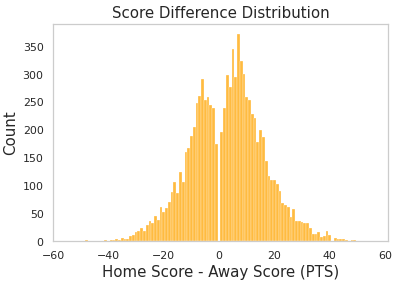

time: 1.08 s (started: 2022-08-29 22:33:22 -07:00)


In [44]:
sns.set_theme(style="whitegrid")
sns.histplot(data=pd.merge(df_game_id_folds_012345678, df_team_advanced_box_scores_away_home_team_box_scores_away_home, on='game_id', how='inner'), x='score_difference_away', color='orange', discrete=True)
plt.grid(False)
plt.title('Score Difference Distribution', loc='center', fontsize=15)
plt.xlabel('Home Score - Away Score (PTS)', fontsize=15)
plt.ylabel('Count', fontsize=15)

#save it
plt.savefig('figure_home_score_minus_away_score_distribution_color_orange.png', bbox_inches='tight', dpi=900)
sns.reset_orig()

<font size='4'> Statistical Inference Comparing Net Rating of Two NBA Teams for the 2010-11 thru 2017-18 seasons.</font>

In [45]:
df_MIA_1011 = df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'team_id'] == 1610612748) & (df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'season'] == '2010-11')]

df_BOS_1011 = df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'team_id'] == 1610612738) & (df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'season'] == '2010-11')]

#hypothesis test: Null Hypothesis H0 is the mean net rating of MIA and BOS are the same for the 2010-11 season. 
#                 Alternative Hypothesis H1 is the mean net rating of MIA and BOS are not the same for the 2010-11 season.

#check assumption of normal distribution
from scipy import stats
normal_test_pvalue_df_MIA_1011 = stats.normaltest(df_MIA_1011.loc[:, 'NET_RATING'])[1]
normal_test_pvalue_df_BOS_1011 = stats.normaltest(df_BOS_1011.loc[:, 'NET_RATING'])[1]

print("'NET_RATING' of MIA and BOS for the 2010-11 are both normal distributions with a p-value of "   + str(normal_test_pvalue_df_MIA_1011) + ' and' + str(normal_test_pvalue_df_BOS_1011) + ' from the D’Agostino and Pearson’s based normal test.')

'NET_RATING' of MIA and BOS for the 2010-11 are both normal distributions with a p-value of 0.3607785337519454 and0.9067088942152247 from the D’Agostino and Pearson’s based normal test.
time: 6.2 ms (started: 2022-08-29 22:33:23 -07:00)


In [46]:
p(df_MIA_1011)

(103, 6)


game_id     team_id TEAM_ABBREVIATION      matchup  NET_RATING   season
1     21000001  1610612748               MIA  BOS vs. MIA        -7.7  2010-11
10    21000006  1610612748               MIA  MIA vs. PHI         8.6  2010-11
48    21000025  1610612748               MIA  MIA vs. ORL        30.4  2010-11
78    21000040  1610612748               MIA  MIA vs. NJN        24.1  2010-11
98    21000050  1610612748               MIA  MIA vs. MIN        30.7  2010-11
2613  41000402  1610612748               MIA  DAL vs. MIA        -4.6  2010-11
2615  41000403  1610612748               MIA  DAL vs. MIA         2.3  2010-11
2617  41000404  1610612748               MIA  DAL vs. MIA        -4.7  2010-11
2619  41000405  1610612748               MIA  DAL vs. MIA        -8.8  2010-11
2621  41000406  1610612748               MIA  DAL vs. MIA        -9.6  2010-11

time: 5.61 ms (started: 2022-08-29 22:33:23 -07:00)


In [47]:
p(df_BOS_1011)

(91, 6)


game_id     team_id TEAM_ABBREVIATION      matchup  NET_RATING   season
0     21000001  1610612738               BOS  BOS vs. MIA         7.7  2010-11
6     21000004  1610612738               BOS  BOS vs. CLE        -8.7  2010-11
44    21000023  1610612738               BOS  BOS vs. NYK         3.0  2010-11
96    21000049  1610612738               BOS  BOS vs. DET        23.6  2010-11
112   21000058  1610612738               BOS  BOS vs. MIL         3.0  2010-11
2546  41000211  1610612738               BOS  BOS vs. MIA        -9.9  2010-11
2554  41000212  1610612738               BOS  BOS vs. MIA       -13.7  2010-11
2566  41000213  1610612738               BOS  BOS vs. MIA        19.3  2010-11
2574  41000214  1610612738               BOS  BOS vs. MIA        -9.3  2010-11
2580  41000215  1610612738               BOS  BOS vs. MIA       -11.4  2010-11

time: 5.48 ms (started: 2022-08-29 22:33:23 -07:00)


In [48]:
#give the H1, this is a two-sided t-test.
stats.ttest_ind(df_MIA_1011.loc[:, 'NET_RATING'], df_BOS_1011.loc[:, 'NET_RATING'])

Ttest_indResult(statistic=0.8634975733889899, pvalue=0.3889413438902012)

time: 2.89 ms (started: 2022-08-29 22:33:23 -07:00)


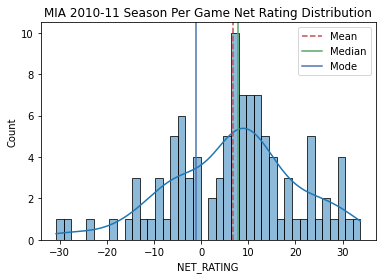

time: 137 ms (started: 2022-08-29 22:33:23 -07:00)


In [49]:
nsp.plot_histogram_with_kde_mean_median_mode(df=df_MIA_1011, title='MIA 2010-11 Season Per Game Net Rating Distribution')

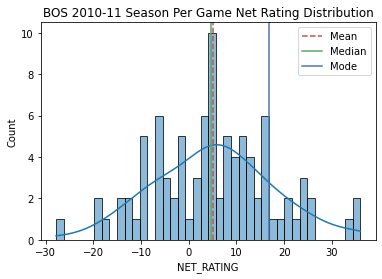

time: 128 ms (started: 2022-08-29 22:33:23 -07:00)


In [50]:
nsp.plot_histogram_with_kde_mean_median_mode(df=df_BOS_1011, title='BOS 2010-11 Season Per Game Net Rating Distribution')

<font color='blue'> The p-value appears to be large such that the alternative hypothesis, i.e. the mean net rating between the two NBA teams BOS and MIA for the 2010-11 season is statistically different, has failed to be proven.</font>




In [51]:
#hypothesis test: mean net rating between two teams, h0: means are the same. h1: means are different

time: 191 µs (started: 2022-08-29 22:33:24 -07:00)


In [52]:
team_id_list = list(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'team_id'].drop_duplicates().reset_index(drop=True))
season_list = list(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'season'].unique())
team_id_pairs_list = [(a, b) for i, a in enumerate(team_id_list) for b in team_id_list[i + 1:]]


df_season_team_id_0_team_id_1_t_statistic_p_value_NET_RATING = nsp.get_team_id_pair_t_statistic_p_value_per_season(df=df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING, column_name='NET_RATING', season_list=season_list, team_id_pairs_list=team_id_pairs_list)
p(df_season_team_id_0_team_id_1_t_statistic_p_value_NET_RATING)

(3480, 5)


season   team_id_0   team_id_1  t_statistic   p_value
0     2010-11  1610612738  1610612748    -0.863498  0.388941
1     2010-11  1610612738  1610612756     3.154208  0.001902
2     2010-11  1610612738  1610612757     2.011764  0.045762
3     2010-11  1610612738  1610612745     1.590819  0.113497
4     2010-11  1610612738  1610612747    -0.138994  0.889609
3475  2017-18  1610612744  1610612753     2.653811  0.011556
3476  2017-18  1610612744  1610612764     1.625770  0.112487
3477  2017-18  1610612746  1610612753     0.505883  0.616022
3478  2017-18  1610612746  1610612764    -0.795868  0.431474
3479  2017-18  1610612753  1610612764    -1.402585  0.169076

time: 3.53 s (started: 2022-08-29 22:33:24 -07:00)


In [53]:
nsp.get_p_value_proportion_by_alpha(df = df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING, column_name='NET_RATING', season_list=season_list, team_id_pairs_list=team_id_pairs_list, alpha=.05)

(0.510632183908046, 0.489367816091954)

time: 3.51 s (started: 2022-08-29 22:33:27 -07:00)


In [54]:
#normal test for NET_RATING
df_z_score_p_value_normal_test = pd.DataFrame({})
for team_id in team_id_list:
    df_result = pd.DataFrame([list(stats.normaltest(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'team_id'] == team_id, 'NET_RATING']))])
    df_z_score_p_value_normal_test = pd.concat([df_z_score_p_value_normal_test, df_result])
    
df_z_score_p_value_normal_test.columns = ['z_score', 'p_value']
df_z_score_p_value_normal_test = df_z_score_p_value_normal_test.reset_index(drop=True)

#covert proportion of teams with normal Net Rating and not
p_value_proporotion_greater_than_05 = sum(df_z_score_p_value_normal_test.loc[:, 'p_value'] > .05) / df_z_score_p_value_normal_test.shape[0]

p_value_proporotion_less_than_05 = sum(df_z_score_p_value_normal_test.loc[:, 'p_value'] < .05) / df_z_score_p_value_normal_test.shape[0]

print("the proportion",'\033[1m' + str(p_value_proporotion_greater_than_05) + '\033[0m' + ' of teams have a normally distributed NET_RATING.')

the proportion 0.8 of teams have a normally distributed NET_RATING.
time: 27 ms (started: 2022-08-29 22:33:31 -07:00)


In [55]:
#normal test for NET_RATING per season
df_z_score_p_value_normal_test = pd.DataFrame({})
for team_id in team_id_list:
    for season in season_list:
        df_result = pd.DataFrame([list(stats.normaltest(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[(df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'team_id'] == team_id) & (df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'season'] == season), 'NET_RATING']))])
        df_z_score_p_value_normal_test = pd.concat([df_z_score_p_value_normal_test, df_result])
        
df_z_score_p_value_normal_test.columns = ['z_score', 'p_value']
df_z_score_p_value_normal_test = df_z_score_p_value_normal_test.reset_index(drop=True)

#covert proportion of teams with normal Net Rating and not
p_value_proportion_greater_than_05 = sum(df_z_score_p_value_normal_test.loc[:, 'p_value'] > .05) / df_z_score_p_value_normal_test.shape[0]
p_value_proporotion_less_than_05 = sum(df_z_score_p_value_normal_test.loc[:, 'p_value'] < .05) / df_z_score_p_value_normal_test.shape[0]
print("the proportion",'\033[1m' + str(p_value_proportion_greater_than_05) + '\033[0m' + ' of teams have a normally distributed NET_RATING per season.')


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


the proportion 0.8541666666666666 of teams have a normally distributed NET_RATING per season.
time: 453 ms (started: 2022-08-29 22:33:31 -07:00)


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<font color='red'> used t-test where the assumption of gaussian is assumed, but this is not the case for all distributions.</font>

<font size='4'> Permutation test for NET_RATING of BOS and MIA in the 2010-11 season </font>

the proportion 0.3879 is > 0.05, therefore the NET_RATING is not statistically significant for this BOS and MIA team pair in the 2010-11 season.


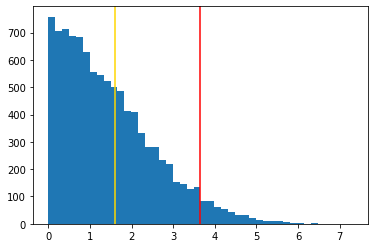

time: 4.25 s (started: 2022-08-29 22:33:31 -07:00)


In [56]:
#hypothesis test - permutation test: mean net rating between two teams, h0: mean net rating is the same. h1: mean net rating is different

#get 10,000 permutation mean differences absolute values (i.e. permutation test statistics) for the team pair in the 2010-11 season
mean_difference_abs_ndarray = np.empty(10000)

#get per game NET_RATING for first couple teams, i.e. BOS And MIA, for the 2010-11 season
df_01 = df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[((df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'team_id'] == team_id_list[0]) | (df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'team_id'] == team_id_list[1])) & (df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING.loc[:, 'season'] == season_list[0]), ['team_id', 'NET_RATING', 'season']]

for i in range(10000):
    df_01.loc[:, 'NET_RATING_Permutation'] = np.random.permutation(df_01.loc[:, 'NET_RATING'])
    
    mean_difference_abs_ndarray[i] = abs(df_01.loc[df_01.loc[:, 'team_id'] == team_id_list[0], 'NET_RATING_Permutation'].mean() - df_01.loc[df_01.loc[:, 'team_id'] == team_id_list[1], 'NET_RATING_Permutation'].mean())

#plot the 10,000 permutation mean differences for BOS and MIA in the 2010-11 season.
import numpy as np

histo = plt.hist(mean_difference_abs_ndarray, bins=44)

percentile_95 = np.percentile(mean_difference_abs_ndarray, 95)

plt.axvline(x=percentile_95, color='red')

#get observed mean difference absolute value, i.e. observed test statistic
observed_mean_difference_abs = abs(df_01.loc[df_01.team_id == team_id_list[0], 'NET_RATING'].mean() - df_01.loc[df_01.team_id == team_id_list[1], 'NET_RATING'].mean())

plt.axvline(x=observed_mean_difference_abs, color='gold')


#get p-value by number of test statistic permutations greater than observed test statistic
p_value = np.sum(mean_difference_abs_ndarray > observed_mean_difference_abs) / len(mean_difference_abs_ndarray)

print("the proportion",'\033[1m' + str(p_value) + '\033[0m' + ' is > 0.05, therefore the NET_RATING is not statistically significant for this BOS and MIA team pair in the 2010-11 season.')

plt.show()

In [57]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = 'df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000.csv.gz', parse_dates=False)

if df_readback.empty == False:
    df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000 = df_readback
else:
    df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000 = nsp.get_permutation_test_p_value(df=df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING, season_list = season_list, column_name='NET_RATING', number_permutations=10000, team_id_pairs_list=team_id_pairs_list)

    #save it
    df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000 = save_and_return_data_frame(df=df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000, filename='df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000.csv.gz', index=False, parse_dates=False)

p_value_proportion_greater_than_05 = sum(df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000.loc[:, 'NET_RATING_p_value'] > .05) / df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000.shape[0]

p_value_proportion_less_than_05 = sum(df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000.loc[:, 'NET_RATING_p_value'] <= .05) / df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000.shape[0]

print("A majority, i.e. " + '\033[1m' + str(p_value_proportion_less_than_05) + '\033[0m' + ", of team matchup's are statistically different by NET_RATING")

    
p(df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000)

This file already exists
A majority, i.e. 0.5100574712643678, of team matchup's are statistically different by NET_RATING
(3480, 4)


season   team_id_0   team_id_1  NET_RATING_p_value
0     2010-11  1610612738  1610612748              0.3803
1     2010-11  1610612738  1610612756              0.0018
2     2010-11  1610612738  1610612757              0.0482
3     2010-11  1610612738  1610612745              0.1171
4     2010-11  1610612738  1610612747              0.8875
3475  2017-18  1610612744  1610612753              0.0113
3476  2017-18  1610612744  1610612764              0.1143
3477  2017-18  1610612746  1610612753              0.6210
3478  2017-18  1610612746  1610612764              0.4305
3479  2017-18  1610612753  1610612764              0.1739

time: 9.77 ms (started: 2022-08-29 22:33:35 -07:00)


<font size="4">Get Team Player Advanced Box Score Stat Lost Contribution Sum, Mean, and Max from Player Advanced Box Scores [[4]](#[4]), player injury report [[5]](#[5]), and player inactive list [[7]](#[7]) for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [58]:
df_readback = \
nsp.return_processed_data_file_if_it_exists(filename = '50team_advanced_box_score_stat_lost_contribution_sum_mean_max_2010_11_2017_18.csv.gz',
                                            parse_dates=['game_date'])

if df_readback.empty == False:
    df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max = df_readback
else:
    df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max = \
    nsp.get_and_clean_team_advanced_box_score_stat_lost_contribution_sum_mean_max(df_player_advanced_box_scores_2009_10_2017_18,
                                                                                  df_player_injury_report,
                                                                                  df_player_inactives_2010_11_2017_18,
                                                                                  df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18)

    df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max = \
    save_and_return_data_frame(df=df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max, 
                               filename='50team_advanced_box_score_stat_lost_contribution_sum_mean_max_2010_11_2017_18.csv.gz',
                               index=False,
                               parse_dates=['game_date'])

p(df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max)

This file already exists
(20532, 74)


game_id  game_date           team     team_id   season  lc_sum_MIN  \
0      21000001 2010-10-26        Celtics  1610612738  2010-11   51.924227   
1      21000001 2010-10-26           Heat  1610612748  2010-11  110.238328   
2      21000002 2010-10-26  Trail Blazers  1610612757  2010-11   50.458291   
3      21000002 2010-10-26           Suns  1610612756  2010-11    7.336111   
4      21000003 2010-10-26         Lakers  1610612747  2010-11   45.471555   
20527  41700402 2018-06-03       Warriors  1610612744  2017-18    0.000000   
20528  41700403 2018-06-06      Cavaliers  1610612739  2017-18   52.338461   
20529  41700403 2018-06-06       Warriors  1610612744  2017-18   13.272000   
20530  41700404 2018-06-08      Cavaliers  1610612739  2017-18   21.729167   
20531  41700404 2018-06-08       Warriors  1610612744  2017-18    0.000000   

       lc_sum_E_OFF_RATING  lc_sum_OFF_RATING  lc_sum_E_DEF_RATING  \
0               211.872235         213.259085           201.560675   
1               507.593932         506.705203           529.659259   
2               316.665128         317.949634           318.083077   
3                94.955556          93.225926           101.974074   
4               311.425148         307.926411           302.871703   
20527             0.000000           0.000000             0.000000   
20528           400.631457         380.411271           426.728326   
20529           114.489333         114.173333           104.185333   
20530           102.010000         102.107000           107.554000   
20531             0.000000           0.000000             0.000000   

       lc_sum_DEF_RATING  lc_sum_E_NET_RATING  lc_sum_NET_RATING  \
0             204.284577            10.321001           8.965179   
1             529.555276           -22.053076         -22.846304   
2             310.663040            -1.416447           7.270403   
3              98.822222            -7.024074          -5.598148   
4             300.404159             8.554744           7.529242   
20527           0.000000             0.000000           0.000000   
20528         421.938512           -26.111453         -41.525423   
20529         105.069333            10.306667           9.105333   
20530         108.108000            -5.541000          -6.003000   
20531           0.000000             0.000000           0.000000   

       lc_sum_AST_PCT  lc_sum_AST_TOV  lc_sum_AST_RATIO  lc_sum_OREB_PCT  \
0            0.271101        1.990024         34.827346         0.106651   
1            0.600020        4.750808         79.579039         0.228306   
2            0.328857        0.781418         32.385897         0.282006   
3            0.088778        0.203704          9.392593         0.035574   
4            0.347421        1.383516         46.364610         0.141115   
20527        0.000000        0.000000          0.000000         0.000000   
20528        0.522395        2.162777         62.147909         0.135526   
20529        0.126733        0.542133         18.852000         0.092147   
20530        0.173480        1.180900         13.809000         0.026670   
20531        0.000000        0.000000          0.000000         0.000000   

       lc_sum_DREB_PCT  lc_sum_REB_PCT  lc_sum_TM_TOV_PCT  lc_sum_EFG_PCT  \
0             0.289929        0.204024          31.643285        0.998045   
1             0.699159        0.459315          69.738878        2.298579   
2             0.520890        0.405909          52.022308        1.391468   
3             0.118204        0.084574          10.553704        0.256611   
4             0.346645        0.245898          25.639408        1.219038   
20527         0.000000        0.000000           0.000000        0.000000   
20528         0.476935        0.345398          33.347526        1.738520   
20529         0.215120        0.160600          17.722667        0.527107   
20530         0.082420        0.053930           9.991000        0.456100   
20531         0.000000

time: 353 ms (started: 2022-08-29 22:33:35 -07:00)


In [59]:
df_readback = \
nsp.return_processed_data_file_if_it_exists(
    filename = '57team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_2010_11_2017_18.csv.gz',
    parse_dates=['game_date'])

if df_readback.empty == False:
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff = df_readback
else:
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff = \
    nsp.get_operator_window_max_5_12_999_difference_of_team_player_advanced_box_score_lost_contribution_sum_mean_max(
        df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max,
        df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b,
        operator_name='mean')


    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff = \
    save_and_return_data_frame(df=df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff, 
                               filename='57team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_2010_11_2017_18.csv.gz',
                               index=False,
                               parse_dates=['game_date'])

p(df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff)

This file already exists
(10266, 215)


game_id   team_id_a     team_a  game_date      matchup   season  \
0      21000001  1610612738    Celtics 2010-10-26  BOS vs. MIA  2010-11   
1      21000002  1610612756       Suns 2010-10-26  PHX vs. POR  2010-11   
2      21000003  1610612745    Rockets 2010-10-26  HOU vs. LAL  2010-11   
3      21000004  1610612738    Celtics 2010-10-27  BOS vs. CLE  2010-11   
4      21000005  1610612765    Pistons 2010-10-27  DET vs. NJN  2010-11   
10261  41700317  1610612744   Warriors 2018-05-28  GSW vs. HOU  2017-18   
10262  41700401  1610612739  Cavaliers 2018-05-31  CLE vs. GSW  2017-18   
10263  41700402  1610612739  Cavaliers 2018-06-03  CLE vs. GSW  2017-18   
10264  41700403  1610612739  Cavaliers 2018-06-06  CLE vs. GSW  2017-18   
10265  41700404  1610612739  Cavaliers 2018-06-08  CLE vs. GSW  2017-18   

        team_id_b         team_b  lc_sum_MIN_season_cma5_diff  \
0      1610612748           Heat                     0.000000   
1      1610612757  Trail Blazers                     0.000000   
2      1610612747         Lakers                     0.000000   
3      1610612739      Cavaliers                    51.924227   
4      1610612751           Nets                     0.000000   
10261  1610612745        Rockets                   -31.999206   
10262  1610612744       Warriors                     6.805813   
10263  1610612744       Warriors                     1.735660   
10264  1610612744       Warriors                     5.855421   
10265  1610612744       Warriors                    19.367256   

       lc_sum_E_OFF_RATING_season_cma5_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3                                211.872235   
4                                  0.000000   
10261                           -153.530749   
10262                            -24.997946   
10263                            -48.039405   
10264                             -3.774961   
10265                            115.147011   

       lc_sum_OFF_RATING_season_cma5_diff  \
0                                0.000000   
1                                0.000000   
2                                0.000000   
3                              213.259085   
4                                0.000000   
10261                         -146.182173   
10262                          -30.014940   
10263                          -52.935122   
10264                           -7.085470   
10265                          106.586569   

       lc_sum_E_DEF_RATING_season_cma5_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3                                201.560675   
4                                  0.000000   
10261                           -134.628644   
10262                            -11.760503   
10263                            -34.320275   
10264                              5.002585   
10265                            134.663516   

       lc_sum_DEF_RATING_season_cma5_diff  \
0                                0.000000   
1                                0.000000   
2                                0.000000   
3                              204.284577   
4                                0.000000   
10261                         -130.924314   
10262                          -13.674456   
10263                          -36.081744   
10264                            3.267599   
10265                          131.270396   

       lc_sum_E_NET_RATING_season_cma5_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3                                 10.321001   
4                                  0.000000   
10261                            -18.884348   
10262                            -13.249553   
10263                            -13.730435   
10264          

time: 630 ms (started: 2022-08-29 22:33:36 -07:00)


In [60]:
df_readback = \
nsp.return_processed_data_file_if_it_exists(
    filename = '57team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff_2010_11_2017_18.csv.gz',
    parse_dates=['game_date'])

if df_readback.empty == False:
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff = df_readback
else:
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff = \
    nsp.get_operator_window_max_5_12_999_difference_of_team_player_advanced_box_score_lost_contribution_sum_mean_max(
        df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max,
        df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b,
        operator_name='max')

    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff = \
    save_and_return_data_frame(df=df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff, 
                               filename='57team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff_2010_11_2017_18.csv.gz',
                               index=False,
                               parse_dates=['game_date'])

p(df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff)

This file already exists
(10266, 215)


game_id   team_id_a     team_a  game_date      matchup   season  \
0      21000001  1610612738    Celtics 2010-10-26  BOS vs. MIA  2010-11   
1      21000002  1610612756       Suns 2010-10-26  PHX vs. POR  2010-11   
2      21000003  1610612745    Rockets 2010-10-26  HOU vs. LAL  2010-11   
3      21000004  1610612738    Celtics 2010-10-27  BOS vs. CLE  2010-11   
4      21000005  1610612765    Pistons 2010-10-27  DET vs. NJN  2010-11   
10261  41700317  1610612744   Warriors 2018-05-28  GSW vs. HOU  2017-18   
10262  41700401  1610612739  Cavaliers 2018-05-31  CLE vs. GSW  2017-18   
10263  41700402  1610612739  Cavaliers 2018-06-03  CLE vs. GSW  2017-18   
10264  41700403  1610612739  Cavaliers 2018-06-06  CLE vs. GSW  2017-18   
10265  41700404  1610612739  Cavaliers 2018-06-08  CLE vs. GSW  2017-18   

        team_id_b         team_b  lc_sum_MIN_season_cmax5_diff  \
0      1610612748           Heat                      0.000000   
1      1610612757  Trail Blazers                      0.000000   
2      1610612747         Lakers                      0.000000   
3      1610612739      Cavaliers                     51.924227   
4      1610612751           Nets                      0.000000   
10261  1610612745        Rockets                    -31.948673   
10262  1610612744       Warriors                      3.418379   
10263  1610612744       Warriors                      3.418379   
10264  1610612744       Warriors                     34.609230   
10265  1610612744       Warriors                     34.609230   

       lc_sum_E_OFF_RATING_season_cmax5_diff  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                                 211.872235   
4                                   0.000000   
10261                            -109.151965   
10262                               7.705905   
10263                               7.705905   
10264                             205.081810   
10265                             205.081810   

       lc_sum_OFF_RATING_season_cmax5_diff  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                               213.259085   
4                                 0.000000   
10261                           -98.979454   
10262                             5.185950   
10263                             5.185950   
10264                           196.562420   
10265                           196.562420   

       lc_sum_E_DEF_RATING_season_cmax5_diff  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                                 201.560675   
4                                   0.000000   
10261                             -94.402230   
10262                              24.920546   
10263                              24.920546   
10264                             227.046413   
10265                             236.078935   

       lc_sum_DEF_RATING_season_cmax5_diff  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                               204.284577   
4                                 0.000000   
10261                           -89.183634   
10262                            19.562965   
10263                            19.562965   
10264                           223.937602   
10265                           227.284815   

       lc_sum_E_NET_RATING_season_cmax5_diff  \
0                                   0.000000   
1                                   0.000000   
2                                   0.000000   
3                                  10.321001   
4                                   0.000000   
10261                             -22.616881   
10262                             -10.678596   

time: 586 ms (started: 2022-08-29 22:33:36 -07:00)


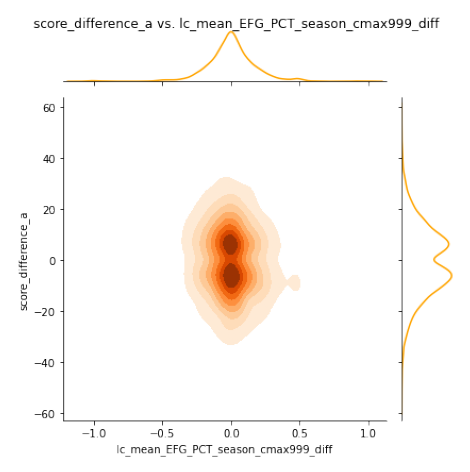

time: 89.7 ms (started: 2022-08-29 22:33:37 -07:00)


In [61]:
nsp.plot_kde(column_name_x='lc_mean_EFG_PCT_season_cmax999_diff', column_name_y='score_difference_a', df_game_id_column_y=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'], df_game_id_folds_012345678=df_game_id_folds_012345678, df_game_id_column_x=df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff)

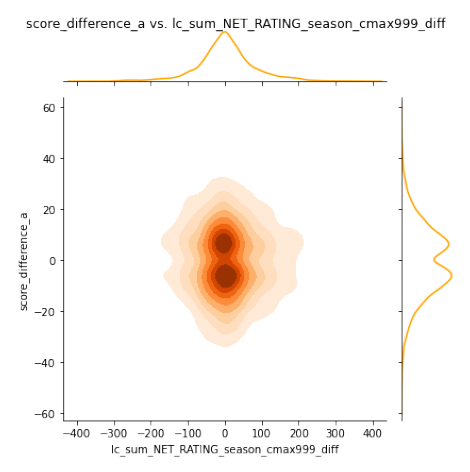

time: 66.2 ms (started: 2022-08-29 22:33:37 -07:00)


In [62]:
nsp.plot_kde(column_name_x='lc_sum_NET_RATING_season_cmax999_diff', column_name_y='score_difference_a', df_game_id_column_y=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'], df_game_id_folds_012345678=df_game_id_folds_012345678, df_game_id_column_x=df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff)

In [63]:
del df_forward_filled_player_advanced_box_scores_zero_minutes_player_injury_report_player_inactives_lost_contribution_sum_mean_max

time: 334 µs (started: 2022-08-29 22:33:37 -07:00)


In [64]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_22', '_23', '_24', '_26', '_27', '_28', '_29', '_30', '_31', '_33', '_34', '_35', '_36', '_39', '_40', '_41', '_42', '_43', '_46', '_47', '_52', '_57', '_58', '_59', '_6', '_60', '_8', '__', '___', 'df_01', 'df_BOS_1011', 'df_MIA_1011', 'df_city_proper_metropolitan_area_gdp', 'df_game_id_game_date', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP', 'df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING', 'df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18', 'df_player_advanced_box_scores', 'df_player_advanced_box_scores_2009_10_2017_18', 'df_player_inactives', 'df_player_inactives_2009_10_2017_18', 'df_player_inactives_2010_11_2017_18', 'df_player_injury_report', 'df_readback', 'df_result', 'df_season_first_game_date_last_game_date', 'df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000', 'df_seas

In [65]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '58team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff_2010_11_2017_18.csv.gz', parse_dates=['game_date'])

if df_readback.empty == False:
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff = df_readback
else:
    #combine lost contribution data frames
    column_name_list_merge_on = [column for column in df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff if column in df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff]
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff = pd.merge(df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff, df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cmax5_12_999_diff, on=column_name_list_merge_on, how='inner')
    
    #save it
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff = save_and_return_data_frame(df=df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff, filename='58team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff_2010_11_2017_18.csv.gz', index=False, parse_dates=['game_date'])
p(df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff)

This file already exists
(10266, 422)


game_id   team_id_a     team_a  game_date      matchup   season  \
0      21000001  1610612738    Celtics 2010-10-26  BOS vs. MIA  2010-11   
1      21000002  1610612756       Suns 2010-10-26  PHX vs. POR  2010-11   
2      21000003  1610612745    Rockets 2010-10-26  HOU vs. LAL  2010-11   
3      21000004  1610612738    Celtics 2010-10-27  BOS vs. CLE  2010-11   
4      21000005  1610612765    Pistons 2010-10-27  DET vs. NJN  2010-11   
10261  41700317  1610612744   Warriors 2018-05-28  GSW vs. HOU  2017-18   
10262  41700401  1610612739  Cavaliers 2018-05-31  CLE vs. GSW  2017-18   
10263  41700402  1610612739  Cavaliers 2018-06-03  CLE vs. GSW  2017-18   
10264  41700403  1610612739  Cavaliers 2018-06-06  CLE vs. GSW  2017-18   
10265  41700404  1610612739  Cavaliers 2018-06-08  CLE vs. GSW  2017-18   

        team_id_b         team_b  lc_sum_MIN_season_cma5_diff  \
0      1610612748           Heat                     0.000000   
1      1610612757  Trail Blazers                     0.000000   
2      1610612747         Lakers                     0.000000   
3      1610612739      Cavaliers                    51.924227   
4      1610612751           Nets                     0.000000   
10261  1610612745        Rockets                   -31.999206   
10262  1610612744       Warriors                     6.805813   
10263  1610612744       Warriors                     1.735660   
10264  1610612744       Warriors                     5.855421   
10265  1610612744       Warriors                    19.367256   

       lc_sum_E_OFF_RATING_season_cma5_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3                                211.872235   
4                                  0.000000   
10261                           -153.530749   
10262                            -24.997946   
10263                            -48.039405   
10264                             -3.774961   
10265                            115.147011   

       lc_sum_OFF_RATING_season_cma5_diff  \
0                                0.000000   
1                                0.000000   
2                                0.000000   
3                              213.259085   
4                                0.000000   
10261                         -146.182173   
10262                          -30.014940   
10263                          -52.935122   
10264                           -7.085470   
10265                          106.586569   

       lc_sum_E_DEF_RATING_season_cma5_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3                                201.560675   
4                                  0.000000   
10261                           -134.628644   
10262                            -11.760503   
10263                            -34.320275   
10264                              5.002585   
10265                            134.663516   

       lc_sum_DEF_RATING_season_cma5_diff  \
0                                0.000000   
1                                0.000000   
2                                0.000000   
3                              204.284577   
4                                0.000000   
10261                         -130.924314   
10262                          -13.674456   
10263                          -36.081744   
10264                            3.267599   
10265                          131.270396   

       lc_sum_E_NET_RATING_season_cma5_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3                                 10.321001   
4                                  0.000000   
10261                            -18.884348   
10262                            -13.249553   
10263                            -13.730435   
10264          

time: 1.17 s (started: 2022-08-29 22:33:37 -07:00)


<font size="4">Get Team Advanced Box Score [[4]](#[4]) Season Matchup 12 Game Moving Average Difference and Team Box Scores [[2]](#[2]) Season Matchup 12 Game Moving Average Difference from Team A and Team B format of Team Advanced Box Scores [[4]](#[4]) and Team Box Scores [[2]](#[2]) for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [67]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '53team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b_2010_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b = df_readback
else:
    #calculate Team Advanced Box Score and Team Box Score Season Matchup 12 Game Moving Average Difference
    df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b = nsp.from_team_a_team_b_or_stacked_format_of_team_advanced_box_scores_and_team_box_scores_get_operator_window_max_difference(df=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'], column_name_list_groupby=['season', 'matchup', 'team_id'], column_name_list_not_difference=['game_id', 'game_date', 'season', 'season_type', 'season_year', 'a', 'b', 'matchup'], column_name_suffix_list=['_a', '_b'], window_size_list_max_min=[12,1], operator_group_name='season_matchup', operator_name='mean', data_frame_start_format='a_b')

    #save it
    df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b = save_and_return_data_frame(df=df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b, filename='53team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b_2010_2018.csv.gz', index=False, parse_dates=['game_date'])
p(df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b)

This file already exists
(10266, 68)


game_id   team_id_a TEAM_NAME_a TEAM_ABBREVIATION_a   TEAM_CITY_a  \
0      21000001  1610612738     Celtics                 BOS        Boston   
1      21000002  1610612756        Suns                 PHX       Phoenix   
2      21000003  1610612745     Rockets                 HOU       Houston   
3      21000004  1610612738     Celtics                 BOS        Boston   
4      21000005  1610612765     Pistons                 DET       Detroit   
10261  41700317  1610612744    Warriors                 GSW  Golden State   
10262  41700401  1610612739   Cavaliers                 CLE     Cleveland   
10263  41700402  1610612739   Cavaliers                 CLE     Cleveland   
10264  41700403  1610612739   Cavaliers                 CLE     Cleveland   
10265  41700404  1610612739   Cavaliers                 CLE     Cleveland   

        MIN_a       duration_a wl_a  game_date      matchup  season_year  \
0      240:00  0 days 04:00:00    W 2010-10-26  BOS vs. MIA         2010   
1      240:00  0 days 04:00:00    L 2010-10-26  PHX vs. POR         2010   
2      240:00  0 days 04:00:00    L 2010-10-26  HOU vs. LAL         2010   
3      240:00  0 days 04:00:00    L 2010-10-27  BOS vs. CLE         2010   
4      240:00  0 days 04:00:00    L 2010-10-27  DET vs. NJN         2010   
10261  240:00  0 days 04:00:00    W 2018-05-28  GSW vs. HOU         2017   
10262  265:00  0 days 04:25:00    L 2018-05-31  CLE vs. GSW         2017   
10263  240:00  0 days 04:00:00    L 2018-06-03  CLE vs. GSW         2017   
10264  240:00  0 days 04:00:00    L 2018-06-06  CLE vs. GSW         2017   
10265  240:00  0 days 04:00:00    L 2018-06-08  CLE vs. GSW         2017   

          season_type   season    a    b   team_id_b    TEAM_NAME_b  \
0      Regular Season  2010-11  BOS  MIA  1610612748           Heat   
1      Regular Season  2010-11  PHX  POR  1610612757  Trail Blazers   
2      Regular Season  2010-11  HOU  LAL  1610612747         Lakers   
3      Regular Season  2010-11  BOS  CLE  1610612739      Cavaliers   
4      Regular Season  2010-11  DET  NJN  1610612751           Nets   
10261        Playoffs  2017-18  GSW  HOU  1610612745        Rockets   
10262        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10263        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10264        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10265        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   

      TEAM_ABBREVIATION_b   TEAM_CITY_b   MIN_b       duration_b wl_b  \
0                     MIA         Miami  240:00  0 days 04:00:00    L   
1                     POR      Portland  240:00  0 days 04:00:00    W   
2                     LAL   Los Angeles  240:00  0 days 04:00:00    W   
3                     CLE     Cleveland  240:00  0 days 04:00:00    W   
4                     NJN    New Jersey  240:00  0 days 04:00:00    W   
10261                 HOU       Houston  240:00  0 days 04:00:00    L   
10262                 GSW  Golden State  265:00  0 days 04:25:00    W   
10263                 GSW  Golden State  240:00  0 days 04:00:00    W   
10264                 GSW  Golden State  240:00  0 days 04:00:00    W   
10265                 GSW  Golden State  240:00  0 days 04:00:00    W   

       E_OFF_RATING_season_matchup_cma12_diff  \
0                                       0.000   
1                                       0.000   
2                                       0.000   
3                                       0.000   
4                                       0.000   
10261                                   8.900   
10262                                 -10.600   
10263                                  -9.900   
10264                                 -12.425   
10265                                 -12.540   

       OFF_RATING_season_matchup_cma12_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3        

time: 130 ms (started: 2022-08-29 22:33:38 -07:00)


<font size="4">Get Season Matchup 12 Game Cumulative Max Difference of Team Advanced Box Scores [[4]](#[4]), Team Box Scores [[2]](#[2]), Team Advanced Box Score [[4]](#[4]) Season 12 Game Moving Average, and Team Box Score  [[2]](#[2]) 12 Game Moving Average from Team A and Team B format of Team Advanced Box Scores [[4]](#[4]) and Team Box Scores [[2]](#[2]) for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [68]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '53team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b_2010_2018.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b = df_readback
else:
    #get Team Advanced Box Score Stat and Stat cma12 and Team Box Score Stat and Stat cma12 for Team A and Team B
    df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b = \
    nsp.get_team_advanced_box_score_team_box_score_season_matchup_cmax12_difference_season_cma12_season_matchup_cmax12_difference_for_team_a_and_team_b(
        df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b)
    
    df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b = \
    save_and_return_data_frame(
        df=df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b, 
        filename='53team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b_2010_2018.csv.gz',
        index=False,
        parse_dates=['game_date'])

p(df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b)

This file already exists
(10266, 114)


game_id   team_id_a TEAM_NAME_a TEAM_ABBREVIATION_a   TEAM_CITY_a  \
0      21000001  1610612738     Celtics                 BOS        Boston   
1      21000002  1610612756        Suns                 PHX       Phoenix   
2      21000003  1610612745     Rockets                 HOU       Houston   
3      21000004  1610612738     Celtics                 BOS        Boston   
4      21000005  1610612765     Pistons                 DET       Detroit   
10261  41700317  1610612744    Warriors                 GSW  Golden State   
10262  41700401  1610612739   Cavaliers                 CLE     Cleveland   
10263  41700402  1610612739   Cavaliers                 CLE     Cleveland   
10264  41700403  1610612739   Cavaliers                 CLE     Cleveland   
10265  41700404  1610612739   Cavaliers                 CLE     Cleveland   

        MIN_a       duration_a wl_a  game_date      matchup  season_year  \
0      240:00  0 days 04:00:00    W 2010-10-26  BOS vs. MIA         2010   
1      240:00  0 days 04:00:00    L 2010-10-26  PHX vs. POR         2010   
2      240:00  0 days 04:00:00    L 2010-10-26  HOU vs. LAL         2010   
3      240:00  0 days 04:00:00    L 2010-10-27  BOS vs. CLE         2010   
4      240:00  0 days 04:00:00    L 2010-10-27  DET vs. NJN         2010   
10261  240:00  0 days 04:00:00    W 2018-05-28  GSW vs. HOU         2017   
10262  265:00  0 days 04:25:00    L 2018-05-31  CLE vs. GSW         2017   
10263  240:00  0 days 04:00:00    L 2018-06-03  CLE vs. GSW         2017   
10264  240:00  0 days 04:00:00    L 2018-06-06  CLE vs. GSW         2017   
10265  240:00  0 days 04:00:00    L 2018-06-08  CLE vs. GSW         2017   

          season_type   season    a    b   team_id_b    TEAM_NAME_b  \
0      Regular Season  2010-11  BOS  MIA  1610612748           Heat   
1      Regular Season  2010-11  PHX  POR  1610612757  Trail Blazers   
2      Regular Season  2010-11  HOU  LAL  1610612747         Lakers   
3      Regular Season  2010-11  BOS  CLE  1610612739      Cavaliers   
4      Regular Season  2010-11  DET  NJN  1610612751           Nets   
10261        Playoffs  2017-18  GSW  HOU  1610612745        Rockets   
10262        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10263        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10264        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10265        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   

      TEAM_ABBREVIATION_b   TEAM_CITY_b   MIN_b       duration_b wl_b  \
0                     MIA         Miami  240:00  0 days 04:00:00    L   
1                     POR      Portland  240:00  0 days 04:00:00    W   
2                     LAL   Los Angeles  240:00  0 days 04:00:00    W   
3                     CLE     Cleveland  240:00  0 days 04:00:00    W   
4                     NJN    New Jersey  240:00  0 days 04:00:00    W   
10261                 HOU       Houston  240:00  0 days 04:00:00    L   
10262                 GSW  Golden State  265:00  0 days 04:25:00    W   
10263                 GSW  Golden State  240:00  0 days 04:00:00    W   
10264                 GSW  Golden State  240:00  0 days 04:00:00    W   
10265                 GSW  Golden State  240:00  0 days 04:00:00    W   

       E_OFF_RATING_season_matchup_cmax12_diff  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
10261                                      7.7   
10262                                    -14.3   
10263                                     -8.5   
10264                                    -14.7   
10265                                    -14.7   

       OFF_RATING_season_matchup_cmax12_diff  \
0                                        0.0   
1                                        0.0   
2                                        0

time: 235 ms (started: 2022-08-29 22:33:38 -07:00)


In [69]:
df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10266 entries, 0 to 10265
Data columns (total 114 columns):
 #    Column                                                    Non-Null Count  Dtype         
---   ------                                                    --------------  -----         
 0    game_id                                                   10266 non-null  int64         
 1    team_id_a                                                 10266 non-null  int64         
 2    TEAM_NAME_a                                               10266 non-null  object        
 3    TEAM_ABBREVIATION_a                                       10266 non-null  object        
 4    TEAM_CITY_a                                               10266 non-null  object        
 5    MIN_a                                                     10266 non-null  object        
 6    duration_a                                                10266 non-null  object        
 7    wl_a                         

In [70]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_22', '_23', '_24', '_26', '_27', '_28', '_29', '_30', '_31', '_33', '_34', '_35', '_36', '_39', '_40', '_41', '_42', '_43', '_46', '_47', '_52', '_57', '_58', '_59', '_6', '_60', '_65', '_67', '_68', '_8', '__', '___', 'df_01', 'df_BOS_1011', 'df_MIA_1011', 'df_city_proper_metropolitan_area_gdp', 'df_game_id_game_date', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP', 'df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING', 'df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18', 'df_player_advanced_box_scores', 'df_player_advanced_box_scores_2009_10_2017_18', 'df_player_inactives', 'df_player_inactives_2009_10_2017_18', 'df_player_inactives_2010_11_2017_18', 'df_player_injury_report', 'df_readback', 'df_result', 'df_season_first_game_date_last_game_date', 'df_season_team_id_0_team_id_1_NET_RATING_p_value_permuta

<font size="4">Combine Season Matchup 12 Game Cumulative Max Difference of Team Advanced Box Scores [[4]](#[4]), Team Box Scores [[2]](#[2]), Team Advanced Box Score [[4]](#[4]) Season 12 Game Moving Average, and Team Box Score  [[2]](#[2]) 12 Game Moving Average AND 12 Game Moving Average of Team Advanced Box Scores and Team Box Scores for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [71]:
#merge Team Advanced Box Score and Team Box Score Season Matchup 12 Game Moving Average AND
#      Team Advanced Box Score and Team Box Score Season Matchup 12 Game Max and Season 12 Game Moving Average Season Matchup 12 Game Max
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '58team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b = df_readback
else:
    column_name_list_merge_on = [k for k in df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b.columns if k in df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b.columns]
    df_team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b = pd.merge(df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b, 
                                                                                                                                                              df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b, 
                                                                                                                                                              on=column_name_list_merge_on, 
                                                                                                                                                              how='inner')
    
    #save it
    df_team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b = save_and_return_data_frame(df=df_team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b, filename='58team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b.csv.gz', index=False, parse_dates=['game_date'])
p(df_team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b)

This file already exists
(10266, 160)


game_id   team_id_a TEAM_NAME_a TEAM_ABBREVIATION_a   TEAM_CITY_a  \
0      21000001  1610612738     Celtics                 BOS        Boston   
1      21000002  1610612756        Suns                 PHX       Phoenix   
2      21000003  1610612745     Rockets                 HOU       Houston   
3      21000004  1610612738     Celtics                 BOS        Boston   
4      21000005  1610612765     Pistons                 DET       Detroit   
10261  41700317  1610612744    Warriors                 GSW  Golden State   
10262  41700401  1610612739   Cavaliers                 CLE     Cleveland   
10263  41700402  1610612739   Cavaliers                 CLE     Cleveland   
10264  41700403  1610612739   Cavaliers                 CLE     Cleveland   
10265  41700404  1610612739   Cavaliers                 CLE     Cleveland   

        MIN_a       duration_a wl_a  game_date      matchup  season_year  \
0      240:00  0 days 04:00:00    W 2010-10-26  BOS vs. MIA         2010   
1      240:00  0 days 04:00:00    L 2010-10-26  PHX vs. POR         2010   
2      240:00  0 days 04:00:00    L 2010-10-26  HOU vs. LAL         2010   
3      240:00  0 days 04:00:00    L 2010-10-27  BOS vs. CLE         2010   
4      240:00  0 days 04:00:00    L 2010-10-27  DET vs. NJN         2010   
10261  240:00  0 days 04:00:00    W 2018-05-28  GSW vs. HOU         2017   
10262  265:00  0 days 04:25:00    L 2018-05-31  CLE vs. GSW         2017   
10263  240:00  0 days 04:00:00    L 2018-06-03  CLE vs. GSW         2017   
10264  240:00  0 days 04:00:00    L 2018-06-06  CLE vs. GSW         2017   
10265  240:00  0 days 04:00:00    L 2018-06-08  CLE vs. GSW         2017   

          season_type   season    a    b   team_id_b    TEAM_NAME_b  \
0      Regular Season  2010-11  BOS  MIA  1610612748           Heat   
1      Regular Season  2010-11  PHX  POR  1610612757  Trail Blazers   
2      Regular Season  2010-11  HOU  LAL  1610612747         Lakers   
3      Regular Season  2010-11  BOS  CLE  1610612739      Cavaliers   
4      Regular Season  2010-11  DET  NJN  1610612751           Nets   
10261        Playoffs  2017-18  GSW  HOU  1610612745        Rockets   
10262        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10263        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10264        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10265        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   

      TEAM_ABBREVIATION_b   TEAM_CITY_b   MIN_b       duration_b wl_b  \
0                     MIA         Miami  240:00  0 days 04:00:00    L   
1                     POR      Portland  240:00  0 days 04:00:00    W   
2                     LAL   Los Angeles  240:00  0 days 04:00:00    W   
3                     CLE     Cleveland  240:00  0 days 04:00:00    W   
4                     NJN    New Jersey  240:00  0 days 04:00:00    W   
10261                 HOU       Houston  240:00  0 days 04:00:00    L   
10262                 GSW  Golden State  265:00  0 days 04:25:00    W   
10263                 GSW  Golden State  240:00  0 days 04:00:00    W   
10264                 GSW  Golden State  240:00  0 days 04:00:00    W   
10265                 GSW  Golden State  240:00  0 days 04:00:00    W   

       E_OFF_RATING_season_matchup_cma12_diff  \
0                                       0.000   
1                                       0.000   
2                                       0.000   
3                                       0.000   
4                                       0.000   
10261                                   8.900   
10262                                 -10.600   
10263                                  -9.900   
10264                                 -12.425   
10265                                 -12.540   

       OFF_RATING_season_matchup_cma12_diff  \
0                                  0.000000   
1                                  0.000000   
2                                  0.000000   
3        

time: 274 ms (started: 2022-08-29 22:33:39 -07:00)


<font size="4">Get Team Advanced Box Score [[4]](#[4]) and Team Box Score [[2]](#[2]) Season 5, 12, and 999 Game Moving Average Differences from Team A and Team B format of Team Advanced Box Scores [[4]](#[4]) and Team Box Scores [[2]](#[2]) for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [72]:
df_readback = nsp.return_processed_collection_if_it_exists(filename='55team_advanced_box_score_season_cma5_12_999_diff_team_box_score_season_cma5_12_999_diff_a_b_2010_2018.pkl', parse_dates=False)
if df_readback != None:
    df_team_advanced_box_score_season_cma_window_max_diff_team_box_score_season_cma_window_max_diff_collection_5_12_999 = df_readback
else:
    df_team_advanced_box_score_season_cma_window_max_diff_team_box_score_season_cma_window_max_diff_collection_5_12_999 = {}
    for window_max in [5, 12, 999]:
        df_team_advanced_box_score_season_cma_window_max_diff_team_box_score_season_cma_window_max_diff_collection_5_12_999[str(window_max)] = nsp.from_team_a_team_b_or_stacked_format_of_team_advanced_box_scores_and_team_box_scores_get_operator_window_max_difference(df=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'], column_name_list_groupby=['season', 'team_id'], column_name_list_not_difference=['game_id', 'game_date', 'season', 'season_type', 'season_year', 'a', 'b', 'matchup'], column_name_suffix_list=['_a', '_b'], window_size_list_max_min=[window_max,1], operator_group_name='season', operator_name='mean', data_frame_start_format='a_b')
        
    #save it
    df_team_advanced_box_score_season_cma_window_max_diff_team_box_score_season_cma_window_max_diff_collection_5_12_999 = nsp.save_and_return_collection(data_frame_collection=df_team_advanced_box_score_season_cma_window_max_diff_team_box_score_season_cma_window_max_diff_collection_5_12_999, filename='55team_advanced_box_score_season_cma5_12_999_diff_team_box_score_season_cma5_12_999_diff_a_b_2010_2018.pkl', index=False, parse_dates=False)
p(df_team_advanced_box_score_season_cma_window_max_diff_team_box_score_season_cma_window_max_diff_collection_5_12_999['5'])

This file already exists
(10266, 68)


game_id   team_id_a TEAM_NAME_a TEAM_ABBREVIATION_a   TEAM_CITY_a  \
0      21000001  1610612738     Celtics                 BOS        Boston   
1      21000002  1610612756        Suns                 PHX       Phoenix   
2      21000003  1610612745     Rockets                 HOU       Houston   
3      21000004  1610612738     Celtics                 BOS        Boston   
4      21000005  1610612765     Pistons                 DET       Detroit   
10261  41700317  1610612744    Warriors                 GSW  Golden State   
10262  41700401  1610612739   Cavaliers                 CLE     Cleveland   
10263  41700402  1610612739   Cavaliers                 CLE     Cleveland   
10264  41700403  1610612739   Cavaliers                 CLE     Cleveland   
10265  41700404  1610612739   Cavaliers                 CLE     Cleveland   

        MIN_a       duration_a wl_a  game_date      matchup  season_year  \
0      240:00  0 days 04:00:00    W 2010-10-26  BOS vs. MIA         2010   
1      240:00  0 days 04:00:00    L 2010-10-26  PHX vs. POR         2010   
2      240:00  0 days 04:00:00    L 2010-10-26  HOU vs. LAL         2010   
3      240:00  0 days 04:00:00    L 2010-10-27  BOS vs. CLE         2010   
4      240:00  0 days 04:00:00    L 2010-10-27  DET vs. NJN         2010   
10261  240:00  0 days 04:00:00    W 2018-05-28  GSW vs. HOU         2017   
10262  265:00  0 days 04:25:00    L 2018-05-31  CLE vs. GSW         2017   
10263  240:00  0 days 04:00:00    L 2018-06-03  CLE vs. GSW         2017   
10264  240:00  0 days 04:00:00    L 2018-06-06  CLE vs. GSW         2017   
10265  240:00  0 days 04:00:00    L 2018-06-08  CLE vs. GSW         2017   

          season_type   season    a    b   team_id_b    TEAM_NAME_b  \
0      Regular Season  2010-11  BOS  MIA  1610612748           Heat   
1      Regular Season  2010-11  PHX  POR  1610612757  Trail Blazers   
2      Regular Season  2010-11  HOU  LAL  1610612747         Lakers   
3      Regular Season  2010-11  BOS  CLE  1610612739      Cavaliers   
4      Regular Season  2010-11  DET  NJN  1610612751           Nets   
10261        Playoffs  2017-18  GSW  HOU  1610612745        Rockets   
10262        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10263        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10264        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10265        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   

      TEAM_ABBREVIATION_b   TEAM_CITY_b   MIN_b       duration_b wl_b  \
0                     MIA         Miami  240:00  0 days 04:00:00    L   
1                     POR      Portland  240:00  0 days 04:00:00    W   
2                     LAL   Los Angeles  240:00  0 days 04:00:00    W   
3                     CLE     Cleveland  240:00  0 days 04:00:00    W   
4                     NJN    New Jersey  240:00  0 days 04:00:00    W   
10261                 HOU       Houston  240:00  0 days 04:00:00    L   
10262                 GSW  Golden State  265:00  0 days 04:25:00    W   
10263                 GSW  Golden State  240:00  0 days 04:00:00    W   
10264                 GSW  Golden State  240:00  0 days 04:00:00    W   
10265                 GSW  Golden State  240:00  0 days 04:00:00    W   

       E_OFF_RATING_season_cma5_diff  OFF_RATING_season_cma5_diff  \
0                               0.00                         0.00   
1                               0.00                         0.00   
2                               0.00                         0.00   
3                              95.70                        95.70   
4                               0.00                         0.00   
10261                          10.00                         8.26   
10262                          -4.78                        -3.06   
10263                          -4.60                        -3.98   
10264                         -10.66                       -11.32   
10265                         -11.30           

time: 62.5 ms (started: 2022-08-29 22:33:39 -07:00)


In [73]:
df_readback = nsp.return_processed_collection_if_it_exists(filename='55team_advanced_box_score_season_cmax5_12_999_diff_team_box_score_season_cmax5_12_999_diff_a_b_2010_2018.pkl', parse_dates=False)

if df_readback != None:
    df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999 = df_readback
else:
    df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999 = {}
    for window_max in [5, 12, 999]:
        df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999[str(window_max)] = \
        nsp.from_team_a_team_b_or_stacked_format_of_team_advanced_box_scores_and_team_box_scores_get_operator_window_max_difference(df=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'],
                                                                                                                                    column_name_list_groupby=['season', 'team_id'],
                                                                                                                                    column_name_list_not_difference=['game_id', 'game_date', 'season', 'season_type', 'season_year', 'a', 'b', 'matchup'],
                                                                                                                                    column_name_suffix_list=['_a', '_b'],
                                                                                                                                    window_size_list_max_min=[window_max,1],
                                                                                                                                    operator_group_name='season',
                                                                                                                                    operator_name='max',
                                                                                                                                    data_frame_start_format='a_b')


    df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999 = \
    nsp.save_and_return_collection(data_frame_collection=df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999, 
                                   filename='55team_advanced_box_score_season_cmax5_12_999_diff_team_box_score_season_cmax5_12_999_diff_a_b_2010_2018.pkl',
                                   index=False,
                                   parse_dates=False)

p(df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999['12'])

This file already exists
(10266, 68)


game_id   team_id_a TEAM_NAME_a TEAM_ABBREVIATION_a   TEAM_CITY_a  \
0      21000001  1610612738     Celtics                 BOS        Boston   
1      21000002  1610612756        Suns                 PHX       Phoenix   
2      21000003  1610612745     Rockets                 HOU       Houston   
3      21000004  1610612738     Celtics                 BOS        Boston   
4      21000005  1610612765     Pistons                 DET       Detroit   
10261  41700317  1610612744    Warriors                 GSW  Golden State   
10262  41700401  1610612739   Cavaliers                 CLE     Cleveland   
10263  41700402  1610612739   Cavaliers                 CLE     Cleveland   
10264  41700403  1610612739   Cavaliers                 CLE     Cleveland   
10265  41700404  1610612739   Cavaliers                 CLE     Cleveland   

        MIN_a       duration_a wl_a  game_date      matchup  season_year  \
0      240:00  0 days 04:00:00    W 2010-10-26  BOS vs. MIA         2010   
1      240:00  0 days 04:00:00    L 2010-10-26  PHX vs. POR         2010   
2      240:00  0 days 04:00:00    L 2010-10-26  HOU vs. LAL         2010   
3      240:00  0 days 04:00:00    L 2010-10-27  BOS vs. CLE         2010   
4      240:00  0 days 04:00:00    L 2010-10-27  DET vs. NJN         2010   
10261  240:00  0 days 04:00:00    W 2018-05-28  GSW vs. HOU         2017   
10262  265:00  0 days 04:25:00    L 2018-05-31  CLE vs. GSW         2017   
10263  240:00  0 days 04:00:00    L 2018-06-03  CLE vs. GSW         2017   
10264  240:00  0 days 04:00:00    L 2018-06-06  CLE vs. GSW         2017   
10265  240:00  0 days 04:00:00    L 2018-06-08  CLE vs. GSW         2017   

          season_type   season    a    b   team_id_b    TEAM_NAME_b  \
0      Regular Season  2010-11  BOS  MIA  1610612748           Heat   
1      Regular Season  2010-11  PHX  POR  1610612757  Trail Blazers   
2      Regular Season  2010-11  HOU  LAL  1610612747         Lakers   
3      Regular Season  2010-11  BOS  CLE  1610612739      Cavaliers   
4      Regular Season  2010-11  DET  NJN  1610612751           Nets   
10261        Playoffs  2017-18  GSW  HOU  1610612745        Rockets   
10262        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10263        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10264        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10265        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   

      TEAM_ABBREVIATION_b   TEAM_CITY_b   MIN_b       duration_b wl_b  \
0                     MIA         Miami  240:00  0 days 04:00:00    L   
1                     POR      Portland  240:00  0 days 04:00:00    W   
2                     LAL   Los Angeles  240:00  0 days 04:00:00    W   
3                     CLE     Cleveland  240:00  0 days 04:00:00    W   
4                     NJN    New Jersey  240:00  0 days 04:00:00    W   
10261                 HOU       Houston  240:00  0 days 04:00:00    L   
10262                 GSW  Golden State  265:00  0 days 04:25:00    W   
10263                 GSW  Golden State  240:00  0 days 04:00:00    W   
10264                 GSW  Golden State  240:00  0 days 04:00:00    W   
10265                 GSW  Golden State  240:00  0 days 04:00:00    W   

       E_OFF_RATING_season_cmax12_diff  OFF_RATING_season_cmax12_diff  \
0                                  0.0                            0.0   
1                                  0.0                            0.0   
2                                  0.0                            0.0   
3                                 95.7                           95.7   
4                                  0.0                            0.0   
10261                             -0.7                           -4.0   
10262                              8.9                           12.1   
10263                              8.9                           12.1   
10264                              8.9                           10.9   
10265  

time: 65.4 ms (started: 2022-08-29 22:33:39 -07:00)


In [74]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='58team_advanced_box_score_team_box_score_season_cma5_12_999_diff_a_b_cmax5_12_999_diff_a_b_2010_2018.csv.gz', parse_dates=['game_date'])

if df_readback.empty == False:
    df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff = df_readback
else:
    #get column name list merge on
    column_name_list_merge_on = [k for k in df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999['5'] if k in df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999['12']]


    #merge Team Advanced Box Score and Team Box Score Team A and Team B 5, 12, and 999 Game Moving Average Differences and Game Cumalative Max Differences
    data_frame_list = [df_team_advanced_box_score_season_cma_window_max_diff_team_box_score_season_cma_window_max_diff_collection_5_12_999[key] for key in ['5', '12', '999']] + [df_team_advanced_box_score_season_cmax_window_max_diff_team_box_score_season_cmax_window_max_diff_collection_5_12_999[key] for key in ['5', '12', '999']]

    df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff = reduce(lambda  left, right : pd.merge(left,
                                                                                                                                right,
                                                                                                                                on=column_name_list_merge_on,
                                                                                                                                how='inner'), 
                                                                                                 data_frame_list)

    df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff = save_and_return_data_frame(df=df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff, 
                                                                                                                     filename='58team_advanced_box_score_team_box_score_season_cma5_12_999_diff_a_b_cmax5_12_999_diff_a_b_2010_2018.csv.gz',
                                                                                                                     index=False,
                                                                                                                     parse_dates=['game_date'])

p(df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff)

This file already exists
(10266, 298)


game_id   team_id_a TEAM_NAME_a TEAM_ABBREVIATION_a   TEAM_CITY_a  \
0      21000001  1610612738     Celtics                 BOS        Boston   
1      21000002  1610612756        Suns                 PHX       Phoenix   
2      21000003  1610612745     Rockets                 HOU       Houston   
3      21000004  1610612738     Celtics                 BOS        Boston   
4      21000005  1610612765     Pistons                 DET       Detroit   
10261  41700317  1610612744    Warriors                 GSW  Golden State   
10262  41700401  1610612739   Cavaliers                 CLE     Cleveland   
10263  41700402  1610612739   Cavaliers                 CLE     Cleveland   
10264  41700403  1610612739   Cavaliers                 CLE     Cleveland   
10265  41700404  1610612739   Cavaliers                 CLE     Cleveland   

        MIN_a       duration_a wl_a  game_date      matchup  season_year  \
0      240:00  0 days 04:00:00    W 2010-10-26  BOS vs. MIA         2010   
1      240:00  0 days 04:00:00    L 2010-10-26  PHX vs. POR         2010   
2      240:00  0 days 04:00:00    L 2010-10-26  HOU vs. LAL         2010   
3      240:00  0 days 04:00:00    L 2010-10-27  BOS vs. CLE         2010   
4      240:00  0 days 04:00:00    L 2010-10-27  DET vs. NJN         2010   
10261  240:00  0 days 04:00:00    W 2018-05-28  GSW vs. HOU         2017   
10262  265:00  0 days 04:25:00    L 2018-05-31  CLE vs. GSW         2017   
10263  240:00  0 days 04:00:00    L 2018-06-03  CLE vs. GSW         2017   
10264  240:00  0 days 04:00:00    L 2018-06-06  CLE vs. GSW         2017   
10265  240:00  0 days 04:00:00    L 2018-06-08  CLE vs. GSW         2017   

          season_type   season    a    b   team_id_b    TEAM_NAME_b  \
0      Regular Season  2010-11  BOS  MIA  1610612748           Heat   
1      Regular Season  2010-11  PHX  POR  1610612757  Trail Blazers   
2      Regular Season  2010-11  HOU  LAL  1610612747         Lakers   
3      Regular Season  2010-11  BOS  CLE  1610612739      Cavaliers   
4      Regular Season  2010-11  DET  NJN  1610612751           Nets   
10261        Playoffs  2017-18  GSW  HOU  1610612745        Rockets   
10262        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10263        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10264        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   
10265        Playoffs  2017-18  CLE  GSW  1610612744       Warriors   

      TEAM_ABBREVIATION_b   TEAM_CITY_b   MIN_b       duration_b wl_b  \
0                     MIA         Miami  240:00  0 days 04:00:00    L   
1                     POR      Portland  240:00  0 days 04:00:00    W   
2                     LAL   Los Angeles  240:00  0 days 04:00:00    W   
3                     CLE     Cleveland  240:00  0 days 04:00:00    W   
4                     NJN    New Jersey  240:00  0 days 04:00:00    W   
10261                 HOU       Houston  240:00  0 days 04:00:00    L   
10262                 GSW  Golden State  265:00  0 days 04:25:00    W   
10263                 GSW  Golden State  240:00  0 days 04:00:00    W   
10264                 GSW  Golden State  240:00  0 days 04:00:00    W   
10265                 GSW  Golden State  240:00  0 days 04:00:00    W   

       E_OFF_RATING_season_cma5_diff  OFF_RATING_season_cma5_diff  \
0                               0.00                         0.00   
1                               0.00                         0.00   
2                               0.00                         0.00   
3                              95.70                        95.70   
4                               0.00                         0.00   
10261                          10.00                         8.26   
10262                          -4.78                        -3.06   
10263                          -4.60                        -3.98   
10264                         -10.66                       -11.32   
10265                         -11.30           

time: 695 ms (started: 2022-08-29 22:33:39 -07:00)


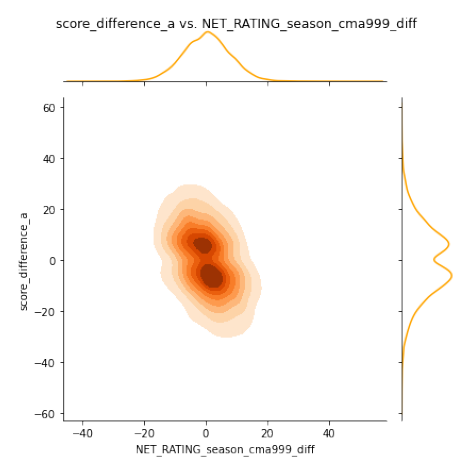

time: 67.4 ms (started: 2022-08-29 22:33:40 -07:00)


In [75]:
nsp.plot_kde(column_name_x='NET_RATING_season_cma999_diff', column_name_y='score_difference_a', df_game_id_column_y=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'], df_game_id_folds_012345678=df_game_id_folds_012345678, 
             df_game_id_column_x=df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff)

In [76]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_22', '_23', '_24', '_26', '_27', '_28', '_29', '_30', '_31', '_33', '_34', '_35', '_36', '_39', '_40', '_41', '_42', '_43', '_46', '_47', '_52', '_57', '_58', '_59', '_6', '_60', '_65', '_67', '_68', '_71', '_72', '_73', '_74', '_8', '__', '___', 'df_01', 'df_BOS_1011', 'df_MIA_1011', 'df_city_proper_metropolitan_area_gdp', 'df_game_id_game_date', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP', 'df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING', 'df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18', 'df_player_advanced_box_scores', 'df_player_advanced_box_scores_2009_10_2017_18', 'df_player_inactives', 'df_player_inactives_2009_10_2017_18', 'df_player_inactives_2010_11_2017_18', 'df_player_injury_report', 'df_readback', 'df_result', 'df_season_first_game_date_last_game_date', 'df_season_team_id_0_team_id_

<font size="4">Calculate Team Strength of Schedule and Related Features from Team Box Scores [[2]](#[2]) containing column 'wl' and Team Advanced Box Scores [[4]](#[4]) containing column 'matchup' for the 2010-11 thru 2017-18 seasons [[2]](#[2]). Then save it. </font>

In [77]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='54strength_of_schedule_difference_opponent_win_percentage_difference_win_percentage_difference_2010_2018.csv.gz', parse_dates=['game_date'])

if df_readback.empty == False:
    df_team_strength_of_schedule_collection_stacked_a_b_difference = {}
    df_team_strength_of_schedule_collection_stacked_a_b_difference['difference'] = df_readback
else:
    df_team_strength_of_schedule_collection_stacked_a_b_difference = \
    nsp.get_strength_of_schedule_and_related_features(df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b)

    df_team_strength_of_schedule_collection_stacked_a_b_difference['difference'] = save_and_return_data_frame(df=df_team_strength_of_schedule_collection_stacked_a_b_difference['difference'], 
                                                                                                              filename='54strength_of_schedule_difference_opponent_win_percentage_difference_win_percentage_difference_2010_2018.csv.gz',
                                                                                                              index=False,
                                                                                                              parse_dates=['game_date'])

p(df_team_strength_of_schedule_collection_stacked_a_b_difference['difference'])

This file already exists
(10266, 26)


game_id  game_date TEAM_ABBREVIATION_a TEAM_NAME_a   team_id_a  \
0      21000001 2010-10-26                 BOS     Celtics  1610612738   
1      21000002 2010-10-26                 PHX        Suns  1610612756   
2      21000003 2010-10-26                 HOU     Rockets  1610612745   
3      21000004 2010-10-27                 BOS     Celtics  1610612738   
4      21000005 2010-10-27                 DET     Pistons  1610612765   
10261  41700317 2018-05-28                 GSW    Warriors  1610612744   
10262  41700401 2018-05-31                 CLE   Cavaliers  1610612739   
10263  41700402 2018-06-03                 CLE   Cavaliers  1610612739   
10264  41700403 2018-06-06                 CLE   Cavaliers  1610612739   
10265  41700404 2018-06-08                 CLE   Cavaliers  1610612739   

           matchup   season wl_a    a    b TEAM_ABBREVIATION_b    TEAM_NAME_b  \
0      BOS vs. MIA  2010-11    W  BOS  MIA                 MIA           Heat   
1      PHX vs. POR  2010-11    L  PHX  POR                 POR  Trail Blazers   
2      HOU vs. LAL  2010-11    L  HOU  LAL                 LAL         Lakers   
3      BOS vs. CLE  2010-11    L  BOS  CLE                 CLE      Cavaliers   
4      DET vs. NJN  2010-11    L  DET  NJN                 NJN           Nets   
10261  GSW vs. HOU  2017-18    W  GSW  HOU                 HOU        Rockets   
10262  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   
10263  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   
10264  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   
10265  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   

        team_id_b wl_b  loss_diff  win_diff  losses_diff  wins_diff  \
0      1610612748    L       -1.0       1.0          0.0        0.0   
1      1610612757    W        1.0      -1.0          0.0        0.0   
2      1610612747    W        1.0      -1.0          0.0        0.0   
3      1610612739    W        1.0      -1.0          0.0        1.0   
4      1610612751    W        1.0      -1.0          0.0        0.0   
10261  1610612745    L       -1.0       1.0          7.0       -7.0   
10262  1610612744    W        1.0      -1.0          9.0       -8.0   
10263  1610612744    W        1.0      -1.0         10.0       -9.0   
10264  1610612744    W        1.0      -1.0         11.0      -10.0   
10265  1610612744    W        1.0      -1.0         12.0      -11.0   

       win_percentage_diff  opponent_win_percentage_diff  \
0                 0.000000                      0.000000   
1                 0.000000                      0.000000   
2                 0.000000                      0.000000   
3                 1.000000                     -1.000000   
4                 0.000000                      0.000000   
10261            -0.071429                      0.071429   
10262            -0.087071                      0.087071   
10263            -0.096139                      0.096139   
10264            -0.105028                      0.105028   
10265            -0.113745                      0.113745   

       opponent_losses_diff  opponent_wins_diff  \
0                       0.0                 0.0   
1                       0.0                 0.0   
2                       0.0                 0.0   
3                       0.0                -1.0   
4                       0.0                 0.0   
10261                  -7.0                 7.0   
10262                  -9.0                 8.0   
10263                 -10.0                 9.0   
10264                 -11.0                10.0   
10265                 -12.0                11.0   

       opponents_opponents_losses_diff  opponents_opponents_wins_diff  \
0                                  0.0                            0.0   
1                                  0.0                            0.0   
2                                  0.0                            0.0   
3   

time: 54.7 ms (started: 2022-08-29 22:33:40 -07:00)


<font size="4"> Combine and save the following data frames from the 2010-11 thru 2017-18 seasons:  <br /> Team Strength of Schedule Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Player Advanced Box Score Lost Contribution Sum, Mean, and Max Season Window Max 5, 12, 999 Game Moving Average Difference [[7]](#[7]) [[5]](#[5]) [[4]](#[4]),  <br /> Team Player Advanced Box Score Lost Contribution Sum, Mean, and Max Season Window Max 5, 12, 999 Game Moving Max Difference [[7]](#[7]) [[5]](#[5]) [[4]](#[4]),  <br /> Team Advanced Box Score and Team Box Score Season Window Max 5, 12, 999 Game Moving Average Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Window Max 5, 12, 999 Game Moving Max Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Matchup Window Max 12 Game Moving Average Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Matchup Window Max 12 Game Moving Max Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Window Max 12 Game Moving Average Season Matchup 12 Game Moving Max Difference [[4]](#[4]) [[2]](#[2])  <br /> </font>

In [78]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='59strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference_2010_2018.csv.gz', parse_dates=['game_date'])

if df_readback.empty == False:
    df_strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference = df_readback

else:
        #Merge 4 data frames

    #merge Team Strength of Schedule Difference, 
    #      Team Player Advanced Box Score and Team Player Box Score Lost Contribution Difference,
    #      Team Advanced Box Score and Team Box Score Difference,
    #      Team Advanced Box Score and Team Box Score Matchup Difference
    #      Team Away and Team Home

    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff = df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff.rename(columns={'team_a':'TEAM_NAME_a', 'team_b':'TEAM_NAME_b'})


    df_game_id_team_id_a_team_id_b_away_home_a_score_difference_a = df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'].loc[:, ['game_id', 'team_id_a', 'team_id_b', 'away_home_a', 'score_difference_a']]

    data_frame_list = [df_team_strength_of_schedule_collection_stacked_a_b_difference['difference'].drop(columns=['loss_diff', 'win_diff']),
                       df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff,
                       df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff,
                       df_team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b,
                       df_game_id_team_id_a_team_id_b_away_home_a_score_difference_a]

    #merge on the common column name for each left and right data frame
    df_strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference = reduce(lambda  left, right, : pd.merge(left,
                                                                                                                                        right,
                                                                                                                                        on=[column_name for column_name in left if column_name in right],
                                                                                                                                        how='inner'), 
                                                                                                        data_frame_list)
    
    #save it
    df_strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference = save_and_return_data_frame(df=df_strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference, 
                                                                                                                            filename='59strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference_2010_2018.csv.gz',
                                                                                                                            index=False,
                                                                                                                            parse_dates=['game_date'])
p(df_strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference)


This file already exists
(10266, 862)


game_id  game_date TEAM_ABBREVIATION_a TEAM_NAME_a   team_id_a  \
0      21000001 2010-10-26                 BOS     Celtics  1610612738   
1      21000002 2010-10-26                 PHX        Suns  1610612756   
2      21000003 2010-10-26                 HOU     Rockets  1610612745   
3      21000004 2010-10-27                 BOS     Celtics  1610612738   
4      21000005 2010-10-27                 DET     Pistons  1610612765   
10261  41700317 2018-05-28                 GSW    Warriors  1610612744   
10262  41700401 2018-05-31                 CLE   Cavaliers  1610612739   
10263  41700402 2018-06-03                 CLE   Cavaliers  1610612739   
10264  41700403 2018-06-06                 CLE   Cavaliers  1610612739   
10265  41700404 2018-06-08                 CLE   Cavaliers  1610612739   

           matchup   season wl_a    a    b TEAM_ABBREVIATION_b    TEAM_NAME_b  \
0      BOS vs. MIA  2010-11    W  BOS  MIA                 MIA           Heat   
1      PHX vs. POR  2010-11    L  PHX  POR                 POR  Trail Blazers   
2      HOU vs. LAL  2010-11    L  HOU  LAL                 LAL         Lakers   
3      BOS vs. CLE  2010-11    L  BOS  CLE                 CLE      Cavaliers   
4      DET vs. NJN  2010-11    L  DET  NJN                 NJN           Nets   
10261  GSW vs. HOU  2017-18    W  GSW  HOU                 HOU        Rockets   
10262  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   
10263  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   
10264  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   
10265  CLE vs. GSW  2017-18    L  CLE  GSW                 GSW       Warriors   

        team_id_b wl_b  losses_diff  wins_diff  win_percentage_diff  \
0      1610612748    L          0.0        0.0             0.000000   
1      1610612757    W          0.0        0.0             0.000000   
2      1610612747    W          0.0        0.0             0.000000   
3      1610612739    W          0.0        1.0             1.000000   
4      1610612751    W          0.0        0.0             0.000000   
10261  1610612745    L          7.0       -7.0            -0.071429   
10262  1610612744    W          9.0       -8.0            -0.087071   
10263  1610612744    W         10.0       -9.0            -0.096139   
10264  1610612744    W         11.0      -10.0            -0.105028   
10265  1610612744    W         12.0      -11.0            -0.113745   

       opponent_win_percentage_diff  opponent_losses_diff  opponent_wins_diff  \
0                          0.000000                   0.0                 0.0   
1                          0.000000                   0.0                 0.0   
2                          0.000000                   0.0                 0.0   
3                         -1.000000                   0.0                -1.0   
4                          0.000000                   0.0                 0.0   
10261                      0.071429                  -7.0                 7.0   
10262                      0.087071                  -9.0                 8.0   
10263                      0.096139                 -10.0                 9.0   
10264                      0.105028                 -11.0                10.0   
10265                      0.113745                 -12.0                11.0   

       opponents_opponents_losses_diff  opponents_opponents_wins_diff  \
0                                  0.0                            0.0   
1                                  0.0                            0.0   
2                                  0.0                            0.0   
3                                  0.0                            1.0   
4                                  0.0                            0.0   
10261                             26.0                           81.0   
10262                            -49.0                          -98.0   
10263                            -39.0     

time: 2.05 s (started: 2022-08-29 22:33:40 -07:00)


In [79]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_22', '_23', '_24', '_26', '_27', '_28', '_29', '_30', '_31', '_33', '_34', '_35', '_36', '_39', '_40', '_41', '_42', '_43', '_46', '_47', '_52', '_57', '_58', '_59', '_6', '_60', '_65', '_67', '_68', '_71', '_72', '_73', '_74', '_77', '_78', '_8', '__', '___', 'df_01', 'df_BOS_1011', 'df_MIA_1011', 'df_city_proper_metropolitan_area_gdp', 'df_game_id_game_date', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP', 'df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING', 'df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18', 'df_player_advanced_box_scores', 'df_player_advanced_box_scores_2009_10_2017_18', 'df_player_inactives', 'df_player_inactives_2009_10_2017_18', 'df_player_inactives_2010_11_2017_18', 'df_player_injury_report', 'df_readback', 'df_result', 'df_season_first_game_date_last_game_date', 'df_season_team

In [80]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='65game_id_game_date_team_id_season_back_to_back_game_count_window_max_2_5_12_999_diff_a_b.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_game_id_game_date_team_id_season_back_to_back_game_count_window_max_2_5_12_999_diff = df_readback
else:
    df_season_back_to_back_game_count_window_max_2_5_12_999_diff_season_back_to_back_game_mean_window_max_2_5_12_999_diff_a_b = nsp.get_team_back_to_back_game_season_sum_window_max_2_5_12_999_diff_back_to_back_game_season_mean_window_max_2_5_12_999_diff(df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['stacked'])

    df_season_back_to_back_game_count_window_max_2_5_12_999_diff_season_back_to_back_game_mean_window_max_2_5_12_999_diff_a_b = save_and_return_data_frame(df=df_season_back_to_back_game_count_window_max_2_5_12_999_diff_season_back_to_back_game_mean_window_max_2_5_12_999_diff_a_b, 
                                                                                                                                                           filename='65season_back_to_back_game_count_window_max_2_5_12_999_diff_season_back_to_back_game_mean_window_max_2_5_12_999_diff_a_b.csv.gz',
                                                                                                                                                           index=False,
                                                                                                                                                           parse_dates=['game_date'])
p(df_season_back_to_back_game_count_window_max_2_5_12_999_diff_season_back_to_back_game_mean_window_max_2_5_12_999_diff_a_b)

This file already exists.
(10266, 19)


game_id  game_date   team_id_a TEAM_ABBREVIATION_a TEAM_NAME_a  \
0      21000001 2010-10-26  1610612738                 BOS     Celtics   
1      21000002 2010-10-26  1610612756                 PHX        Suns   
2      21000003 2010-10-26  1610612745                 HOU     Rockets   
3      21000004 2010-10-27  1610612738                 BOS     Celtics   
4      21000005 2010-10-27  1610612765                 DET     Pistons   
10261  41700317 2018-05-28  1610612744                 GSW    Warriors   
10262  41700401 2018-05-31  1610612739                 CLE   Cavaliers   
10263  41700402 2018-06-03  1610612739                 CLE   Cavaliers   
10264  41700403 2018-06-06  1610612739                 CLE   Cavaliers   
10265  41700404 2018-06-08  1610612739                 CLE   Cavaliers   

        season   team_id_b TEAM_ABBREVIATION_b    TEAM_NAME_b  \
0      2010-11  1610612748                 MIA           Heat   
1      2010-11  1610612757                 POR  Trail Blazers   
2      2010-11  1610612747                 LAL         Lakers   
3      2010-11  1610612739                 CLE      Cavaliers   
4      2010-11  1610612751                 NJN           Nets   
10261  2017-18  1610612745                 HOU        Rockets   
10262  2017-18  1610612744                 GSW       Warriors   
10263  2017-18  1610612744                 GSW       Warriors   
10264  2017-18  1610612744                 GSW       Warriors   
10265  2017-18  1610612744                 GSW       Warriors   

       game_date_diff_1_day_season_csum2_diff  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
10261                                     0.0   
10262                                     0.0   
10263                                     0.0   
10264                                     0.0   
10265                                     0.0   

       game_date_diff_1_day_season_csum5_diff  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
10261                                     0.0   
10262                                     0.0   
10263                                     0.0   
10264                                     0.0   
10265                                     0.0   

       game_date_diff_1_day_season_csum12_diff  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
10261                                      0.0   
10262                                      0.0   
10263                                      0.0   
10264                                      0.0   
10265                                      0.0   

       game_date_diff_1_day_season_csum999_diff  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
10261                                       0.0   
10262                                      -1.0   
10263                                      -1.0   
10264                                      -1.0   
10265                                      -1.0   

       game_date_diff_1_day_season_cma2_diff  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0

time: 505 ms (started: 2022-08-29 22:33:42 -07:00)


In [81]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='63city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff.csv.gz', parse_dates=['game_date'])

if df_readback.empty == False:
    df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff = df_readback
else:
    df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff = nsp.get_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff(df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP)

    #save it
    df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff = save_and_return_data_frame(df=df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff, 
                                                                                                                                                                    filename='63city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff.csv.gz',
                                                                                                                                                                    index=False,
                                                                                                                                                                    parse_dates=['game_date'])
p(df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff)


This file already exists
(10266, 26)


game_id  game_date   team_id_a   TEAM_CITY_a  \
0      21000001 2010-10-26  1610612738        Boston   
1      21000002 2010-10-26  1610612756       Phoenix   
2      21000003 2010-10-26  1610612745       Houston   
3      21000004 2010-10-27  1610612738        Boston   
4      21000005 2010-10-27  1610612765       Detroit   
10261  41700317 2018-05-28  1610612744  Golden State   
10262  41700401 2018-05-31  1610612739     Cleveland   
10263  41700402 2018-06-03  1610612739     Cleveland   
10264  41700403 2018-06-06  1610612739     Cleveland   
10265  41700404 2018-06-08  1610612739     Cleveland   

      geographic_team_city_name_a city_proper_metro_area_a Country/Region_a  \
0                          Boston                   Boston    United States   
1                         Phoenix                  Phoenix    United States   
2                         Houston                  Houston    United States   
3                          Boston                   Boston    United States   
4                         Detroit                  Detroit    United States   
10261                Golden State            San Francisco    United States   
10262                   Cleveland                Cleveland    United States   
10263                   Cleveland                Cleveland    United States   
10264                   Cleveland                Cleveland    United States   
10265                   Cleveland                Cleveland    United States   

       geographic_game_city_name_latitude  \
0                               42.355433   
1                               45.520247   
2                               34.053691   
3                               41.499656   
4                               40.833989   
10261                           29.758938   
10262                           37.854666   
10263                           37.854666   
10264                           41.499656   
10265                           41.499656   

       geographic_game_city_name_longitude team_city_time_zone_a  \
0                               -71.060511      America/New_York   
1                              -122.674194       America/Phoenix   
2                              -118.242766       America/Chicago   
3                               -81.693681      America/New_York   
4                               -74.097087       America/Detroit   
10261                           -95.367697   America/Los_Angeles   
10262                          -122.292136      America/New_York   
10263                          -122.292136      America/New_York   
10264                           -81.693681      America/New_York   
10265                           -81.693681      America/New_York   

      game_city_time_zone_a   team_id_b   TEAM_CITY_b  \
0          America/New_York  1610612748         Miami   
1       America/Los_Angeles  1610612757      Portland   
2       America/Los_Angeles  1610612747   Los Angeles   
3          America/New_York  1610612739     Cleveland   
4          America/New_York  1610612751    New Jersey   
10261       America/Chicago  1610612745       Houston   
10262   America/Los_Angeles  1610612744  Golden State   
10263   America/Los_Angeles  1610612744  Golden State   
10264      America/New_York  1610612744  Golden State   
10265      America/New_York  1610612744  Golden State   

      geographic_team_city_name_b city_proper_metro_area_b Country/Region_b  \
0                           Miami                    Miami    United States   
1                        Portland                 Portland    United States   
2                     Los Angeles              Los Angeles    United States   
3                       Cleveland                Cleveland    United States   
4                 East Rutherford                 New York    United States   
10261                     Houston                  Houston    United States   
10262                Golden State            San Francisco    United States   
10263           

time: 59.7 ms (started: 2022-08-29 22:33:43 -07:00)


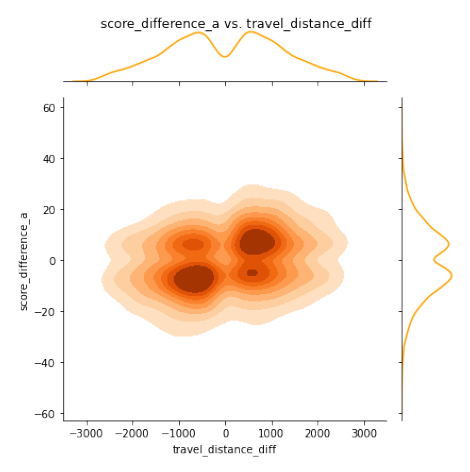

time: 68 ms (started: 2022-08-29 22:33:43 -07:00)


In [82]:
nsp.plot_kde(column_name_x='travel_distance_diff', column_name_y='score_difference_a', df_game_id_column_y=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'], df_game_id_folds_012345678=df_game_id_folds_012345678, 
             df_game_id_column_x=df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff)

In [83]:
#get game_id and travel distance diff
df_game_id_travel_distance = df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff.loc[:, ['game_id' , 'travel_distance_diff']].copy()
df_game_id_travel_distance.loc[:, 'travel_distance_diff'] = abs(df_game_id_travel_distance.loc[:, 'travel_distance_diff'])
df_game_id_travel_distance = df_game_id_travel_distance.rename(columns={'travel_distance_diff':'travel_distance'})

#filter for folds 0 thru 8
df_game_id_travel_distance = pd.merge(df_game_id_folds_012345678, df_game_id_travel_distance, on='game_id')
p(df_game_id_travel_distance)

(9240, 2)


game_id  travel_distance
0     21000001      1257.407116
1     21000002      1005.606849
2     21000003      1371.020326
3     21000004       549.419204
4     21000005       473.715215
9235  21700282      1417.523896
9236  21700283       190.822593
9237  21700284      1914.894744
9238  21700285      1238.167466
9239  21700286       361.335044

time: 9.45 ms (started: 2022-08-29 22:33:43 -07:00)


In [84]:
p(df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['stacked'])

(20532, 62)


game_id     team_id      TEAM_NAME TEAM_ABBREVIATION     TEAM_CITY  \
0      21000001  1610612738        Celtics               BOS        Boston   
1      21000001  1610612748           Heat               MIA         Miami   
2      21000002  1610612756           Suns               PHX       Phoenix   
3      21000002  1610612757  Trail Blazers               POR      Portland   
4      21000003  1610612745        Rockets               HOU       Houston   
20527  41700402  1610612744       Warriors               GSW  Golden State   
20528  41700403  1610612739      Cavaliers               CLE     Cleveland   
20529  41700403  1610612744       Warriors               GSW  Golden State   
20530  41700404  1610612739      Cavaliers               CLE     Cleveland   
20531  41700404  1610612744       Warriors               GSW  Golden State   

          MIN  E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  \
0      240:00          95.7        95.7          87.9        87.9   
1      240:00          87.9        87.9          95.7        95.7   
2      240:00          98.9       102.2         109.7       117.8   
3      240:00         109.7       117.8          98.9       102.2   
4      240:00         101.6       106.8         105.3       107.7   
20527  240:00         126.8       129.8         106.8       106.2   
20528  240:00         103.6       107.4         116.6       117.0   
20529  240:00         116.6       117.0         103.6       107.4   
20530  240:00          92.4        94.4         116.1       118.7   
20531  240:00         116.1       118.7          92.4        94.4   

       E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  OREB_PCT  \
0               7.7         7.7    0.781     1.25       20.0     0.268   
1              -7.7        -7.7    0.556     0.88       12.8     0.250   
2             -10.8       -15.6    0.417     0.79       13.0     0.244   
3              10.8        15.6    0.721     2.07       21.3     0.490   
4              -3.8        -0.9    0.658     1.19       16.7     0.396   
20527          20.0        23.6    0.596     2.33       21.3     0.289   
20528         -13.0        -9.7    0.500     1.43       15.0     0.389   
20529          13.0         9.7    0.643     2.45       21.2     0.195   
20530         -23.7       -24.2    0.700     1.91       16.2     0.333   
20531          23.7        24.2    0.641     2.50       19.5     0.319   

       DREB_PCT  REB_PCT  E_TM_TOV_PCT  TM_TOV_PCT  EFG_PCT  TS_PCT  USG_PCT  \
0         0.750    0.528        21.739        21.7    0.522   0.550      1.0   
1         0.732    0.472        18.681        18.7    0.419   0.471      1.0   
2         0.510    0.391        20.421        21.1    0.547   0.568      1.0   
3         0.756    0.609        15.528        16.7    0.516   0.532      1.0   
4         0.695    0.554        19.387        20.4    0.462   0.532      1.0   
20527     0.618    0.484        12.469        12.8    0.665   0.669      1.0   
20528     0.805    0.568        14.216        14.7    0.484   0.513      1.0   
20529     0.611    0.432        11.657        11.7    0.574   0.615      1.0   
20530     0.681    0.486        11.957        12.2    0.391   0.434      1.0   
20531     0.667    0.514        10.748        11.0    0.535   0.580      1.0   

       E_USG_PCT  E_PACE   PACE  PACE_PER40  POSS    PIE         duration  \
0          0.196   91.50   91.5       76.25    92  0.599  0 days 04:00:00   
1          0.200   91.50   91.5       76.25    91  0.401  0 days 04:00:00   
2          0.196   94.82   90.0       75.00    90  0.375  0 days 04:00:00   
3          0.192   94.82   90.0       75.00    90  0.625  0 days 04:00:00   
4          0.196  107.32  103.5       86.25   103  0.507  0 days 04:00:00   
20527      0.200   96.34   95.5       79.58    94  0.565  0 days 04:00:00   
20528      0.197   96.42   94.5       78.75    95  0.431  0 days 04:00:00   
20529      0.199   96.42   94.5       78.75    94  0.569  0 days 04:00:00   


time: 32 ms (started: 2022-08-29 22:33:43 -07:00)


In [85]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename = '66away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff = df_readback
else:
    df_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff = \
    nsp.get_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff(
    df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b)

    #save it
    df_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff = save_and_return_data_frame(df=df_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff, 
                                                                                                                                                         filename='66away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff.csv.gz',
                                                                                                                                                         index=False,
                                                                                                                                                         parse_dates=['game_date'])
p(df_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff)

This file already exists
(10266, 33)


game_id   team_id_a  game_date   season   team_id_b  away_home_diff  \
0      21000001  1610612738 2010-10-26  2010-11  1610612748             1.0   
1      21000002  1610612756 2010-10-26  2010-11  1610612757            -1.0   
2      21000003  1610612745 2010-10-26  2010-11  1610612747            -1.0   
3      21000004  1610612738 2010-10-27  2010-11  1610612739            -1.0   
4      21000005  1610612765 2010-10-27  2010-11  1610612751            -1.0   
10261  41700317  1610612744 2018-05-28  2017-18  1610612745            -1.0   
10262  41700401  1610612739 2018-05-31  2017-18  1610612744            -1.0   
10263  41700402  1610612739 2018-06-03  2017-18  1610612744            -1.0   
10264  41700403  1610612739 2018-06-06  2017-18  1610612744             1.0   
10265  41700404  1610612739 2018-06-08  2017-18  1610612744             1.0   

       home_diff  away_diff  away_game_day_window_csum2_diff  \
0            1.0       -1.0                             -1.0   
1           -1.0        1.0                              1.0   
2           -1.0        1.0                              1.0   
3           -1.0        1.0                              1.0   
4           -1.0        1.0                              1.0   
10261       -1.0        1.0                              1.0   
10262       -1.0        1.0                              1.0   
10263       -1.0        1.0                              1.0   
10264        1.0       -1.0                             -1.0   
10265        1.0       -1.0                             -1.0   

       home_game_day_window_csum2_diff  game_day_window_csum2_diff  \
0                                  1.0                         0.0   
1                                 -1.0                         0.0   
2                                 -1.0                         0.0   
3                                  0.0                         1.0   
4                                 -1.0                         0.0   
10261                             -1.0                         0.0   
10262                             -1.0                         0.0   
10263                             -1.0                         0.0   
10264                              1.0                         0.0   
10265                              1.0                         0.0   

       away_game_percent_day_window2_diff  home_game_percent_day_window2_diff  \
0                                    -1.0                                 1.0   
1                                     1.0                                -1.0   
2                                     1.0                                -1.0   
3                                     0.5                                -0.5   
4                                     1.0                                -1.0   
10261                                 1.0                                -1.0   
10262                                 1.0                                -1.0   
10263                                 1.0                                -1.0   
10264                                -1.0                                 1.0   
10265                                -1.0                                 1.0   

       away_game_day_window_csum5_diff  home_game_day_window_csum5_diff  \
0                                 -1.0                              1.0   
1                                  1.0                             -1.0   
2                                  1.0                             -1.0   
3                                  1.0                              0.0   
4                                  1.0                             -1.0   
10261                              1.0                             -1.0   
10262                              1.0                             -1.0   
10263                              2.0                             -2.0   
10264                              0.0                              0.0   
10265               

time: 63 ms (started: 2022-08-29 22:33:43 -07:00)


In [86]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='66future_away_home_empty_game_count_day_window_2_5_8_12_999_diff_future_away_home_game_percentage_day_window_2_5_8_12_999_diff.csv.gz', parse_dates=['game_date'])
if df_readback.empty == False:
    df_regular_season_playoffs_future_away_home_empty_game_count_day_window_max_diff_future_away_home_game_percentage_day_window_max_diff = df_readback
else:
    df_regular_season_playoffs_future_away_home_empty_game_count_day_window_max_diff_future_away_home_game_percentage_day_window_max_diff = \
    nsp.get_future_away_home_empty_game_count_day_window_2_5_8_12_999_diff_future_away_home_game_percentage_day_window_2_5_8_12_999_diff(
        df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b)
    
    #save it
    df_regular_season_playoffs_future_away_home_empty_game_count_day_window_max_diff_future_away_home_game_percentage_day_window_max_diff = save_and_return_data_frame(df=df_regular_season_playoffs_future_away_home_empty_game_count_day_window_max_diff_future_away_home_game_percentage_day_window_max_diff, 
                                                                                                                                                                       filename='66future_away_home_empty_game_count_day_window_2_5_8_12_999_diff_future_away_home_game_percentage_day_window_2_5_8_12_999_diff.csv.gz',
                                                                                                                                                                       index=False,
                                                                                                                                                                       parse_dates=['game_date'])
p(df_regular_season_playoffs_future_away_home_empty_game_count_day_window_max_diff_future_away_home_game_percentage_day_window_max_diff)

This file already exists
(10266, 34)


game_id  game_date   team_id_a   season     season_type   team_id_b  \
0      21000001 2010-10-26  1610612738  2010-11  Regular Season  1610612748   
1      21000002 2010-10-26  1610612756  2010-11  Regular Season  1610612757   
2      21000003 2010-10-26  1610612745  2010-11  Regular Season  1610612747   
3      21000004 2010-10-27  1610612738  2010-11  Regular Season  1610612739   
4      21000005 2010-10-27  1610612765  2010-11  Regular Season  1610612751   
10261  41700317 2018-05-28  1610612744  2017-18        Playoffs  1610612745   
10262  41700401 2018-05-31  1610612739  2017-18        Playoffs  1610612744   
10263  41700402 2018-06-03  1610612739  2017-18        Playoffs  1610612744   
10264  41700403 2018-06-06  1610612739  2017-18        Playoffs  1610612744   
10265  41700404 2018-06-08  1610612739  2017-18        Playoffs  1610612744   

       away_home_diff  home_diff  away_diff  \
0                 1.0        1.0       -1.0   
1                -1.0       -1.0        1.0   
2                -1.0       -1.0        1.0   
3                -1.0       -1.0        1.0   
4                -1.0       -1.0        1.0   
10261            -1.0       -1.0        1.0   
10262            -1.0       -1.0        1.0   
10263            -1.0       -1.0        1.0   
10264             1.0        1.0       -1.0   
10265             1.0        1.0       -1.0   

       future_away_game_count_day_window2_diff  \
0                                         -1.0   
1                                          0.0   
2                                          2.0   
3                                          1.0   
4                                          1.0   
10261                                      0.0   
10262                                      0.0   
10263                                      0.0   
10264                                      0.0   
10265                                      0.0   

       future_home_game_count_day_window2_diff  \
0                                          1.0   
1                                         -1.0   
2                                         -1.0   
3                                         -1.0   
4                                         -1.0   
10261                                      0.0   
10262                                      0.0   
10263                                      0.0   
10264                                      0.0   
10265                                      0.0   

       future_game_count_day_window2_diff  \
0                                     0.0   
1                                    -1.0   
2                                     1.0   
3                                     0.0   
4                                     0.0   
10261                                 0.0   
10262                                 0.0   
10263                                 0.0   
10264                                 0.0   
10265                                 0.0   

       future_away_game_percent_day_window2_diff  \
0                                           -0.5   
1                                            0.5   
2                                            1.0   
3                                            1.0   
4                                            1.0   
10261                                        0.0   
10262                                        0.0   
10263                                        0.0   
10264                                        0.0   
10265                                        0.0   

       future_home_game_percent_day_window2_diff  \
0                                            0.5   
1                                           -0.5   
2                                           -1.0   
3                                           -1.0   
4                                           -1.0   
10261                                        0.0   
10262                                        0.0   
10263                            

time: 62.5 ms (started: 2022-08-29 22:33:43 -07:00)


In [87]:
data_frame_list = [df_season_back_to_back_game_count_window_max_2_5_12_999_diff_season_back_to_back_game_mean_window_max_2_5_12_999_diff_a_b,
                   df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff,
                   df_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff,
                   df_regular_season_playoffs_future_away_home_empty_game_count_day_window_max_diff_future_away_home_game_percentage_day_window_max_diff]

df_city_proper_metro_area_gdp_latitude_longitude_travel_distance_away_home_game_percentage_day_window_future_away_home_game_percentage_day_window = nsp.merge_data_frame_list(data_frame_list)

p(df_city_proper_metro_area_gdp_latitude_longitude_travel_distance_away_home_game_percentage_day_window_future_away_home_game_percentage_day_window)

(10266, 94)


game_id  game_date   team_id_a TEAM_ABBREVIATION_a TEAM_NAME_a  \
0      21000001 2010-10-26  1610612738                 BOS     Celtics   
1      21000002 2010-10-26  1610612756                 PHX        Suns   
2      21000003 2010-10-26  1610612745                 HOU     Rockets   
3      21000004 2010-10-27  1610612738                 BOS     Celtics   
4      21000005 2010-10-27  1610612765                 DET     Pistons   
10261  41700317 2018-05-28  1610612744                 GSW    Warriors   
10262  41700401 2018-05-31  1610612739                 CLE   Cavaliers   
10263  41700402 2018-06-03  1610612739                 CLE   Cavaliers   
10264  41700403 2018-06-06  1610612739                 CLE   Cavaliers   
10265  41700404 2018-06-08  1610612739                 CLE   Cavaliers   

        season   team_id_b TEAM_ABBREVIATION_b    TEAM_NAME_b  \
0      2010-11  1610612748                 MIA           Heat   
1      2010-11  1610612757                 POR  Trail Blazers   
2      2010-11  1610612747                 LAL         Lakers   
3      2010-11  1610612739                 CLE      Cavaliers   
4      2010-11  1610612751                 NJN           Nets   
10261  2017-18  1610612745                 HOU        Rockets   
10262  2017-18  1610612744                 GSW       Warriors   
10263  2017-18  1610612744                 GSW       Warriors   
10264  2017-18  1610612744                 GSW       Warriors   
10265  2017-18  1610612744                 GSW       Warriors   

       game_date_diff_1_day_season_csum2_diff  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
10261                                     0.0   
10262                                     0.0   
10263                                     0.0   
10264                                     0.0   
10265                                     0.0   

       game_date_diff_1_day_season_csum5_diff  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
10261                                     0.0   
10262                                     0.0   
10263                                     0.0   
10264                                     0.0   
10265                                     0.0   

       game_date_diff_1_day_season_csum12_diff  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
10261                                      0.0   
10262                                      0.0   
10263                                      0.0   
10264                                      0.0   
10265                                      0.0   

       game_date_diff_1_day_season_csum999_diff  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
10261                                       0.0   
10262                                      -1.0   
10263                                      -1.0   
10264                                      -1.0   
10265                                      -1.0   

       game_date_diff_1_day_season_cma2_diff  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0

time: 84.8 ms (started: 2022-08-29 22:33:43 -07:00)


In [88]:
del df_season_back_to_back_game_count_window_max_2_5_12_999_diff_season_back_to_back_game_mean_window_max_2_5_12_999_diff_a_b,\
    df_city_proper_metro_area_GDP_diff_geographic_team_city_name_latitude_diff_longitude_diff_travel_distance_diff_time_zone_diff_diff,\
    df_away_home_empty_game_count_day_window_2_5_8_12_999_diff_away_home_game_count_percentage_day_window_2_5_8_12_999_diff, \
    df_regular_season_playoffs_future_away_home_empty_game_count_day_window_max_diff_future_away_home_game_percentage_day_window_max_diff

time: 326 µs (started: 2022-08-29 22:33:43 -07:00)


In [89]:
df_score_difference_a_2010_2018 = df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'].loc[:, ['score_difference_a']]
p(df_score_difference_a_2010_2018)

(10266, 1)


score_difference_a
0                      -8
1                      14
2                       2
3                       8
4                       3
10261                  -9
10262                  10
10263                  19
10264                   8
10265                  23

time: 3.34 ms (started: 2022-08-29 22:33:43 -07:00)


In [90]:
df_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a = df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'].loc[:, ['game_id', 'game_date', 'team_id_a', 'team_id_b', 'away_home_a', 'score_difference_a']]
p(df_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a)


(10266, 6)


game_id  game_date   team_id_a   team_id_b  away_home_a  \
0      21000001 2010-10-26  1610612738  1610612748            1   
1      21000002 2010-10-26  1610612756  1610612757            0   
2      21000003 2010-10-26  1610612745  1610612747            0   
3      21000004 2010-10-27  1610612738  1610612739            0   
4      21000005 2010-10-27  1610612765  1610612751            0   
10261  41700317 2018-05-28  1610612744  1610612745            0   
10262  41700401 2018-05-31  1610612739  1610612744            0   
10263  41700402 2018-06-03  1610612739  1610612744            0   
10264  41700403 2018-06-06  1610612739  1610612744            1   
10265  41700404 2018-06-08  1610612739  1610612744            1   

       score_difference_a  
0                      -8  
1                      14  
2                       2  
3                       8  
4                       3  
10261                  -9  
10262                  10  
10263                  19  
10264                   8  
10265                  23

time: 6.22 ms (started: 2022-08-29 22:33:43 -07:00)


In [91]:
#get df_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a

from sklearn.model_selection import TimeSeriesSplit
time_series_cross_validation_9_splits = TimeSeriesSplit(max_train_size=None, n_splits=9)


df_test_collection = {}

for i, (train_indices, test_indices) in enumerate(time_series_cross_validation_9_splits.split(df_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a)):    
    df_test_collection[i] = df_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a.iloc[test_indices, :]

#convert data frame collection to data frame
df_time_series_cross_validation_9_splits_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a = pd.DataFrame()
for i in range(len(df_test_collection)):
    df_time_series_cross_validation_9_splits_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a = pd.concat([df_time_series_cross_validation_9_splits_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a, df_test_collection[i]])

#reset index
df_time_series_cross_validation_9_splits_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a = df_time_series_cross_validation_9_splits_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a.reset_index(drop=True)
p(df_time_series_cross_validation_9_splits_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a)


(9234, 6)


game_id  game_date   team_id_a   team_id_b  away_home_a  \
0     21001034 2011-03-19  1610612755  1610612757            0   
1     21001035 2011-03-20  1610612751  1610612764            0   
2     21001036 2011-03-20  1610612737  1610612765            1   
3     21001037 2011-03-20  1610612749  1610612752            1   
4     21001038 2011-03-20  1610612750  1610612758            1   
9229  41700317 2018-05-28  1610612744  1610612745            0   
9230  41700401 2018-05-31  1610612739  1610612744            0   
9231  41700402 2018-06-03  1610612739  1610612744            0   
9232  41700403 2018-06-06  1610612739  1610612744            1   
9233  41700404 2018-06-08  1610612739  1610612744            1   

      score_difference_a  
0                      9  
1                      6  
2                     -8  
3                     -5  
4                     32  
9229                  -9  
9230                  10  
9231                  19  
9232                   8  
9233                  23

time: 12.3 ms (started: 2022-08-29 22:33:43 -07:00)


In [92]:
from platform import python_version
print(python_version())

3.9.7
time: 356 µs (started: 2022-08-29 22:33:43 -07:00)


In [93]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_22', '_23', '_24', '_26', '_27', '_28', '_29', '_30', '_31', '_33', '_34', '_35', '_36', '_39', '_40', '_41', '_42', '_43', '_46', '_47', '_52', '_57', '_58', '_59', '_6', '_60', '_65', '_67', '_68', '_71', '_72', '_73', '_74', '_77', '_78', '_8', '_80', '_81', '_83', '_84', '_85', '_86', '_87', '_89', '_90', '_91', '__', '___', 'df_01', 'df_BOS_1011', 'df_MIA_1011', 'df_city_proper_metro_area_gdp_latitude_longitude_travel_distance_away_home_game_percentage_day_window_future_away_home_game_percentage_day_window', 'df_city_proper_metropolitan_area_gdp', 'df_game_id_game_date', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name', 'df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP', 'df_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a', 'df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING', 'df_game_id_travel_distance', 'df_player_active_2009_10_2017_18_player_i

In [94]:
del df_player_inactives_2009_10_2017_18, \
    df_player_inactives_2010_11_2017_18, \
    df_player_inactives, \
    df_readback, \
    df_season_first_game_date_last_game_date, \
    df_team_advanced_box_scores, \
    df_team_box_scores_2_1, \
    df_team_box_scores_2_1_away_home, \
    df_team_id_abbreviation_nickname, \
    df_team_box_scores_2_1_away_home_2009_10_2017_18, \
    df_team_player_advanced_box_score_lost_contribution_sum_mean_max_cma5_12_999_diff_sum_mean_max_cmax5_12_999_diff, \
    df_team_advanced_box_score_team_box_score_season_cma5_12_999_diff_cmax5_12_999_diff, \
    df_player_advanced_box_scores, \
    df_team_advanced_box_scores_away_home_team_box_scores_away_home, \
    df_team_advanced_box_score_team_box_score_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b, \
    df_team_advanced_box_score_team_box_score_season_matchup_cma12_diff_season_matchup_cmax12_diff_and_season_cma12_season_matchup_cmax12_diff_a_b,\
    df_team_advanced_box_score_season_matchup_cma12_diff_team_box_score_season_matchup_cma12_diff_a_b,\
    df_player_injury_report,\
    df_player_advanced_box_scores_2009_10_2017_18,\
    df_player_active_2009_10_2017_18_player_inactives_2009_10_2017_18,\
    df_game_id_game_date_TEAM_CITY_geographic_team_city_name_city_proper_metro_area_GDP,\
    df_game_id_game_date_TEAM_CITY_geographic_team_city_name,\
    df_city_proper_metropolitan_area_gdp
    
    

time: 69.3 ms (started: 2022-08-29 22:33:43 -07:00)


In [95]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['_', '_10', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_22', '_23', '_24', '_26', '_27', '_28', '_29', '_30', '_31', '_33', '_34', '_35', '_36', '_39', '_40', '_41', '_42', '_43', '_46', '_47', '_52', '_57', '_58', '_59', '_6', '_60', '_65', '_67', '_68', '_71', '_72', '_73', '_74', '_77', '_78', '_8', '_80', '_81', '_83', '_84', '_85', '_86', '_87', '_89', '_90', '_91', '__', '___', 'df_01', 'df_BOS_1011', 'df_MIA_1011', 'df_city_proper_metro_area_gdp_latitude_longitude_travel_distance_away_home_game_percentage_day_window_future_away_home_game_percentage_day_window', 'df_game_id_game_date', 'df_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a', 'df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING', 'df_game_id_travel_distance', 'df_result', 'df_score_difference_a_2010_2018', 'df_season_team_id_0_team_id_1_NET_RATING_p_value_permutation_10000', 'df_season_team_id_0_team_id_1_t_statistic_p_value_NET_RATING', 'df_sportsbook_spread', 'df_strength_of_schedul

<font size="5"><a id='[Data_Preprocessing]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

<font size="6"><a id='[Data_Preprocessing]'>Data Preprocessing</a> </font>


<font size="4"> Preprocess and save the following for the 2010-11 thru 2017-18 seasons:  <br /> Team Strength of Schedule Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Player Advanced Box Score Lost Contribution Sum, Mean, and Max Season Window Max 5, 12, 999 Game Moving Average Difference [[7]](#[7]) [[5]](#[5]) [[4]](#[4]),  <br /> Team Player Advanced Box Score Lost Contribution Sum, Mean, and Max Season Window Max 5, 12, 999 Game Moving Max Difference [[7]](#[7]) [[5]](#[5]) [[4]](#[4]),  <br /> Team Advanced Box Score and Team Box Score Season Window Max 5, 12, 999 Game Moving Average Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Window Max 5, 12, 999 Game Moving Max Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Matchup Window Max 12 Game Moving Average Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Matchup Window Max 12 Game Moving Max Difference [[4]](#[4]) [[2]](#[2]),  <br /> Team Advanced Box Score and Team Box Score Season Window Max 12 Game Moving Average Season Matchup 12 Game Moving Max Difference [[4]](#[4]) [[2]](#[2])  <br /> </font>

In [96]:
#get 161 train test data frame collection for hyperparameter tuning
df_readback = nsp.return_processed_collection_if_it_exists(filename='161data_frame_collection_train_test.pkl', parse_dates=False)

if df_readback != None:
    data_frame_collection_train_test_161 = df_readback
else:
    data_frame_collection_train_test_161 = nsp.preprocess_data_frame_for_numerics_161(df_strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference)

    #save it
    data_frame_collection_train_test_161 = nsp.save_and_return_collection(data_frame_collection=data_frame_collection_train_test_161, 
                                                                          filename='161data_frame_collection_train_test.pkl',
                                                                          index=False,
                                                                          parse_dates=False)
p(data_frame_collection_train_test_161['train'])

This file already exists
(9239, 841)


away_home_a  losses_diff  wins_diff  win_pct_diff  opp_win_pct_diff  \
0        1.000585     0.052352  -0.051047     -0.051521          0.051521   
1       -0.999416     0.052352  -0.051047     -0.051521          0.051521   
2       -0.999416     0.052352  -0.051047     -0.051521          0.051521   
3       -0.999416     0.052352   0.044478      3.786720         -3.786720   
4       -0.999416     0.052352  -0.051047     -0.051521          0.051521   
9234    -0.999416    -0.423851   0.522104      0.988844         -0.988844   
9235     1.000585    -0.328610   0.331054      0.801421         -0.801421   
9236     1.000585     0.528554  -0.433148     -0.949356          0.949356   
9237     1.000585    -0.233370   0.235528      0.554517         -0.554517   
9238    -0.999416    -0.233370   0.044478      0.364387         -0.364387   

      opp_losses_diff  opp_wins_diff  opp_opps_losses_diff  \
0           -0.052352       0.051047              0.014667   
1           -0.052352       0.051047              0.014667   
2           -0.052352       0.051047              0.014667   
3           -0.052352      -0.044478              0.014667   
4           -0.052352       0.051047              0.014667   
9234         0.423851      -0.522104             -0.576102   
9235         0.328610      -0.331054              0.254667   
9236        -0.528554       0.433148              0.365436   
9237         0.233370      -0.235528              0.254667   
9238         0.233370      -0.044478              0.143898   

      opp_opps_wins_diff  opp_opps_win_pct_diff  strength_of_schedule_diff  \
0               0.007220              -0.013957                   0.053960   
1               0.007220              -0.013957                   0.053960   
2               0.007220              -0.013957                   0.053960   
3               0.026453               8.989657                   0.053960   
4               0.007220              -0.013957                   0.053960   
9234            0.334179               1.179489                  -0.819677   
9235            0.314946               0.072064                  -0.873725   
9236           -0.223574              -0.817651                   0.861512   
9237           -0.088944              -0.468469                  -0.727349   
9238            0.122617              -0.023263                  -0.410536   

      season_year  lc_sum_MIN_cma5_diff  lc_sum_E_OFF_RATING_cma5_diff  \
0       -1.557382             -0.037452                      -0.040483   
1       -1.557382             -0.037452                      -0.040483   
2       -1.557382             -0.037452                      -0.040483   
3       -1.557382              1.385736                       1.491048   
4       -1.557382             -0.037452                      -0.040483   
9234     1.507062              0.130744                      -1.291781   
9235     1.507062             -0.239133                       0.152374   
9236     1.507062              1.436579                       1.195557   
9237     1.507062             -1.084348                      -1.715681   
9238     1.507062              0.198655                       0.633445   

      lc_sum_OFF_RATING_cma5_diff  lc_sum_E_DEF_RATING_cma5_diff  \
0                       -0.043187                      -0.040866   
1                       -0.043187                      -0.040866   
2                       -0.043187                      -0.040866   
3                        1.516145                       1.313541   
4                       -0.043187                      -0.040866   
9234                    -1.297943                      -1.396696   
9235                     0.057814                       0.240375   
9236                     1.198569                       0.302589   
9237                    -1.939482                      -1.138963   
9238                     0.630571                       1.886386   

      lc_sum_DEF_RATING_cma5_diff  lc_sum_E_NET_RATI

time: 340 ms (started: 2022-08-29 22:33:43 -07:00)


In [98]:
#get train data frames for 161 time series cross validation
X_time_series_cross_validation_index_8_train, Y_time_series_cross_validation_index_8_train, df_time_series_cross_validation_index_8_train, df_time_series_cross_validation_index_8_test = nsp.get_random_forest_time_series_cross_validation_index_8_train_test()
p(X_time_series_cross_validation_index_8_train)

(9240, 840)


away_home_a  losses_diff  wins_diff  win_pct_diff  opp_win_pct_diff  \
0        1.000585     0.052352  -0.051047     -0.051521          0.051521   
1       -0.999416     0.052352  -0.051047     -0.051521          0.051521   
2       -0.999416     0.052352  -0.051047     -0.051521          0.051521   
3       -0.999416     0.052352   0.044478      3.786720         -3.786720   
4       -0.999416     0.052352  -0.051047     -0.051521          0.051521   
9235     1.000585    -0.328610   0.331054      0.801421         -0.801421   
9236     1.000585     0.528554  -0.433148     -0.949356          0.949356   
9237     1.000585    -0.233370   0.235528      0.554517         -0.554517   
9238    -0.999416    -0.233370   0.044478      0.364387         -0.364387   
9239    -0.999416    -0.138129   0.044478      0.236974         -0.236974   

      opp_losses_diff  opp_wins_diff  opp_opps_losses_diff  \
0           -0.052352       0.051047              0.014667   
1           -0.052352       0.051047              0.014667   
2           -0.052352       0.051047              0.014667   
3           -0.052352      -0.044478              0.014667   
4           -0.052352       0.051047              0.014667   
9235         0.328610      -0.331054              0.254667   
9236        -0.528554       0.433148              0.365436   
9237         0.233370      -0.235528              0.254667   
9238         0.233370      -0.044478              0.143898   
9239         0.138129      -0.044478             -0.114564   

      opp_opps_wins_diff  opp_opps_win_pct_diff  strength_of_schedule_diff  \
0               0.007220              -0.013957                   0.053960   
1               0.007220              -0.013957                   0.053960   
2               0.007220              -0.013957                   0.053960   
3               0.026453               8.989657                   0.053960   
4               0.007220              -0.013957                   0.053960   
9235            0.314946               0.072064                  -0.873725   
9236           -0.223574              -0.817651                   0.861512   
9237           -0.088944              -0.468469                  -0.727349   
9238            0.122617              -0.023263                  -0.410536   
9239            0.218782               0.469836                  -0.152088   

      season_year  lc_sum_MIN_cma5_diff  lc_sum_E_OFF_RATING_cma5_diff  \
0       -1.557382             -0.037452                      -0.040483   
1       -1.557382             -0.037452                      -0.040483   
2       -1.557382             -0.037452                      -0.040483   
3       -1.557382              1.385736                       1.491048   
4       -1.557382             -0.037452                      -0.040483   
9235     1.507062             -0.239133                       0.152374   
9236     1.507062              1.436579                       1.195557   
9237     1.507062             -1.084348                      -1.715681   
9238     1.507062              0.198655                       0.633445   
9239     1.507062              1.013920                      -0.013948   

      lc_sum_OFF_RATING_cma5_diff  lc_sum_E_DEF_RATING_cma5_diff  \
0                       -0.043187                      -0.040866   
1                       -0.043187                      -0.040866   
2                       -0.043187                      -0.040866   
3                        1.516145                       1.313541   
4                       -0.043187                      -0.040866   
9235                     0.057814                       0.240375   
9236                     1.198569                       0.302589   
9237                    -1.939482                      -1.138963   
9238                     0.630571                       1.886386   
9239                     0.100136                      -0.243465   

      lc_sum_DEF_RATING_cma5_diff  lc_sum_E_NET_RATI

time: 488 ms (started: 2022-08-29 22:33:43 -07:00)


<font size="4"> Preprocess and save the following for the 2010-11 thru 2017-18 seasons:  <br /> City Proper Metro Area Gdp Latitude Longitude Travel Distance Away Home Game Percentage Day Window Future Away Home Game Percentage Day Window [[8]](#[8]) [[4]](#[4])  <br /> </font>

In [100]:
df_features_numeric, df_target, df_indicator_variables = nsp.get_172_preprocessed_by_column_name_dictionary_and_game_latitude_diff_game_longitude_diff_values(df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b,
                                                                                                                                                              df_city_proper_metro_area_gdp_latitude_longitude_travel_distance_away_home_game_percentage_day_window_future_away_home_game_percentage_day_window,
                                                                                                                                                              method_1_2=1)
data_frame_collection_train_test_172, data_frame_collection_train_test_172_indicator_variables = nsp.get_172_preprocessed_by_scaling_and_train_test_splits(df_features_numeric,
                                                                                                                                                           df_target,
                                                                                                                                                           df_indicator_variables)
#save it
data_frame_collection_train_test_172 = nsp.save_and_return_collection(data_frame_collection=data_frame_collection_train_test_172, 
                                                                      filename='172data_frame_collection_train_test.pkl',
                                                                      index=False,
                                                                      parse_dates=False)
#save it
data_frame_collection_train_test_172_indicator_variables = nsp.save_and_return_collection(data_frame_collection=data_frame_collection_train_test_172_indicator_variables, 
                                                                                          filename='172data_frame_collection_train_test_172_indicator_variables.pkl',
                                                                                          index=False,
                                                                                          parse_dates=False)
p(data_frame_collection_train_test_172['train'])

This file already exists.
This file already exists.
(9239, 71)


game_date_diff_diff  travel_distance_diff  \
0               -0.016167             -1.045651   
1               -0.016167              0.835098   
2               -0.016167              1.138787   
3               -6.722156              0.455969   
4               -0.016167              0.393053   
9234            -0.016167              0.668731   
9235             1.660330             -1.178721   
9236             1.660330             -0.159232   
9237            -0.016167             -1.592077   
9238            -0.016167              1.028375   

      away_game_percent_day_window2_diff  home_game_percent_day_window2_diff  \
0                              -1.098300                            1.098300   
1                               1.095736                           -1.095736   
2                               1.095736                           -1.095736   
3                               0.547227                           -0.547227   
4                               1.095736                           -1.095736   
9234                            0.547227                           -0.547227   
9235                           -1.098300                            1.098300   
9236                           -0.549791                            0.549791   
9237                           -1.098300                            1.098300   
9238                            1.095736                           -1.095736   

      away_game_percent_day_window5_diff  home_game_percent_day_window5_diff  \
0                              -1.860644                            1.860644   
1                               1.841889                           -1.841889   
2                               1.841889                           -1.841889   
3                               0.916256                           -0.916256   
4                               1.841889                           -1.841889   
9234                            1.224801                           -1.224801   
9235                           -1.243555                            1.243555   
9236                            0.299167                           -0.299167   
9237                           -0.626466                            0.626466   
9238                            1.841889                           -1.841889   

      away_game_percent_day_window8_diff  home_game_percent_day_window8_diff  \
0                              -2.477298                            2.477298   
1                               2.447929                           -2.447929   
2                               2.447929                           -2.447929   
3                               1.216622                           -1.216622   
4                               2.447929                           -2.447929   
9234                            0.724099                           -0.724099   
9235                           -0.425120                            0.425120   
9236                           -0.630338                            0.630338   
9237                            0.231577                           -0.231577   
9238                            0.600969                           -0.600969   

      away_game_percent_day_window12_diff  \
0                               -3.197979   
1                                3.178224   
2                                3.178224   
3                                1.584173   
4                                3.178224   
9234                             0.673287   
9235                            -0.328688   
9236                            -1.072578   
9237                             0.521473   
9238                            -0.222418   

      home_game_percent_day_window12_diff  \
0                                3.197979   
1                               -3.178224   
2                               -3.178224   
3                               -1.584173   
4                               -3.178224   
9234                            -0.

time: 91.8 ms (started: 2022-08-29 22:33:44 -07:00)


In [101]:
p(data_frame_collection_train_test_172_indicator_variables['train'])

(9239, 156)


team_id_a_1610612737  team_id_a_1610612738  team_id_a_1610612739  \
0                        0                     1                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     1                     0   
4                        0                     0                     0   
9234                     0                     1                     0   
9235                     0                     0                     0   
9236                     0                     0                     0   
9237                     0                     0                     0   
9238                     0                     0                     0   

      team_id_a_1610612740  team_id_a_1610612741  team_id_a_1610612742  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
9234                     0                     0                     0   
9235                     0                     0                     0   
9236                     0                     0                     1   
9237                     0                     0                     0   
9238                     0                     0                     0   

      team_id_a_1610612743  team_id_a_1610612744  team_id_a_1610612745  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     1   
3                        0                     0                     0   
4                        0                     0                     0   
9234                     0                     0                     0   
9235                     0                     0                     1   
9236                     0                     0                     0   
9237                     0                     1                     0   
9238                     0                     0                     0   

      team_id_a_1610612746  team_id_a_1610612747  team_id_a_1610612748  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
9234                     0                     0                     0   
9235                     0                     0                     0   
9236                     0                     0                     0   
9237                     0                     0                     0   
9238                     0                     0                     0   

      team_id_a_1610612749  team_id_a_1610612750  team_id_a_1610612751  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
9234                     0                     0                     0   
9235                     0                     0                     0   
9236                     0                     0                     0   
9237                     0                     0                     0   
9238  

time: 33.5 ms (started: 2022-08-29 22:33:44 -07:00)


In [103]:
df_score_difference_a_2010_2018 = df_score_difference_a_2010_2018.rename(columns={'score_difference_a':'spread_a'})

p(df_score_difference_a_2010_2018)

(10266, 1)


spread_a
0            -8
1            14
2             2
3             8
4             3
10261        -9
10262        10
10263        19
10264         8
10265        23

time: 3.48 ms (started: 2022-08-29 22:33:44 -07:00)


In [104]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]
print(data_frames)

['X_time_series_cross_validation_index_8_train', 'Y_time_series_cross_validation_index_8_train', '_', '_10', '_100', '_101', '_103', '_11', '_13', '_14', '_16', '_17', '_18', '_20', '_22', '_23', '_24', '_26', '_27', '_28', '_29', '_30', '_31', '_33', '_34', '_35', '_36', '_39', '_40', '_41', '_42', '_43', '_46', '_47', '_52', '_57', '_58', '_59', '_6', '_60', '_65', '_67', '_68', '_71', '_72', '_73', '_74', '_77', '_78', '_8', '_80', '_81', '_83', '_84', '_85', '_86', '_87', '_89', '_90', '_91', '_96', '_98', '__', '___', 'df_01', 'df_BOS_1011', 'df_MIA_1011', 'df_city_proper_metro_area_gdp_latitude_longitude_travel_distance_away_home_game_percentage_day_window_future_away_home_game_percentage_day_window', 'df_features_numeric', 'df_game_id_game_date', 'df_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a', 'df_game_id_team_id_TEAM_ABBREVIATION_matchup_NET_RATING', 'df_game_id_travel_distance', 'df_indicator_variables', 'df_result', 'df_score_difference_a_2010_2018'

In [105]:
del df_strength_of_schedule_diff_stat_lost_contribution_diff_stat_diff_stat_matchup_difference


time: 1.25 ms (started: 2022-08-29 22:33:44 -07:00)


<font size="5"><a id='[Modeling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

<font size="6"><a id='[Modeling]'>Modeling</a> </font>

<font size="4">Get best Random Forest Regressor Hyperparameters from times series cross-validation.</font>

In [106]:
nsp.get_best_random_forest_hyperparameters(data_frame_collection_train_test=data_frame_collection_train_test_161,
                                           run_hyperparameter_tuning_model_train_yes_no='no')
           
print('\033[1m n estimators 200, max depth 5, min samples split 50 \b')

#get random forest regressor score median
df_time_series_cross_validation_score_median = nsp.get_random_forest_hyperparameter_tuning_median_score()

df_time_series_cross_validation_score_median.head(1)

if run_hyperparameter_tuning_model_train_yes_no='yes', then index structure would be...
train indices: 6161
validation indices: 1026

train indices: 7187
validation indices: 1026

train indices: 8213
validation indices: 1026

 n estimators 200, max depth 5, min samples split 50 


n_estimators  max_depth  min_samples_split  median_score
0           200          5                 50      0.201154

time: 12.3 ms (started: 2022-08-29 22:33:44 -07:00)


<font size="4">Get trained Random Forest Regressor with the best hyperparameters 200 Estimators, 5 Max Depth, and 50 Minimum Sample Splits. </font>

In [107]:
#read in existing best Random Forest Regresssor Model from 5-fold cross validation hyper parameter tuning

model_readback = nsp.return_saved_model_if_it_exists(filename='161_trial_1.pkl')

if model_readback != None:
    random_forest_161_trial_1 = model_readback

else:        
    random_forest_161_trial_1 = \
    ...(X_time_series_cross_validation_index_8_train,
        Y_time_series_cross_validation_index_8_train)
    
    random_forest_161_trial_1 = nsp.save_and_return_model(model=random_forest_161_trial_1,
                                                          filename='161_trial_1.pkl')

random_forest_161_trial_1

This file already exists


<>:10: SyntaxWarning: 'ellipsis' object is not callable; perhaps you missed a comma?
<>:10: SyntaxWarning: 'ellipsis' object is not callable; perhaps you missed a comma?
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(criterion='mae', max_depth=5,
                                       max_features='auto',
                                       min_samples_split=50, n_estimators=200,
                                       random_state=47))])

time: 14 ms (started: 2022-08-29 22:33:44 -07:00)


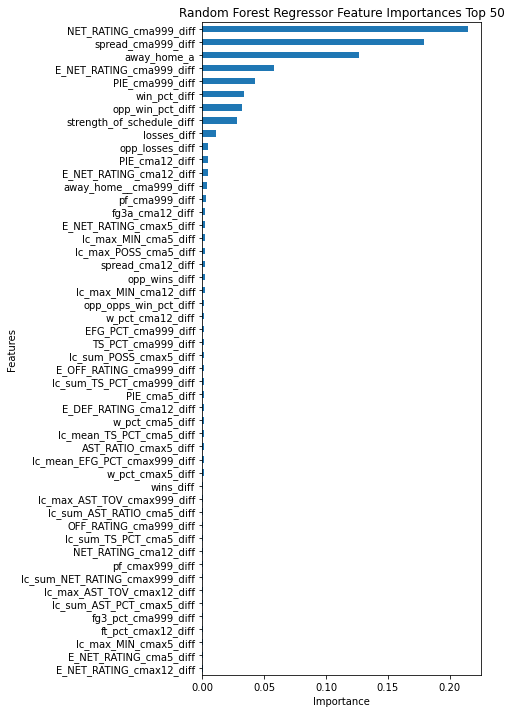

time: 331 ms (started: 2022-08-29 22:33:44 -07:00)


In [108]:
#plot top 50 features of model 161 trial 1
plt.subplots(figsize=(5, 12))

feature_importances = random_forest_161_trial_1.named_steps.randomforestregressor.feature_importances_
series_random_forest_feature_importances_161_trial_1 = pd.Series(feature_importances, 
                                                                 index=random_forest_161_trial_1.X_columns).sort_values(ascending=False)
series_random_forest_feature_importances_161_trial_1[0:50].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importances Top 50');


In [109]:
#get top 50 feature name list of model 161 trial 1
column_name_list_161_trial_1_top_50_features = series_random_forest_feature_importances_161_trial_1.index.to_list()[0:50]
pl(column_name_list_161_trial_1_top_50_features)

50


['NET_RATING_cma999_diff',
 'spread_cma999_diff',
 'away_home_a',
 'E_NET_RATING_cma999_diff',
 'PIE_cma999_diff',
 'win_pct_diff',
 'opp_win_pct_diff',
 'strength_of_schedule_diff',
 'losses_diff',
 'opp_losses_diff',
 'PIE_cma12_diff',
 'E_NET_RATING_cma12_diff',
 'away_home__cma999_diff',
 'pf_cma999_diff',
 'fg3a_cma12_diff',
 'E_NET_RATING_cmax5_diff',
 'lc_max_MIN_cma5_diff',
 'lc_max_POSS_cma5_diff',
 'spread_cma12_diff',
 'opp_wins_diff',
 'lc_max_MIN_cma12_diff',
 'opp_opps_win_pct_diff',
 'w_pct_cma12_diff',
 'EFG_PCT_cma999_diff',
 'TS_PCT_cma999_diff',
 'lc_sum_POSS_cmax5_diff',
 'E_OFF_RATING_cma999_diff',
 'lc_sum_TS_PCT_cma999_diff',
 'PIE_cma5_diff',
 'E_DEF_RATING_cma12_diff',
 'w_pct_cma5_diff',
 'lc_mean_TS_PCT_cma5_diff',
 'AST_RATIO_cmax5_diff',
 'lc_mean_EFG_PCT_cmax999_diff',
 'w_pct_cmax5_diff',
 'wins_diff',
 'lc_max_AST_TOV_cmax999_diff',
 'lc_sum_AST_RATIO_cma5_diff',
 'OFF_RATING_cma999_diff',
 'lc_sum_TS_PCT_cma5_diff',
 'NET_RATING_cma12_diff',
 'pf_cmax99

time: 1.87 ms (started: 2022-08-29 22:33:44 -07:00)


<font size="4">Get trained Random Forest Regressor Time Series Cross Validation Dictionary with the best hyperparameters 200 Estimators, 5 Max Depth, and 50 Minimum Sample Splits. Save it.</font>

In [110]:
#read in existing Time Series Cross Validation 8 Splits Random Forest Regresssor Models or build them

model_readback = nsp.return_saved_model_if_it_exists(filename='161_random_forest_tscv8_train_trial_2.sav')

if model_readback != None:
    random_forest_time_series_cross_validation_8_splits_train_results_collection = model_readback

else:
        
    random_forest_time_series_cross_validation_8_splits_train_results_collection = \
    get_random_forest_regressor_time_series_cross_validation_results_collection(X_time_series_cross_validation_index_8_train,
                                                                                Y_time_series_cross_validation_index_8_train)
    
    random_forest_time_series_cross_validation_8_splits_train_results_collection = nsp.save_and_return_model(
        model=random_forest_time_series_cross_validation_8_splits_train_results_collection,
        filename='161_random_forest_tscv8_train_trial_2.sav')

random_forest_time_series_cross_validation_8_splits_train_results_collection

This file already exists


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'fit_time': array([  333.2900517 ,  1063.99890018,  2164.2703166 ,  3634.84298921,
         5444.0802021 ,  8018.92087007, 10412.06105042, 13614.50689387]),
 'score_time': array([0.02692914, 0.02692771, 0.03091788, 0.02792668, 0.0289228 ,
        0.02792287, 0.0289228 , 0.02792764]),
 'estimator': [RandomForestRegressor(criterion='mae', max_depth=5, max_features='auto',
                        min_samples_split=50, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae', max_depth=5, max_features='auto',
                        min_samples_split=50, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae', max_depth=5, max_features='auto',
                        min_samples_split=50, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae', max_depth=5, max_features='auto',
                        min_samples_split=50, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae', max_depth=5, max_features='auto'

time: 120 ms (started: 2022-08-29 22:33:44 -07:00)


<font size="4">Get Predictions of Random Forest Regressor Time Series Cross Validation Dictionary with the best hyperparameters 200 Estimators, 5 Max Depth, and 50 Minimum Sample Splits.</font>

In [111]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='161_time_series_cross_validation_8_splits_validation_score_difference_a_predictions_trial_2.csv.gz')

if df_readback.empty == False:
    df_time_series_cross_validation_8_splits_score_difference_a_predicted = df_readback

else:
    #get 161_time_series_cross_validation_8_splits_validation_score_difference_a_predictions_trial_2
    df_time_series_cross_validation_8_splits_score_difference_a_predicted = nsp.get_df_time_series_cross_validation_8_splits_score_difference_a_predicted(
        df_time_series_cross_validation_index_8_train,
        X_time_series_cross_validation_index_8_train,
        random_forest_time_series_cross_validation_8_splits_train_results_collection)

    #save it
    df_time_series_cross_validation_8_splits_score_difference_a_predicted = save_and_return_data_frame(
        df=df_time_series_cross_validation_8_splits_score_difference_a_predicted, 
        filename='161_time_series_cross_validation_8_splits_validation_score_difference_a_predictions_trial_2.csv.gz',
        index=False,
        parse_dates=False)


#get 161 time series cross validation index 8 score difference actual
df_score_difference_a_actual = nsp.get_df_score_difference_a_actual(df_time_series_cross_validation_index_8_train)


from sklearn.metrics import mean_absolute_error

print('MAE: ' + str(mean_absolute_error(y_true=df_score_difference_a_actual,
                                        y_pred=df_time_series_cross_validation_8_splits_score_difference_a_predicted)))

print('MAPE: ' + str(nsp.MAPE(Y_actual=df_score_difference_a_actual.values, 
                              Y_Predicted=df_time_series_cross_validation_8_splits_score_difference_a_predicted.values)))

This file already exists
MAE: 9.78375730994152
MAPE: 112.80567790602649
time: 7.75 ms (started: 2022-08-29 22:33:45 -07:00)


<font size="4">Get Mean Absolute Error and Mean Absolute Percentage Error for last three folds of Random Forest Regressor Time Series Cross Validation Dictionary with the best hyperparameters 200 Estimators, 5 Max Depth, and 50 Minimum Sample Splits.</font>

In [112]:
#get score diffference actual of last 3 train indices
df_score_difference_a_actual_folds678 = nsp.get_particular_folds_of_10_folds(df=df_score_difference_a_actual,
                                                                             df_number_folds=8,
                                                                             get_fold_indices=[6,7,8])

#get score difference predicteed of last 3 train indices 6,7,8
df_score_difference_a_predicted_folds678 = nsp.get_particular_folds_of_10_folds(df=df_time_series_cross_validation_8_splits_score_difference_a_predicted,
                                                                                df_number_folds=8,
                                                                                get_fold_indices=[6,7,8])

print('times series cross validation metrics on fold 6, 7, 8:')

print('MAE: ' + str(mean_absolute_error(y_true=df_score_difference_a_actual_folds678, y_pred=df_score_difference_a_predicted_folds678)))

print('MAPE: ' + str(nsp.MAPE(Y_actual=df_score_difference_a_actual_folds678.values, Y_Predicted=df_score_difference_a_predicted_folds678.values)))

p(df_score_difference_a_predicted_folds678)


times series cross validation metrics on fold 6, 7, 8:
MAE: 10.047961338531515
MAPE: 113.83831832952458
(3078, 1)


score_difference_a_predicted
5130                        7.0875
5131                       -0.1950
5132                        4.8100
5133                       -5.3075
5134                       -2.5300
8203                       -8.5300
8204                        6.4000
8205                       -9.2325
8206                        5.6475
8207                       -3.6000

time: 9.41 ms (started: 2022-08-29 22:33:45 -07:00)


<font size="4"> Get Best Random Forest Regresssor trial 2 from 5-fold Grid Search Cross Validation. </font>

In [113]:
#read in existing Best Cross Validated Random Forest Regressor Model or build it
model_readback = nsp.return_saved_model_if_it_exists(filename='172_model_training_trial_2.pkl')

if model_readback != None:
    model_172_training_trial_2 = model_readback

else:
    X_train_172 = data_frame_collection_train_test_172['train'].drop(columns = 'spread_a')

    y_train_172 = data_frame_collection_train_test_172['train'].loc[:, ['spread_a']]

    
    model_172_training_trial_2 = nsp.get_best_random_forest_model_172(X_train_172, y_train_172)

    model_172_training_trial_2 =  nsp.save_and_return_model(model=model_172_training_trial_2, filename='172_model_training_trial_2.pkl')

model_172_training_trial_2

This file already exists


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your ow

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(criterion='mae', max_depth=5,
                                       max_features='auto',
                                       min_samples_split=100, n_estimators=200,
                                       random_state=47))])

time: 11.9 ms (started: 2022-08-29 22:33:45 -07:00)


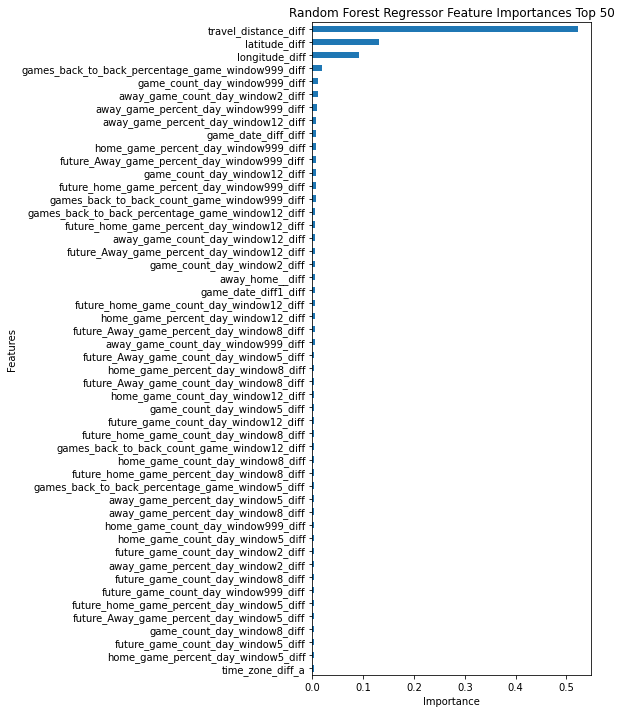

time: 420 ms (started: 2022-08-29 22:33:45 -07:00)


In [114]:
#get column name list
column_name_list_172_trial_2 = nsp.get_column_name_list_172_trial_2(list_1_2=2)

#plot feature importances
plt.subplots(figsize=(5, 12))
feature_importances = model_172_training_trial_2.named_steps.randomforestregressor.feature_importances_
series_random_forest_feature_importances_172_trial_2 = pd.Series(feature_importances, index=column_name_list_172_trial_2).sort_values(ascending=False)

series_random_forest_feature_importances_172_trial_2[0:50].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importances Top 50');


In [115]:
df_172_trial_4_indicator_variables_collection_train_test = {}

#add the indicator columns of 172 to the numeric columns of 172 trial 2 train
df_172_trial_4_indicator_variables_collection_train_test['train'] = \
pd.concat([data_frame_collection_train_test_172['train'], 
           data_frame_collection_train_test_172_indicator_variables['train']],
          axis=1)


#add the indicator columns of 172 to the numeric columns of 172 trial 2 test
df_172_trial_4_indicator_variables_collection_train_test['test'] = \
pd.concat([data_frame_collection_train_test_172['test'], 
           data_frame_collection_train_test_172_indicator_variables['test']],
          axis=1)

p(df_172_trial_4_indicator_variables_collection_train_test['train'])

(9239, 227)


game_date_diff_diff  travel_distance_diff  \
0               -0.016167             -1.045651   
1               -0.016167              0.835098   
2               -0.016167              1.138787   
3               -6.722156              0.455969   
4               -0.016167              0.393053   
9234            -0.016167              0.668731   
9235             1.660330             -1.178721   
9236             1.660330             -0.159232   
9237            -0.016167             -1.592077   
9238            -0.016167              1.028375   

      away_game_percent_day_window2_diff  home_game_percent_day_window2_diff  \
0                              -1.098300                            1.098300   
1                               1.095736                           -1.095736   
2                               1.095736                           -1.095736   
3                               0.547227                           -0.547227   
4                               1.095736                           -1.095736   
9234                            0.547227                           -0.547227   
9235                           -1.098300                            1.098300   
9236                           -0.549791                            0.549791   
9237                           -1.098300                            1.098300   
9238                            1.095736                           -1.095736   

      away_game_percent_day_window5_diff  home_game_percent_day_window5_diff  \
0                              -1.860644                            1.860644   
1                               1.841889                           -1.841889   
2                               1.841889                           -1.841889   
3                               0.916256                           -0.916256   
4                               1.841889                           -1.841889   
9234                            1.224801                           -1.224801   
9235                           -1.243555                            1.243555   
9236                            0.299167                           -0.299167   
9237                           -0.626466                            0.626466   
9238                            1.841889                           -1.841889   

      away_game_percent_day_window8_diff  home_game_percent_day_window8_diff  \
0                              -2.477298                            2.477298   
1                               2.447929                           -2.447929   
2                               2.447929                           -2.447929   
3                               1.216622                           -1.216622   
4                               2.447929                           -2.447929   
9234                            0.724099                           -0.724099   
9235                           -0.425120                            0.425120   
9236                           -0.630338                            0.630338   
9237                            0.231577                           -0.231577   
9238                            0.600969                           -0.600969   

      away_game_percent_day_window12_diff  \
0                               -3.197979   
1                                3.178224   
2                                3.178224   
3                                1.584173   
4                                3.178224   
9234                             0.673287   
9235                            -0.328688   
9236                            -1.072578   
9237                             0.521473   
9238                            -0.222418   

      home_game_percent_day_window12_diff  \
0                                3.197979   
1                               -3.178224   
2                               -3.178224   
3                               -1.584173   
4                               -3.178224   
9234                            -0.

time: 85.1 ms (started: 2022-08-29 22:33:45 -07:00)


In [116]:
#get column name list 172 trial 2 top 50 feature importances
column_name_list_172_trial_2_top_50 = series_random_forest_feature_importances_172_trial_2[0:50].index.to_list()

#get column name list 172 trial 4 indicator variables
column_name_list_172_trial_4_indicator_variables = data_frame_collection_train_test_172_indicator_variables['train'].columns.to_list()

#get column name list 172 trial 2 top 50 features and 172 trial 4 indicator variables
column_name_list_172_trial_4 = column_name_list_172_trial_2_top_50 + column_name_list_172_trial_4_indicator_variables



#get column name list 172 trial 4 ordered
column_name_list_172_trial_4_ordered = \
nsp.get_column_name_list_172_trial_4_ordered()



#reorder data frame columns hyperparameter tuning and modeling
df_172_trial_4_indicator_variables_collection_train_test['train'] = \
df_172_trial_4_indicator_variables_collection_train_test['train'].loc[:, column_name_list_172_trial_4].loc[:, column_name_list_172_trial_4_ordered]

df_172_trial_4_indicator_variables_collection_train_test['test'] = \
df_172_trial_4_indicator_variables_collection_train_test['test'].loc[:, column_name_list_172_trial_4].loc[:, column_name_list_172_trial_4_ordered]

p(df_172_trial_4_indicator_variables_collection_train_test['train'])

(9239, 206)


travel_distance_diff  latitude_diff  longitude_diff  \
0                -1.045651       2.249668        0.309113   
1                 0.835098      -1.609477        0.382961   
2                 1.138787      -0.562022        1.000900   
3                 0.455969       0.131678        0.384628   
4                 0.393053       0.218117       -0.601191   
9234              0.668731       0.364861        0.609385   
9235             -1.178721      -1.458896       -1.226033   
9236             -0.159232      -0.346791       -0.114403   
9237             -1.592077       1.077557       -1.772348   
9238              1.028375       0.322876        1.055734   

      games_back_to_back_percentage_game_window999_diff  \
0                                             -0.019209   
1                                             -0.019209   
2                                             -0.019209   
3                                             -0.019209   
4                                             -0.019209   
9234                                          -1.954942   
9235                                           0.639911   
9236                                           1.125579   
9237                                           1.229651   
9238                                          -0.423252   

      game_count_day_window999_diff  away_game_count_day_window2_diff  \
0                          0.010356                         -0.873972   
1                          0.010356                          0.876529   
2                          0.010356                          0.876529   
3                          0.687540                          0.876529   
4                          0.010356                          0.876529   
9234                       0.687540                          0.876529   
9235                       0.010356                         -1.749222   
9236                       0.687540                         -0.873972   
9237                       0.010356                         -1.749222   
9238                      -1.344011                          0.876529   

      away_game_percent_day_window999_diff  \
0                                -6.465582   
1                                 6.416819   
2                                 6.416819   
3                                 3.196219   
4                                 6.416819   
9234                              0.113645   
9235                              0.992650   
9236                             -0.838007   
9237                             -0.346441   
9238                              0.619739   

      away_game_percent_day_window12_diff  game_date_diff_diff  \
0                               -3.197979            -0.016167   
1                                3.178224            -0.016167   
2                                3.178224            -0.016167   
3                                1.584173            -6.722156   
4                                3.178224            -0.016167   
9234                             0.673287            -0.016167   
9235                            -0.328688             1.660330   
9236                            -1.072578             1.660330   
9237                             0.521473            -0.016167   
9238                            -0.222418            -0.016167   

      home_game_percent_day_window999_diff  \
0                                 6.465582   
1                                -6.416819   
2                                -6.416819   
3                                -3.196219   
4                                -6.416819   
9234                             -0.113645   
9235                             -0.992650   
9236                              0.838007   
9237                              0.346441   
9238                             -0.619739   

      future_Away_game_percent_day_window999_diff  \
0                                        0.009482   
1                                

time: 66 ms (started: 2022-08-29 22:33:45 -07:00)


<font size="4"> Get Best Random Forest Regresssor trial 4 from 5-fold Grid Search Cross Validation. </font>

In [117]:
model_readback = nsp.return_saved_model_if_it_exists(filename='172_model_training_trial_4.pkl')

if model_readback != None:
    model_172_training_trial_4 = model_readback

else:

    X_train_172_trial_4 = df_172_trial_4_indicator_variables_collection_train_test['train']

    y_train_172_trial_4 = data_frame_collection_train_test_172['train'].loc[:, ['spread_a']]

    
    model_172_training_trial_4 = nsp.get_best_random_forest_model_172(X_train_172_trial_4, y_train_172_trial_4)

    model_172_training_trial_4 = nsp.save_and_return_model(model=model_172_training_trial_4, filename='172_model_training_trial_4.pkl')

model_172_training_trial_4

This file already exists


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.22 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your ow

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(criterion='mae', max_depth=20,
                                       max_features='auto',
                                       min_samples_split=100, n_estimators=200,
                                       random_state=47))])

time: 13.8 ms (started: 2022-08-29 22:33:45 -07:00)


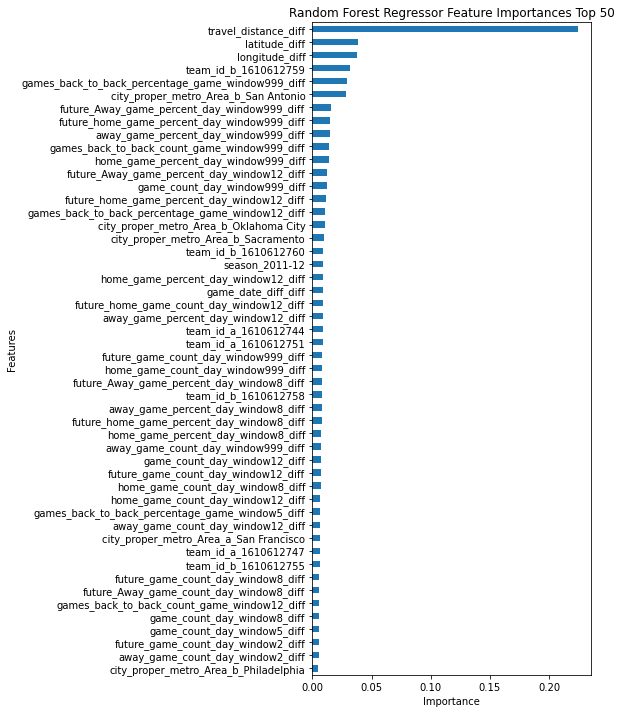

time: 406 ms (started: 2022-08-29 22:33:45 -07:00)


In [118]:
#get column name list
column_name_list_172_trial_4 = df_172_trial_4_indicator_variables_collection_train_test['train'].columns.to_list()

#plot feature importances
plt.subplots(figsize=(5, 12))
feature_importances = model_172_training_trial_4.named_steps.randomforestregressor.feature_importances_
series_random_forest_feature_importances_172_trial_4 = pd.Series(feature_importances, index=column_name_list_172_trial_4).sort_values(ascending=False)

series_random_forest_feature_importances_172_trial_4[0:50].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importances Top 50');


In [119]:
df_score_difference_a_actual = data_frame_collection_train_test_172['train'].loc[:, ['spread_a']]

y_predicted_array_172_trial_4 = model_172_training_trial_4.predict(df_172_trial_4_indicator_variables_collection_train_test['train'])

df_spread_a_predicted_172_trial_4 = pd.DataFrame(y_predicted_array_172_trial_4, columns=['spread_a_predicted'])


from termcolor import colored

cross_validation_5_fold_mae_std = (10.505492307931195, 0.28158225165703904)


print(colored('Warning: data leakage', 'red'))

print('5-fold cross validation train dataset MAE and STD: ' + str(cross_validation_5_fold_mae_std))

5-fold cross validation train dataset MAE and STD: (10.505492307931195, 0.28158225165703904)
time: 136 ms (started: 2022-08-29 22:33:46 -07:00)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


This file already exists


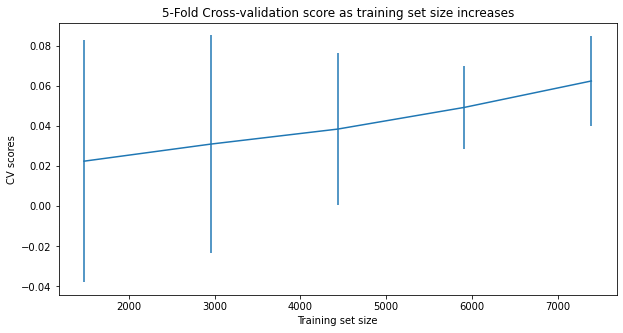

time: 76.5 ms (started: 2022-08-29 22:33:46 -07:00)


In [120]:
df_readback = nsp.return_processed_collection_if_it_exists(filename='172_trial_4_learning_curve_collection_train_test_scores_mean_std.pkl',
                                                           parse_dates=False)

if df_readback != None:
    learning_curve_collection_train_test_scores_mean_std = df_readback

else:
    from sklearn.model_selection import learning_curve
    fractions = [.2, .4, .6, .8, 1.0]
    train_size, train_scores, test_scores = learning_curve(estimator=model_172_training_trial_4, 
                                                           X=df_172_trial_4_indicator_variables_collection_train_test['train'], 
                                                           y=df_score_difference_a_actual, 
                                                           train_sizes=fractions)

    learning_curve_collection_train_test_scores_mean_std = {}

    learning_curve_collection_train_test_scores_mean_std['train_size'] = train_size
    learning_curve_collection_train_test_scores_mean_std['train_scores'] = train_scores
    learning_curve_collection_train_test_scores_mean_std['test_scores'] = test_scores


    learning_curve_collection_train_test_scores_mean_std['train_scores_mean'] = np.mean(train_scores, axis=1)
    learning_curve_collection_train_test_scores_mean_std['train_scores_std'] = np.std(train_scores, axis=1)
    learning_curve_collection_train_test_scores_mean_std['test_scores_mean'] = np.mean(test_scores, axis=1)
    learning_curve_collection_train_test_scores_mean_std['test_scores_std'] = np.std(test_scores, axis=1)


    #save it
    learning_curve_collection_train_test_scores_mean_std = nsp.save_and_return_collection(data_frame_collection=learning_curve_collection_train_test_scores_mean_std, 
                                                                                          filename='172_trial_4_learning_curve_collection_train_test_scores_mean_std.pkl',
                                                                                          index=False,
                                                                                          parse_dates=False)


print(colored('Warning: data leakage', 'red'))

#plot learning curve
plt.subplots(figsize=(10, 5))
plt.errorbar(learning_curve_collection_train_test_scores_mean_std['train_size'], 
             learning_curve_collection_train_test_scores_mean_std['test_scores_mean'], 
             yerr=learning_curve_collection_train_test_scores_mean_std['test_scores_std'])

plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('5-Fold Cross-validation score as training set size increases');

In [121]:
df_features_random_forest_time_series_cross_validation_9_splits = nsp.combine_drop_and_order_model_172_trial_4_model_161_trial_1_top_50_features(series_random_forest_feature_importances_172_trial_4,
                                                                                                                                                 df_172_trial_4_indicator_variables_collection_train_test,
                                                                                                                                                 df_time_series_cross_validation_index_8_train,
                                                                                                                                                 df_time_series_cross_validation_index_8_test,
                                                                                                                                                 column_name_list_161_trial_1_top_50_features)

p(df_features_random_forest_time_series_cross_validation_9_splits)

######<<<<<<<<<<<<<<<<<<<<<<<<<<<############<<<<<<<<<<<<< appears to be post duplicate feature drops

(10266, 88)


latitude_diff  longitude_diff  \
0           2.249668        0.309113   
1          -1.609477        0.382961   
2          -0.562022        1.000900   
3           0.131678        0.384628   
4           0.218117       -0.601191   
10261       1.106792       -1.506069   
10262       0.507344        1.893118   
10263       0.507344        1.893118   
10264       0.507344        1.893118   
10265       0.507344        1.893118   

       games_back_to_back_percentage_game_window999_diff  \
0                                              -0.019209   
1                                              -0.019209   
2                                              -0.019209   
3                                              -0.019209   
4                                              -0.019209   
10261                                          -0.019209   
10262                                          -0.154628   
10263                                          -0.153121   
10264                                          -0.151647   
10265                                          -0.150205   

       city_proper_metro_Area_b_San Antonio  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
10261                                     0   
10262                                     0   
10263                                     0   
10264                                     0   
10265                                     0   

       future_Away_game_percent_day_window999_diff  \
0                                         0.009482   
1                                         0.009482   
2                                         0.009482   
3                                         0.049461   
4                                         0.009482   
10261                                     0.009482   
10262                                     0.009482   
10263                                     0.009482   
10264                                     0.009482   
10265                                     0.009482   

       future_home_game_percent_day_window999_diff  \
0                                        -0.009482   
1                                        -0.009482   
2                                        -0.009482   
3                                        -0.049461   
4                                        -0.009482   
10261                                    -0.009482   
10262                                    -0.009482   
10263                                    -0.009482   
10264                                    -0.009482   
10265                                    -0.009482   

       away_game_percent_day_window999_diff  \
0                                 -6.465582   
1                                  6.416819   
2                                  6.416819   
3                                  3.196219   
4                                  6.416819   
10261                              0.040681   
10262                              0.071918   
10263                              0.134429   
10264                              0.070036   
10265                              0.006887   

       games_back_to_back_count_game_window999_diff  \
0                                         -0.054777   
1                                         -0.054777   
2                                         -0.054777   
3                                         -0.054777   
4                                         -0.054777   
10261                                     -0.054777   
10262                                     -0.523781   
10263                                     -0.523781   
10264                                     -0.523781   
10265                                     -0.523781   

       home_game_percent_day_window999_diff  \
0                         

time: 50.4 ms (started: 2022-08-29 22:33:46 -07:00)


In [122]:
p(df_score_difference_a_2010_2018)

(10266, 1)


spread_a
0            -8
1            14
2             2
3             8
4             3
10261        -9
10262        10
10263        19
10264         8
10265        23

time: 3.68 ms (started: 2022-08-29 22:33:46 -07:00)


<font size="4"> Get Best Random Forest Hyperparameters for Final Random Forest Regressor.</font>

In [123]:
#model 182 hyperparameter tuning
run_hyperparameter_tuning_model_train_yes_no = 'no'

if run_hyperparameter_tuning_model_train_yes_no == 'no':
    random_forest_regressor_time_series_cross_validation_index_6_7_8_hyperparameter_scores_list = [[5, 200, 5, 50, 0.2248209273681806], [5, 200, 5, 100, 0.22399532733071137], [5, 200, 10, 50, 0.22738334355737655], [5, 200, 10, 100, 0.22637222918869515], [5, 200, 20, 50, 0.22245283693712992], [5, 200, 20, 100, 0.2248492782845407], [6, 200, 5, 50, 0.15052371935119624], [6, 200, 5, 100, 0.15003473656334454], [6, 200, 10, 50, 0.15327869840629127], [6, 200, 10, 100, 0.15494341357606412], [6, 200, 20, 50, 0.15439428028798385], [6, 200, 20, 100, 0.15459882384635804], [7, 200, 5, 50, 0.17219759418933622], [7, 200, 5, 100, 0.1720775177241738], [7, 200, 10, 50, 0.17659412021163945], [7, 200, 10, 100, 0.17637144334620614], [7, 200, 20, 50, 0.17877359562770867], [7, 200, 20, 100, 0.17399193035052574]]
    df_random_forest_regressor_time_series_cross_validation_index_6_7_8_hyperparameter_scores = pd.DataFrame(random_forest_regressor_time_series_cross_validation_index_6_7_8_hyperparameter_scores_list, 
                                                                                                             columns = ['index', 'n_estimators', 'max_depth', 'min_samples_split', 'score'])

    df_random_forest_regressor_time_series_cross_validation_index_6_7_8_hyperparameter_mean_scores = df_random_forest_regressor_time_series_cross_validation_index_6_7_8_hyperparameter_scores.groupby(['n_estimators', 'max_depth', 'min_samples_split'])['score'].mean().reset_index().sort_values('score', ascending=False)
    
    print('best hyperparameters:')
    print(df_random_forest_regressor_time_series_cross_validation_index_6_7_8_hyperparameter_mean_scores.head(1))


else:

    grid_params = {'randomforestregressor__n_estimators': [200], 'randomforestregressor__max_depth': [5, 10, 20], 'randomforestregressor__min_samples_split': [50, 100]}

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import TimeSeriesSplit
    time_series_cross_validation_8_splits = TimeSeriesSplit(n_splits=8)
    i = 0
    score = []
    for train_index, validation_index in time_series_cross_validation_8_splits.split(df_features_random_forest_time_series_cross_validation_9_splits):

        if (len(train_index) > 6159) & (len(train_index) < 9200):
            print(train_index)
            print(validation_index)
            print()

            X_train, X_validation = df_features_random_forest_time_series_cross_validation_9_splits.iloc[train_index], df_features_random_forest_time_series_cross_validation_9_splits.iloc[validation_index]
            y_train, y_validation = df_score_difference_a_2010_2018.iloc[train_index], df_score_difference_a_2010_2018.iloc[validation_index]
            for n_estimators in grid_params['randomforestregressor__n_estimators']:
                for max_depth in grid_params['randomforestregressor__max_depth']:
                    for min_samples_split in grid_params['randomforestregressor__min_samples_split']:
                        print(n_estimators)
                        print(max_depth)
                        print(min_samples_split)
                        print()
                        rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                                    max_depth=int(max_depth),
                                                    min_samples_split=int(min_samples_split),
                                                    random_state=47,
                                                    criterion = 'mae',
                                                    n_jobs=-1)
                        rfr.fit(X_train, y_train)
                        
                        score.append([i, 
                                      n_estimators,
                                      max_depth, 
                                      min_samples_split, 
                                      rfr.score(X_validation, y_validation)])
                        #score column should be MAE or MAPE not R^2 here...##############<<<<<<<<<<<<<<<<<<<##################<<<<<<<<<<<<<<<<##############<<<<<<<<<<<< future work
                        
                        print(score)
        else:
            print('skipped')
        i += 1

best hyperparameters:
   n_estimators  max_depth  min_samples_split     score
3           200         10                100  0.185896
time: 7.48 ms (started: 2022-08-29 22:33:46 -07:00)


<font size="4"> Get Random Forest Regressor Time Series Cross Validation 9 Splits Collection. </font>

In [124]:
#get random forest regressor time series cross validation 9 splits model 180
model_readback = nsp.return_saved_model_if_it_exists(filename='180_random_forest_time_series_cross_validation_9_splits_collection_trial_6.sav')

if model_readback != None:
    model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6 = model_readback
    
else:
    model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6 = \
    nsp.get_trained_random_forst_regressor_180_trial_6_time_series_cross_validation_9_splits_collection(df_features_random_forest_time_series_cross_validation_9_splits,
                                                                                                        df_score_difference_a_2010_2018)

    model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6 = \
    nsp.save_and_return_model(model=model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6,
                              filename='180_random_forest_time_series_cross_validation_9_splits_collection_trial_6.sav')

model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6

This file already exists


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'fit_time': array([  41.66545486,  146.08313107,  285.96661496,  476.68947101,
         721.65902495, 1606.63245511, 2377.09093595, 1855.43667984,
        2418.8753171 ]),
 'score_time': array([0.01562405, 0.01683998, 0.01818824, 0.01878715, 0.02444005,
        0.02399397, 0.02382207, 0.02606797, 0.02573895]),
 'estimator': [RandomForestRegressor(criterion='mae', max_depth=10, max_features='auto',
                        min_samples_split=100, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae', max_depth=10, max_features='auto',
                        min_samples_split=100, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae', max_depth=10, max_features='auto',
                        min_samples_split=100, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae', max_depth=10, max_features='auto',
                        min_samples_split=100, n_estimators=200, random_state=47),
  RandomForestRegressor(criterion='mae

time: 44.6 ms (started: 2022-08-29 22:33:46 -07:00)


In [125]:
#get data frame score difference a predicted
df_readback = nsp.return_processed_data_file_if_it_exists(filename='180_random_forest_time_series_cross_validation_9_splits_folds_123456789_spread_a_predictions_trial_6.csv')

if df_readback.empty == False:
    df_time_series_cross_validation_9_splits_score_difference_a_predicted = df_readback

else:
    df_time_series_cross_validation_9_splits_score_difference_a_predicted = \
    nsp.get_score_difference_a_predicted(df_features_random_forest_time_series_cross_validation_9_splits,
                                         model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6)
    
    #save it
    df_time_series_cross_validation_9_splits_score_difference_a_predicted = \
    save_and_return_data_frame(
        df=df_time_series_cross_validation_9_splits_score_difference_a_predicted, 
        filename='180_random_forest_time_series_cross_validation_9_splits_folds_123456789_spread_a_predictions_trial_6.csv',
        index=False,
        parse_dates=False)

p(df_time_series_cross_validation_9_splits_score_difference_a_predicted)

This file already exists
(9234, 1)


spread_a_predicted
0                 3.0625
1                -5.0575
2                -5.6225
3                 2.2500
4                -2.5550
9229              0.7250
9230              7.9675
9231              8.5075
9232              3.0525
9233              3.3250

time: 6.24 ms (started: 2022-08-29 22:33:46 -07:00)


In [126]:
######<<<<<<<<<#########<<<<<<<<<<< get top feature importances plot of random forest ????

model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6['estimator'][7]

RandomForestRegressor(criterion='mae', max_depth=10, max_features='auto',
                      min_samples_split=100, n_estimators=200, random_state=47)

time: 2.21 ms (started: 2022-08-29 22:33:46 -07:00)


<font size="4"> Get feature and target train folds 0 thru 7 and validation fold 8.</font>

In [127]:
#get time series split of folds 1 thru 7

from sklearn.model_selection import TimeSeriesSplit

time_series_cross_validation_9_splits = TimeSeriesSplit(n_splits=9)

df = pd.DataFrame({})
for i, (j, k) in enumerate(time_series_cross_validation_9_splits.split(df_score_difference_a_2010_2018)):
    if i == 7:
        
        df_features_train_folds_01234567 = pd.concat([df, df_features_random_forest_time_series_cross_validation_9_splits.iloc[j]])
        df_features_test_fold_8 = pd.concat([df, df_features_random_forest_time_series_cross_validation_9_splits.iloc[k]])
        
        df_spread_a_train_folds_01234567 = pd.concat([df, df_score_difference_a_2010_2018.iloc[j]])
        df_spread_a_test_fold_8 = pd.concat([df, df_score_difference_a_2010_2018.iloc[k]])
    
    if i == 8:
        df_features_train_folds_012345678 = pd.concat([df, df_features_random_forest_time_series_cross_validation_9_splits.iloc[j]])
        df_features_test_fold_9 = pd.concat([df, df_features_random_forest_time_series_cross_validation_9_splits.iloc[k]])

        df_spread_a_train_folds_012345678 = pd.concat([df, df_score_difference_a_2010_2018.iloc[j]])
        df_spread_a_test_fold_9 = pd.concat([df, df_score_difference_a_2010_2018.iloc[k]])
        
        
        

time: 8.5 ms (started: 2022-08-29 22:33:46 -07:00)


<font size="4"> Get MAE and MAPE for Random Forest Regressor model trained on folds 0 thru 7 and predicting fold 8.</font>

In [128]:
#get random forest time series cross validation metrics for folds 1 thru 7 on fold 8

random_forest_regressor_fold_8_spread_a_predicted = model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6['estimator'][7].predict(df_features_test_fold_8)

random_forest_regressor_mae = mean_absolute_error(df_spread_a_test_fold_8.to_numpy(), random_forest_regressor_fold_8_spread_a_predicted)

random_forest_regressor_mape = nsp.MAPE(df_spread_a_test_fold_8.to_numpy(), random_forest_regressor_fold_8_spread_a_predicted)

print('MAE: ' + str(random_forest_regressor_mae) + '\n' + 'MAPE: ' +str(random_forest_regressor_mape))

MAE: 10.41463693957115
MAPE: 135.57042884958003
time: 27.2 ms (started: 2022-08-29 22:33:46 -07:00)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


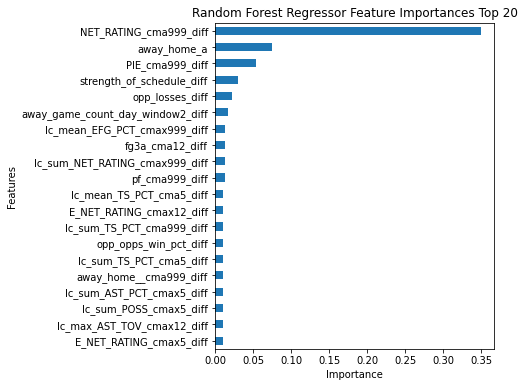

time: 818 ms (started: 2022-08-29 22:33:46 -07:00)


In [129]:
#get column name list
column_name_list_random_forest_regressor_180_trial_6 = df_features_random_forest_time_series_cross_validation_9_splits.columns.to_list()

#plot feature importances
plt.subplots(figsize=(5, 6))
feature_importances = model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6['estimator'][8].feature_importances_
series_random_forest_feature_importances_180_trial_6 = pd.Series(feature_importances, index=column_name_list_random_forest_regressor_180_trial_6).sort_values(ascending=False)

column_name_list_random_forest_regressor_180_trial_6_top_20 = series_random_forest_feature_importances_180_trial_6[0:20].index.to_list()
column_name_list_random_forest_regressor_180_trial_6_top_10 = series_random_forest_feature_importances_180_trial_6[0:10].index.to_list()

series_random_forest_feature_importances_180_trial_6[0:20].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importances Top 20');

#save it
plt.savefig('figure_random_forest_regressor_trial_6_estimator_index_8_top_20_feature_importances.png', bbox_inches='tight', dpi=600)


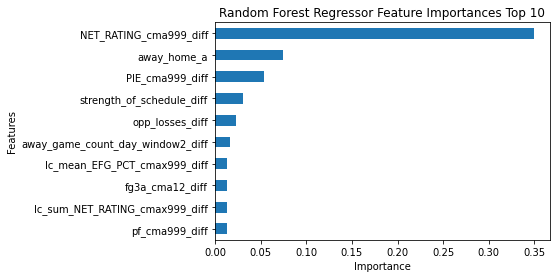

time: 556 ms (started: 2022-08-29 22:33:47 -07:00)


In [130]:
series_random_forest_feature_importances_180_trial_6[0:10].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importances Top 10');

#save it
plt.savefig('figure_random_forest_regressor_trial_6_estimator_index_8_top_10_feature_importances.png', bbox_inches='tight', dpi=600)


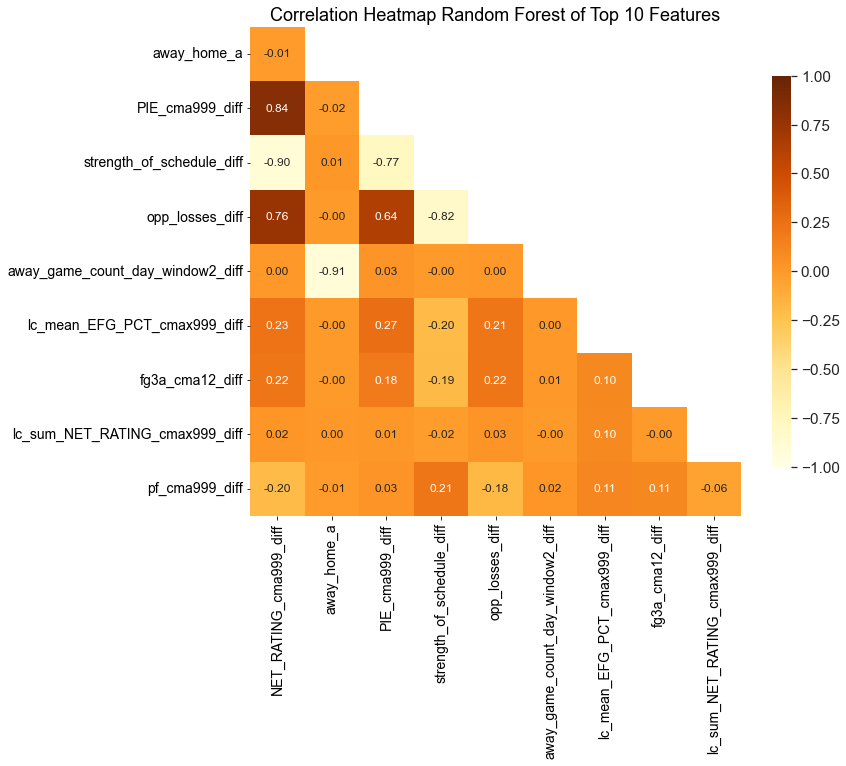

time: 2.35 s (started: 2022-08-29 22:33:47 -07:00)


In [131]:
df_corr = df_features_random_forest_time_series_cross_validation_9_splits.loc[:, column_name_list_random_forest_regressor_180_trial_6_top_10].corr()

fig, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(df_corr, dtype=bool))

mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)


plt.title('Correlation Heatmap Random Forest of Top 10 Features', fontsize=18)
plt.savefig('figure_correlation_heatmap_random_forest_regressor_trial_6_estimator_index_8_top_10.png', bbox_inches='tight', dpi=600)

plt.show()


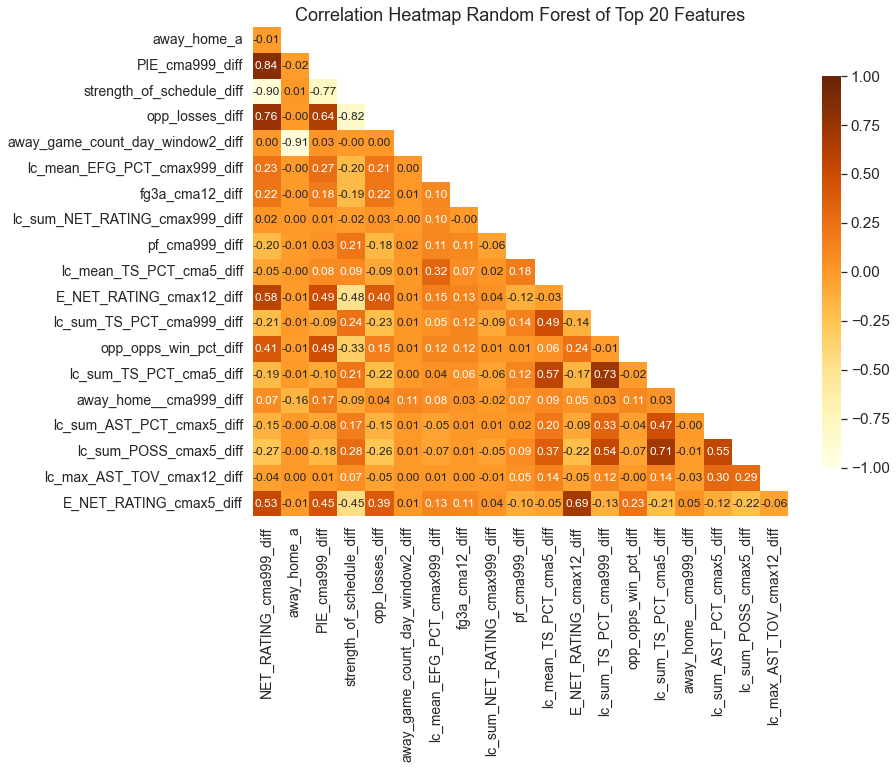

time: 3.25 s (started: 2022-08-29 22:33:50 -07:00)


In [132]:
df_corr = df_features_random_forest_time_series_cross_validation_9_splits.loc[:, column_name_list_random_forest_regressor_180_trial_6_top_20].corr()

fig, ax = plt.subplots(figsize=(12, 9))

mask = np.triu(np.ones_like(df_corr, dtype=bool))

mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)


plt.title('Correlation Heatmap Random Forest of Top 20 Features', fontsize=18)
plt.savefig('figure_correlation_heatmap_random_forest_regressor_trial_6_estimator_index_8_top_20.png', bbox_inches='tight', dpi=600)

plt.show()


In [133]:
# #get column name list
# column_name_list_random_forest_regressor_180_trial_6 = df_features_random_forest_time_series_cross_validation_9_splits.columns.to_list()

# #get feature importances
# plt.subplots(figsize=(5, 6))
# feature_importances = model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6['estimator'][8].feature_importances_
# series_random_forest_feature_importances_180_trial_6 = pd.Series(feature_importances, index=column_name_list_random_forest_regressor_180_trial_6).sort_values(ascending=False)

# column_name_list_random_forest_regressor_180_trial_6_top_20 = series_random_forest_feature_importances_180_trial_6[0:20].index.to_list()


# #create figure and set of subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# df_corr = df_features_random_forest_time_series_cross_validation_9_splits.loc[:, column_name_list_random_forest_regressor_180_trial_6_top_20].corr()

# #fig, ax = ax1.subplots(figsize=(12, 9))

# mask = np.triu(np.ones_like(df_corr, dtype=bool))

# mask = mask[1:, :-1]
# corr = df_corr.iloc[1:,:-1].copy()

# sns.set(font_scale=1.4)
# sns.set_style("white")

# res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 10}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8}, ax=ax1)

# ax1.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12, rotation=90)
# ax1.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12, rotation=0)

# ax1.set_title('Correlation Heatmap Random Forest of Top 20 Features')


# ###############################

# #plot feature importances
# ress = series_random_forest_feature_importances_180_trial_6[0:20].sort_values(ascending=True).plot(kind='barh', ax=ax2)
# #ax2.set_xticklabels(ress.get_xmajorticklabels(), fontsize = 12, rotation=90)
# ax2.set_yticklabels(ress.get_ymajorticklabels(), fontsize = 12, rotation=0)
# ax2.set_xlabel('Importance')
# ax2.set_ylabel('Features')
# ax2.set_title('Random Forest Regressor Feature Importances Top 20');

# plt.savefig('figure_correlation_heatmap_random_forest_regressor_trial_6_estimator_index_8_top_20_and_feature_importances_horizontal_bar_plot_top_20.png', bbox_inches='tight', dpi=600)

# fig.tight_layout()

# plt.show()

time: 682 µs (started: 2022-08-29 22:33:53 -07:00)


<font size="4"> Get Gradient Boosting Regressor model. </font>

In [134]:
model_readback = nsp.return_saved_model_if_it_exists(filename='172_gradient_boosting_model_folds_01234567_trial_1.pkl')


if model_readback != None:
    model_172_gradient_boosting_regressor_folds_01234567_trial_1 = model_readback
    
else:
    
    #build gradient boosting regressor
    gradient_boosting_regressor_grid_search_cross_validation = nsp.get_gradient_boosting_regressor_grid_search_cross_validation(X_train=df_features_train_folds_01234567,
                                                                                                                                y_train=df_spread_a_train_folds_01234567.loc[:, 'spread_a'],
                                                                                                                                X_test=df_features_test_fold_8,
                                                                                                                                y_test=df_spread_a_test_fold_8.loc[:, 'spread_a'])
    
    #save the best model
    from sklearn import __version__ as sklearn_version
    import datetime
    import pickle
    
    best_model = gradient_boosting_regressor_grid_search_cross_validation.best_estimator_
    best_model.version = '1.0'
    best_model.pandas_version = pd.__version__
    best_model.numpy_version = np.__version__
    best_model.sklearn_version = sklearn_version
    best_model.X_columns = [col for col in df_features_train_folds_01234567.columns]
    best_model.build_datetime = datetime.datetime.now()

    model_172_gradient_boosting_regressor_folds_01234567_trial_1 = nsp.save_and_return_model(best_model, '172_gradient_boosting_model_folds_01234567_trial_1.pkl')
    


gradient_boosting_regressor_fold_8_mae = mean_absolute_error(df_spread_a_test_fold_8.to_numpy(), model_172_gradient_boosting_regressor_folds_01234567_trial_1.predict(df_features_test_fold_8))

gradient_boosting_regressor_fold_8_mape = nsp.MAPE(df_spread_a_test_fold_8.to_numpy(), model_172_gradient_boosting_regressor_folds_01234567_trial_1.predict(df_features_test_fold_8))

print('MAE: ' + str(gradient_boosting_regressor_fold_8_mae) + '\n' + 'MAPE: ' + str(gradient_boosting_regressor_fold_8_mape))

model_172_gradient_boosting_regressor_folds_01234567_trial_1



This file already exists
MAE: 10.516428257105114
MAPE: 132.9508877960639


GradientBoostingRegressor(max_depth=1, random_state=1, subsample=0.5)

time: 16.7 ms (started: 2022-08-29 22:33:53 -07:00)


<font size="4"> Get the K-best Linear Regressor Grid Search Cross Validation. Then, get the K-best Linear Regressor. </font>

In [135]:
model_readback = nsp.return_saved_model_if_it_exists(filename='172_grid_search_cross_validation_5_folds_linear_regression_select_k_best_model_trial_1.pkl')

if model_readback != None:
    linear_regression_grid_search_cross_validation = model_readback
else:
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import GridSearchCV, learning_curve#, train_test_split, cross_validate,
    from sklearn import __version__ as sklearn_version
    import datetime

    pipe = make_pipeline(SelectKBest(score_func=f_regression), LinearRegression())

    k = [k+1 for k in range(len(df_features_train_folds_01234567.columns))]

    grid_params = {'selectkbest__k': k}

    #get grid search cross validation object
    linear_regression_grid_search_cross_validation = GridSearchCV(pipe, param_grid=grid_params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

    #fit data on grid search cross validation object
    linear_regression_grid_search_cross_validation.fit(df_features_train_folds_01234567, df_spread_a_train_folds_01234567.numpy())
    
    linear_regression_grid_search_cross_validation = nsp.save_and_return_model(model=linear_regression_grid_search_cross_validation, 
                                                                               filename='172_grid_search_cross_validation_5_folds_linear_regression_select_k_best_model_trial_1.pkl')


#get the K-best Linear Regressor
model_readback = nsp.return_saved_model_if_it_exists(filename='172_linear_regression_select_k_best_model_trial_1.pkl')

if model_readback != None:
    linear_regression_select_k_best_model_trial_1 = model_readback

else:

    
    #get best model and meta data
    best_model = linear_regression_grid_search_cross_validation.best_estimator_
    best_model.version = '1.0'
    best_model.pandas_version = pd.__version__
    best_model.numpy_version = np.__version__
    best_model.sklearn_version = sklearn_version
    best_model.X_columns = [col for col in df_features_train_folds_01234567.columns]
    best_model.build_datetime = datetime.datetime.now()

    linear_regression_select_k_best_model_trial_1 = nsp.save_and_return_model(model=best_model, filename='172_linear_regression_select_k_best_model_trial_1.pkl')

    
linear_regression_k_best_mae = mean_absolute_error(df_spread_a_test_fold_8, linear_regression_select_k_best_model_trial_1.predict(df_features_test_fold_8))

linear_regression_k_best_mape = nsp.MAPE(df_spread_a_test_fold_8, linear_regression_select_k_best_model_trial_1.predict(df_features_test_fold_8))[0]

print('MAE: ' + str(linear_regression_k_best_mae))
print('MAPE: '+ str(linear_regression_k_best_mape))
    
    
linear_regression_select_k_best_model_trial_1



This file already exists
This file already exists
MAE: 10.53377513051968
MAPE: 118.23004035444346


Pipeline(steps=[('selectkbest',
                 SelectKBest(k=76,
                             score_func=<function f_regression at 0x7fb7e90fac10>)),
                ('linearregression', LinearRegression())])

time: 20.2 ms (started: 2022-08-29 22:33:53 -07:00)


<font size="4"> Metric Comparison of the Random Forest Regressor, Gradient Boosting Regressor, and K-Best Linear Regressor. Then save it.</font>

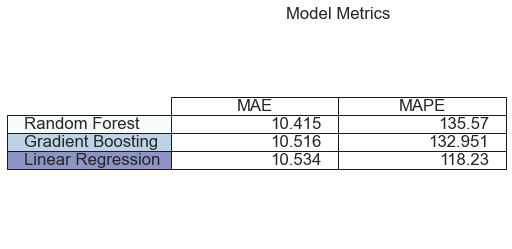

time: 417 ms (started: 2022-08-29 22:33:53 -07:00)


In [136]:
df_rf = pd.DataFrame({'Random Forest': [random_forest_regressor_mae, random_forest_regressor_mape]})
df_gb = pd.DataFrame({'Gradient Boosting': [gradient_boosting_regressor_fold_8_mae, gradient_boosting_regressor_fold_8_mape]})
df_lr = pd.DataFrame({'Linear Regression': [linear_regression_k_best_mae, linear_regression_k_best_mape]})

df_rf_list = list(np.round(df_rf.loc[:, 'Random Forest'].values, 3))
df_gb_list = list(np.round(df_gb.loc[:, 'Gradient Boosting'].values, 3))
df_lr_list = list(np.round(df_lr.loc[:, 'Linear Regression'].values, 3))


data = [df_rf_list,
        df_gb_list,
        df_lr_list]

columns = ('MAE', 'MAPE')

rows = [x for x in (list(df_rf.columns) + list(df_gb.columns) +  list(df_lr.columns))]



colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
the_table = plt.table(cellText = data,
                      rowLabels = rows,
                      rowColours = colors,
                      colLabels = columns,
                      loc='center')


plt.xticks([])

plt.box(on=None)
fig = plt.gcf()
the_table.scale(1, 1.5)


ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Model Metrics')

#save model metrics figure
plt.savefig('figure_random_forest_gradient_boosting_linear_regression_fold_8_mae_mape.png', bbox_inches='tight', dpi=600)

plt.show()




<font size="5"><a id='[Betting_Policy_Data_Wrangling_Feature_Engineering]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

<font size="6"><a id='[Betting_Policy_Data_Wrangling_Feature_Engineering]'>Betting Policy: Data Wrangling and Feature Engineering</a> </font>

<font size="4"> Get Random Forest Regressor Decision Tree Prediction Bootstrap Means. Then save it.</font>

In [137]:
if skip_decision_tree_bootstrap_means == False:
    #get random forest regressor decision tree prediction bootstrap means

    df_readback = \
    nsp.return_processed_data_file_if_it_exists(filename='181time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means_trial_6.csv')

    if df_readback.empty == False:
        df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means = df_readback

    else:
        df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means = \
        nsp.get_random_forest_regressor_time_series_cross_validation_9_splits_decision_tree_prediction_bootstrap_means(df_features_random_forest_time_series_cross_validation_9_splits,
                                                                                                                       model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6)

        #save it
        df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means = \
        save_and_return_data_frame(
            df=df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means, 
            filename='181time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means_trial_6.csv',
            index=False,
            parse_dates=False)

    p(df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means)

This file already exists
(9234, 10000)
time: 21.2 s (started: 2022-08-29 22:33:53 -07:00)


<font size="4"> Combine and Fix sign of Score Difference A, Random Forest Score Difference A Predicted, and Random Forest Decision Tree Score Difference A Prediction Bookstrap Means to align with the Sportbook Spread and Price where Sportsbook Spread1 = Home Score - Away Score. Then save it.</font>

In [138]:
if skip_decision_tree_bootstrap_means == False:
    df_readback = nsp.return_processed_data_file_if_it_exists(filename='32spread1_score_difference_score_difference_predicted_bootstrap_means_trial_6.csv')

    if df_readback.empty == False:
        df_spread1_score_difference_score_difference_predicted_bootstrap_means = df_readback

    else:

        df_time_series_cross_validation_9_splits_test_random_forest_decision_tree_score_difference_a_prediction_bootstrap_means = \
        nsp.add_score_difference_a_score_difference_a_predicted_game_id_game_date_team_id_a_team_id_b_away_home_a_to_bootstrap_means(df_time_series_cross_validation_9_splits_test_game_id_game_date_team_id_a_team_id_b_away_home_a_score_difference_a,
                                                                                                                                     df_time_series_cross_validation_9_splits_score_difference_a_predicted,
                                                                                                                                     df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means)

        df_spread1_score_difference_score_difference_predicted_bootstrap_means = \
        nsp.combine_score_difference_a_score_difference_a_predicted_bootstrap_means_with_sportsbook_spread_price(df_time_series_cross_validation_9_splits_test_sportsbook_spread_first,
                                                                                                                 df_time_series_cross_validation_9_splits_test_random_forest_decision_tree_score_difference_a_prediction_bootstrap_means,
                                                                                                                 df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means)

        #save it
        df_spread1_score_difference_score_difference_predicted_bootstrap_means = \
        save_and_return_data_frame(
            df=df_spread1_score_difference_score_difference_predicted_bootstrap_means, 
            filename='32spread1_score_difference_score_difference_predicted_bootstrap_means_trial_6.csv',
            index=False,
            parse_dates=False)

    mae_score_difference_and_spread1 = mean_absolute_error(df_spread1_score_difference_score_difference_predicted_bootstrap_means.loc[:, 'score_difference'], df_spread1_score_difference_score_difference_predicted_bootstrap_means.loc[:, 'spread1'])
    mae_score_difference_and_score_difference_predicted = mean_absolute_error(df_spread1_score_difference_score_difference_predicted_bootstrap_means.loc[:, 'score_difference'], df_spread1_score_difference_score_difference_predicted_bootstrap_means.loc[:, 'score_difference_predicted'])
    print('spread1 MAE: ' + str(mae_score_difference_and_spread1) + '\n' + 'score difference predicted MAE: ' + str(mae_score_difference_and_score_difference_predicted))


    p(df_spread1_score_difference_score_difference_predicted_bootstrap_means)

This file already exists
spread1 MAE: 9.29986642920748
score difference predicted MAE: 9.677761019590383
(8984, 10011)
time: 22.2 s (started: 2022-08-29 22:34:15 -07:00)


<font size="4"> Extract column for betting on Spread1 or Spread2 and column for Winning Bet. Then save it.</font>

In [139]:
if skip_decision_tree_bootstrap_means == False:
    #extract bet on spread1 or spread2 and winning bet columns

    df_readback = \
    nsp.return_processed_data_file_if_it_exists(filename='33spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_bootstrap_means_trial_6.csv')

    if df_readback.empty == False:
        df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet = df_readback

    else:
        df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2 = \
        nsp.extract_bet_on_spread1_spread2_column_based_on_score_difference_predicted(df_spread1_score_difference_score_difference_predicted_bootstrap_means)

        df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet = \
        nsp.extract_winning_bet_column_based_on_spread1_spread2_and_score_difference(df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2)

        #save it
        df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet = \
        save_and_return_data_frame(
            df=df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet, 
            filename='33spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_bootstrap_means_trial_6.csv',
            index=False,
            parse_dates=False)

    p(df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet)

This file already exists
(8984, 10013)
time: 21.6 s (started: 2022-08-29 22:34:37 -07:00)


In [140]:
# df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet.value_counts(['winning_bet'])

time: 505 µs (started: 2022-08-29 22:34:58 -07:00)


<font size="4"> Extract columns Absolute Value of Spread1, Absolute Value of Random Forest Score Difference Predicted, Difference of Random Forest Score Difference Predicted and Spread1, Absolute Value of Difference of Random Forest Score Difference Predicted and Spread1, Price Break Even, and Bet ROI. Then save it.</font>

In [141]:
if skip_decision_tree_bootstrap_means == False:
    df_readback = nsp.return_processed_data_file_if_it_exists(filename='34spread1_score_difference_predicted_score_difference_bet_spread1_spread2_winning_bet_bootstrap_means_trial_6.csv')

    if df_readback.empty == False:
        df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet_price_break_even_bet_roi = df_readback


    else:

        #extract spread1_abs, score_difference_predicted_abs, score_difference_predicted_spread1_diff, score_difference_predicted_spread1_diff_abs, price_break_even, winning_bet, bet_roi
        df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet_price_break_even_bet_roi = \
        nsp.extract_features_spread1_abs_score_difference_predicted_abs_score_difference_predicted_spread1_diff_score_difference_predicted_spread1_diff_abs_price_break_even_winning_bet_bet_roi(df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet)

        #save it
        df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet_price_break_even_bet_roi = \
        save_and_return_data_frame(
            df=df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet_price_break_even_bet_roi, 
            filename='34spread1_score_difference_predicted_score_difference_bet_spread1_spread2_winning_bet_bootstrap_means_trial_6.csv',
            index=False,
            parse_dates=False)


    p(df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet_price_break_even_bet_roi)



This file already exists
(8982, 10015)
time: 22.6 s (started: 2022-08-29 22:34:58 -07:00)


<font size="4"> Extract columns Random Forest Decision Tree Prediction Bootstrap Mean 0 thru 100 Percent Confidence Interval Place Bet Yes or No where a Confidence Interval containing the bet on Spread is a No Bet and not containing the bet on Spread Yes Bet.  Then save it.</font>

In [142]:
df_readback = \
nsp.return_processed_data_file_if_it_exists(filename='35_percent_confidence_interval_place_bet_yes_no_trial_6.csv')

if df_readback.empty == False:
    df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no = df_readback


else:
    #convert random forest decision tree prediction bootstrap means to percentage confidence interval place bet yes or no
    df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no = \
    nsp.replace_bootstrap_mean_number_with_percent_confidence_interval_place_bet_yes_no(df_spread1_score_difference_score_difference_predicted_bootstrap_means_bet_spread1_spread2_winning_bet_price_break_even_bet_roi)

    #save it
    df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no = \
    save_and_return_data_frame(
        df=df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no, 
        filename='35_percent_confidence_interval_place_bet_yes_no_trial_6.csv',
        index=False,
        parse_dates=False)

p(df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no)




This file already exists
(8982, 116)


game_id     team_id   a_team_id   game_date  spread1  spread1_abs  \
0     21001034  1610612755  1610612757  2011-03-19      7.5          7.5   
1     21001035  1610612751  1610612764  2011-03-20     -2.5          2.5   
2     21001036  1610612765  1610612737  2011-03-20      7.0          7.0   
3     21001037  1610612752  1610612749  2011-03-20     -2.0          2.0   
4     21001038  1610612758  1610612750  2011-03-20      4.5          4.5   
8977  41700317  1610612744  1610612745  2018-05-28     -6.0          6.0   
8978  41700401  1610612739  1610612744  2018-05-31     13.0         13.0   
8979  41700402  1610612739  1610612744  2018-06-03     11.5         11.5   
8980  41700403  1610612744  1610612739  2018-06-06     -3.5          3.5   
8981  41700404  1610612744  1610612739  2018-06-08     -4.0          4.0   

      score_difference_predicted  score_difference_predicted_abs  \
0                         3.0625                          3.0625   
1                        -5.0575                          5.0575   
2                         5.6225                          5.6225   
3                        -2.2500                          2.2500   
4                         2.5550                          2.5550   
8977                      0.7250                          0.7250   
8978                      7.9675                          7.9675   
8979                      8.5075                          8.5075   
8980                     -3.0525                          3.0525   
8981                     -3.3250                          3.3250   

      score_difference_predicted_spread1_diff  \
0                                     -4.4375   
1                                     -2.5575   
2                                     -1.3775   
3                                     -0.2500   
4                                     -1.9450   
8977                                   6.7250   
8978                                  -5.0325   
8979                                  -2.9925   
8980                                   0.4475   
8981                                   0.6750   

      score_difference_predicted_spread1_diff_abs  score_difference  \
0                                          4.4375                 9   
1                                          2.5575                 6   
2                                          1.3775                 8   
3                                          0.2500                 5   
4                                          1.9450               -32   
8977                                       6.7250                -9   
8978                                       5.0325                10   
8979                                       2.9925                19   
8980                                       0.4475                -8   
8981                                       0.6750               -23   

     bet_spread1_spread2  price_break_even winning_bet   bet_roi  \
0                spread1          0.516908          no -1.000000   
1                spread1          0.504950          no -1.000000   
2                spread1          0.512195          no -1.000000   
3                spread1          0.512195          no -1.000000   
4                spread1          0.516908         yes  0.934579   
8977             spread2          0.509804          no -1.000000   
8978             spread1          0.516908         yes  0.934579   
8979             spread1          0.519231          no -1.000000   
8980             spread2          0.521531          no -1.000000   
8981             spread2          0.516908          no -1.000000   

     0_percent_confidence_interval_place_bet_yes_no  \
0                                               yes   
1                                               yes   
2                                               yes   
3                                               yes   
4                                               yes   
8977                

time: 124 ms (started: 2022-08-29 22:35:21 -07:00)


In [143]:
print('spread1 MAE: ' + str(mean_absolute_error(df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no.loc[:, 'score_difference'], 
                                                df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no.loc[:, 'spread1'])))

print('score difference predicted MAE: ' + str(mean_absolute_error(df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no.loc[:, 'score_difference'], 
                                                                   df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no.loc[:, 'score_difference_predicted'])))


spread1 MAE: 9.30126920507682
score difference predicted MAE: 9.679247940325094
time: 2.74 ms (started: 2022-08-29 22:35:21 -07:00)


<font size="4"> Select Betting Policy Features as collection of folds 1 thru 9.  Then save it.</font>

In [144]:
df_readback = \
nsp.return_processed_collection_if_it_exists(filename='36_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection_trial_7.pkl',
                                             parse_dates=False)

if df_readback != None:
    df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection = df_readback
else:
    #get time series cross validation 9 splits folds 123456789 test game_id collection
    df_time_series_cross_validation_9_splits_test_game_id_collection = \
    nsp.get_df_time_series_cross_validation_9_splits_test_game_id_collection(df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b)

    
    #get time series cross validation 9 splits folds 123456789 test betting policy feature collection
    df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection = \
    nsp.get_df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection(df=df_spread1_score_difference_score_difference_predicted_bet_spread1_spread2_winning_bet_price_break_even_bet_roi_prediction_percent_confidence_interval_place_bet_yes_no,
                                                                                                            df_time_series_cross_validation_9_splits_test_game_id_collection=df_time_series_cross_validation_9_splits_test_game_id_collection)
    
    #save it
    df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection = \
    nsp.save_and_return_collection(data_frame_collection=df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection, 
                                   filename='36_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection_trial_7.pkl',
                                   index=False,
                                   parse_dates=False)

p(df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection[0])


This file already exists
(1025, 116)


game_id     team_id   a_team_id   game_date  spread1  spread1_abs  \
0     21001034  1610612755  1610612757  2011-03-19      7.5          7.5   
1     21001035  1610612751  1610612764  2011-03-20     -2.5          2.5   
2     21001036  1610612765  1610612737  2011-03-20      7.0          7.0   
3     21001037  1610612752  1610612749  2011-03-20     -2.0          2.0   
4     21001038  1610612758  1610612750  2011-03-20      4.5          4.5   
1020  21100743  1610612743  1610612761  2012-03-28     -3.5          3.5   
1021  21100744  1610612753  1610612752  2012-03-28     -1.5          1.5   
1022  21100745  1610612750  1610612766  2012-03-28     -5.0          5.0   
1023  21100746  1610612765  1610612739  2012-03-28     -1.5          1.5   
1024  21100747  1610612762  1610612738  2012-03-28      3.5          3.5   

      score_difference_predicted  score_difference_predicted_abs  \
0                         3.0625                          3.0625   
1                        -5.0575                          5.0575   
2                         5.6225                          5.6225   
3                        -2.2500                          2.2500   
4                         2.5550                          2.5550   
1020                     -2.2325                          2.2325   
1021                      1.7800                          1.7800   
1022                     -3.7975                          3.7975   
1023                      3.6800                          3.6800   
1024                      3.0025                          3.0025   

      score_difference_predicted_spread1_diff  \
0                                     -4.4375   
1                                     -2.5575   
2                                     -1.3775   
3                                     -0.2500   
4                                     -1.9450   
1020                                   1.2675   
1021                                   3.2800   
1022                                   1.2025   
1023                                   5.1800   
1024                                  -0.4975   

      score_difference_predicted_spread1_diff_abs  score_difference  \
0                                          4.4375                 9   
1                                          2.5575                 6   
2                                          1.3775                 8   
3                                          0.2500                 5   
4                                          1.9450               -32   
1020                                       1.2675                 9   
1021                                       3.2800                22   
1022                                       1.2025                -5   
1023                                       5.1800               -12   
1024                                       0.4975                12   

     bet_spread1_spread2  price_break_even winning_bet   bet_roi  \
0                spread1          0.516908          no -1.000000   
1                spread1          0.504950          no -1.000000   
2                spread1          0.512195          no -1.000000   
3                spread1          0.512195          no -1.000000   
4                spread1          0.516908         yes  0.934579   
1020             spread2          0.507389         yes  0.970874   
1021             spread2          0.523810         yes  0.909091   
1022             spread2          0.504950        push  0.000000   
1023             spread2          0.514563          no -1.000000   
1024             spread1          0.512195          no -1.000000   

     0_percent_confidence_interval_place_bet_yes_no  \
0                                               yes   
1                                               yes   
2                                               yes   
3                                               yes   
4                                               yes   
1020                

time: 76.8 ms (started: 2022-08-29 22:35:21 -07:00)


<font size="6"><a id='[Betting_Policy_Overview]'>Betting Policy</a> </font>

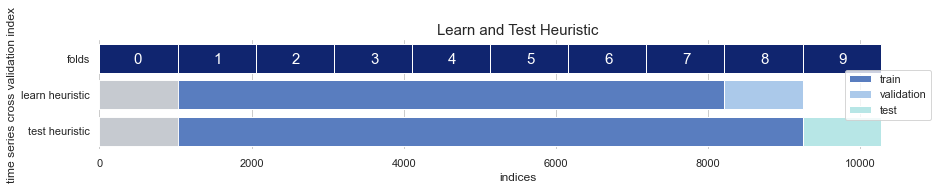

time: 1.12 s (started: 2022-08-29 22:35:21 -07:00)


In [146]:
nsp.plot_time_series_cross_validation_9_splits_with_learn_heuristic_and_test_heuristic(df=df_team_advanced_box_scores_team_box_scores_collection_stacked_away_home_a_b['a_b'])

In [147]:
sns.reset_orig()

time: 820 µs (started: 2022-08-29 22:35:22 -07:00)


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


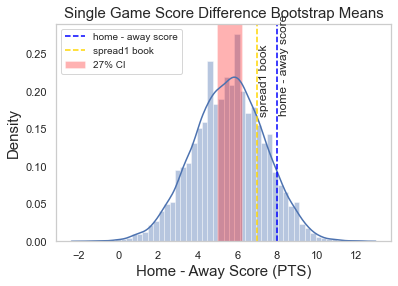

time: 1.42 s (started: 2022-08-29 22:35:22 -07:00)


In [149]:
nsp.plot_spread_bootstrap_mean_distribution_by_game_id(df=df_spread1_score_difference_score_difference_predicted_bootstrap_means, 
                                                       game_id=df_spread1_score_difference_score_difference_predicted_bootstrap_means.iloc[2, :].game_id,
                                                       confidence_interval = 27,
                                                       plot_name='single_game_score_difference_bookstrap_mean_distribution',
                                                       legend_position_upper_left_upper_right='upper left')


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


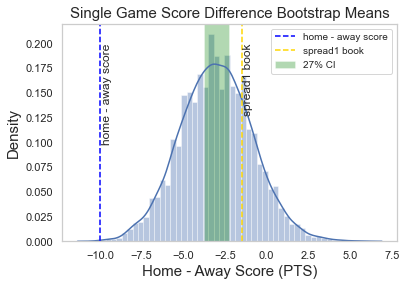

time: 1.44 s (started: 2022-08-29 22:35:24 -07:00)


In [150]:
nsp.plot_spread_bootstrap_mean_distribution_by_game_id(df=df_spread1_score_difference_score_difference_predicted_bootstrap_means, 
                                                       game_id=df_spread1_score_difference_score_difference_predicted_bootstrap_means.iloc[12, :].game_id,
                                                       confidence_interval = 27,
                                                       legend_position_upper_left_upper_right='upper right')


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


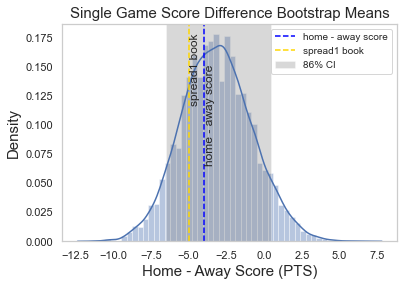

time: 1.35 s (started: 2022-08-29 22:35:25 -07:00)


In [151]:
nsp.plot_spread_bootstrap_mean_distribution_by_game_id(df=df_spread1_score_difference_score_difference_predicted_bootstrap_means, 
                                                       game_id=df_spread1_score_difference_score_difference_predicted_bootstrap_means.iloc[33, :].game_id,
                                                       confidence_interval = 86,
                                                       legend_position_upper_left_upper_right='upper right')


<font size="5"><a id='[Betting_Policy_Learn_Heuristic]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

<font size="6"><a id='[Betting_Policy_Learn_Heuristic]'>Betting Policy: Learn Heuristic</a> </font>

In [152]:
#get folds 1234567 test betting policy features
df_time_series_cross_validation_9_splits_folds_1234567_test = nsp.get_concat_of_first_n_of_test_collection(df_collection=df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection, n=7)

p(df_time_series_cross_validation_9_splits_folds_1234567_test)


(7035, 116)


game_id     team_id   a_team_id   game_date  spread1  spread1_abs  \
0     21001034  1610612755  1610612757  2011-03-19      7.5          7.5   
1     21001035  1610612751  1610612764  2011-03-20     -2.5          2.5   
2     21001036  1610612765  1610612737  2011-03-20      7.0          7.0   
3     21001037  1610612752  1610612749  2011-03-20     -2.0          2.0   
4     21001038  1610612758  1610612750  2011-03-20      4.5          4.5   
7030  21600563  1610612745  1610612761  2017-01-08     -2.0          2.0   
7031  21600564  1610612762  1610612763  2017-01-08      2.5          2.5   
7032  21600565  1610612739  1610612756  2017-01-08     -8.5          8.5   
7033  21600566  1610612744  1610612758  2017-01-08    -12.0         12.0   
7034  21600567  1610612753  1610612747  2017-01-08      2.5          2.5   

      score_difference_predicted  score_difference_predicted_abs  \
0                         3.0625                          3.0625   
1                        -5.0575                          5.0575   
2                         5.6225                          5.6225   
3                        -2.2500                          2.2500   
4                         2.5550                          2.5550   
7030                     -1.6175                          1.6175   
7031                      0.6000                          0.6000   
7032                     -3.3550                          3.3550   
7033                     -9.1575                          9.1575   
7034                      2.8225                          2.8225   

      score_difference_predicted_spread1_diff  \
0                                     -4.4375   
1                                     -2.5575   
2                                     -1.3775   
3                                     -0.2500   
4                                     -1.9450   
7030                                   0.3825   
7031                                  -1.9000   
7032                                   5.1450   
7033                                   2.8425   
7034                                   0.3225   

      score_difference_predicted_spread1_diff_abs  score_difference  \
0                                          4.4375                 9   
1                                          2.5575                 6   
2                                          1.3775                 8   
3                                          0.2500                 5   
4                                          1.9450               -32   
7030                                       0.3825                -7   
7031                                       1.9000                 9   
7032                                       5.1450                -4   
7033                                       2.8425               -11   
7034                                       0.3225                16   

     bet_spread1_spread2  price_break_even winning_bet   bet_roi  \
0                spread1          0.516908          no -1.000000   
1                spread1          0.504950          no -1.000000   
2                spread1          0.512195          no -1.000000   
3                spread1          0.512195          no -1.000000   
4                spread1          0.516908         yes  0.934579   
7030             spread2          0.523810          no -1.000000   
7031             spread1          0.523810          no -1.000000   
7032             spread2          0.523810         yes  0.909091   
7033             spread2          0.523810         yes  0.909091   
7034             spread2          0.523810         yes  0.909091   

     0_percent_confidence_interval_place_bet_yes_no  \
0                                               yes   
1                                               yes   
2                                               yes   
3                                               yes   
4                                               yes   
7030                

time: 223 ms (started: 2022-08-29 22:35:27 -07:00)


In [153]:
column_name_list_betting_policy_result = ['percent_confidence_interval_place_bet_yes_no', 'spread1_abs_lower_limit', 'price_break_even_upper_limit', 
                                          'number_of_games_bet_on', 'games_bet_on_percentage', 'games_bet_on_winning_bet_percentage', 
                                          'games_bet_on_winning_bet_percentage_push_adjusted', 'winning_bet_no_streak', 'winning_bet_yes_streak',
                                          'largest_bet_gain', 'largest_bet_loss',
                                          'roi_min', 'roi_max', 'roi_final']

time: 358 µs (started: 2022-08-29 22:35:27 -07:00)


<font size="4">Get Betting Policy Results for folds 1 thru 7 using the sportsbook price break even and absolute value of spread1 in folds 1 thru 7. Then save it.</font>

In [154]:
df_readback = \
nsp.return_processed_data_file_if_it_exists(filename='36_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_trial_7_percentage_betting_scheme.gz')

if df_readback.empty == False:
    df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results = df_readback


else:
    
    df_time_series_cross_validation_9_splits_folds_1234567_test = nsp.get_concat_of_first_n_of_test_collection(df_collection=df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection, n=7)

    #get betting policy features
    
    #get betting policy feature unique lists
    price_break_even_upper_limit_list = list(set(df_time_series_cross_validation_9_splits_folds_1234567_test.price_break_even)) + [1]

    spread1_abs_list = list(set(df_time_series_cross_validation_9_splits_folds_1234567_test.spread1_abs)) + [-1]

    #get confidence interval feature column name list
    percent_confidence_interval_place_bet_yes_no_list = [k for k in list(df_time_series_cross_validation_9_splits_folds_1234567_test.columns) if '_percent_confidence_interval_place_bet_yes_no' in k]

    
    #get betting policy results
    df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results = pd.DataFrame()
    for a in percent_confidence_interval_place_bet_yes_no_list:
        for b in price_break_even_upper_limit_list:
            for c in spread1_abs_list:
                df_temp = nsp.get_results_for_games_selected_by_policy(df = df_time_series_cross_validation_9_splits_folds_1234567_test,
                                                                       percent_confidence_interval_place_bet_yes_no = a,
                                                                       spread1_abs_lower_limit = c,
                                                                       price_break_even_upper_limit = b,
                                                                       percentage_of_account_balance_to_bet = .05)
                df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results = pd.concat([df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results, df_temp])
                
    #give each column a name            
    df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results.columns = column_name_list_betting_policy_result


    #save it
    df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results = \
    save_and_return_data_frame(
        df=df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results, 
        filename='36_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_trial_7_percentage_betting_scheme.gz',
        index=False,
        parse_dates=False)

p(df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results)



This file already exists
(112918, 14)


percent_confidence_interval_place_bet_yes_no  spread1_abs_lower_limit  \
0                                                  0                      0.0   
1                                                  0                      1.0   
2                                                  0                      2.5   
3                                                  0                      2.0   
4                                                  0                      4.5   
112913                                           100                     18.0   
112914                                           100                     18.5   
112915                                           100                     19.5   
112916                                           100                     19.0   
112917                                           100                     -1.0   

        price_break_even_upper_limit  number_of_games_bet_on  \
0                           0.516908                    3432   
1                           0.516908                    3277   
2                           0.516908                    2761   
3                           0.516908                    2949   
4                           0.516908                    2037   
112913                      1.000000                       1   
112914                      1.000000                       1   
112915                      1.000000                       0   
112916                      1.000000                       1   
112917                      1.000000                     174   

        games_bet_on_percentage  games_bet_on_winning_bet_percentage  \
0                         48.78                                49.24   
1                         46.58                                49.53   
2                         39.25                                49.91   
3                         41.92                                49.98   
4                         28.96                                50.52   
112913                     0.01                               100.00   
112914                     0.01                               100.00   
112915                     0.00                                 0.00   
112916                     0.01                               100.00   
112917                     2.47                                57.47   

        games_bet_on_winning_bet_percentage_push_adjusted  \
0                                                   50.10   
1                                                   50.39   
2                                                   50.85   
3                                                   50.86   
4                                                   51.50   
112913                                             100.00   
112914                                             100.00   
112915                                               0.00   
112916                                             100.00   
112917                                              58.48   

        winning_bet_no_streak  winning_bet_yes_streak  largest_bet_gain  \
0                          10                      15             71.44   
1                           9                      14             67.20   
2                          11                      12             75.01   
3                           9                      13             70.01   
4                          12                      12             85.71   
112913                      0                       1             47.62   
112914                      0                       1             47.62   
112915                      0                       0              0.00   
112916                      0                       1             47.62   
112917                      6                       8            157.10   

        largest_bet_loss  roi_min  roi_max  roi_final  
0                 -77.16    -1.00     0.54      -1.00  
1       

time: 132 ms (started: 2022-08-29 22:35:27 -07:00)


<font size="4">Filter Betting Policy Results folds 1 thru 7 for a minimum 50% winning bet accuracy and a minimum 2% of games bet on. </font>

In [155]:
#take betting policy results with a minimum 50% winning bet accuracy and at minimum 2% of games bet on.

def filter_data_frame_by_betting_policy_result(df = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results,
                                               games_bet_on_percentage_lower_limit = 1.99,
                                               games_bet_on_winning_bet_percentage_lower_limit = 49.9999):
    df = df.loc[df.loc[:, 'games_bet_on_percentage'] > games_bet_on_percentage_lower_limit, :]
    
    return df.loc[df.loc[:, 'games_bet_on_winning_bet_percentage'] > games_bet_on_winning_bet_percentage_lower_limit, :]


df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results = filter_data_frame_by_betting_policy_result(df = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results, 
                                                                                                                               games_bet_on_percentage_lower_limit = 1.99, 
                                                                                                                               games_bet_on_winning_bet_percentage_lower_limit = 49.9999)

df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results.sort_values(['games_bet_on_winning_bet_percentage', 'games_bet_on_percentage'], 
                                                                                                                                                                                    ascending=False)

df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results.reset_index(drop=True)

p(df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results)


(28800, 14)


percent_confidence_interval_place_bet_yes_no  spread1_abs_lower_limit  \
0                                               100                      3.0   
1                                               100                      3.0   
2                                               100                      3.0   
3                                               100                      3.0   
4                                               100                      1.5   
28795                                            73                     14.5   
28796                                            73                     14.5   
28797                                            74                     14.5   
28798                                            74                     14.5   
28799                                            99                      8.0   

       price_break_even_upper_limit  number_of_games_bet_on  \
0                          0.555556                     143   
1                          0.591837                     143   
2                          0.549550                     143   
3                          1.000000                     143   
4                          0.555556                     163   
28795                      0.591837                     142   
28796                      1.000000                     142   
28797                      0.591837                     142   
28798                      1.000000                     142   
28799                      0.514563                     142   

       games_bet_on_percentage  games_bet_on_winning_bet_percentage  \
0                         2.03                                60.14   
1                         2.03                                60.14   
2                         2.03                                60.14   
3                         2.03                                60.14   
4                         2.32                                60.12   
28795                     2.02                                50.00   
28796                     2.02                                50.00   
28797                     2.02                                50.00   
28798                     2.02                                50.00   
28799                     2.02                                50.00   

       games_bet_on_winning_bet_percentage_push_adjusted  \
0                                                  60.99   
1                                                  60.99   
2                                                  60.99   
3                                                  60.99   
4                                                  60.87   
28795                                              51.45   
28796                                              51.45   
28797                                              51.45   
28798                                              51.45   
28799                                              51.82   

       winning_bet_no_streak  winning_bet_yes_streak  largest_bet_gain  \
0                          6                       7            172.76   
1                          6                       7            172.76   
2                          6                       7            172.76   
3                          6                       7            172.76   
4                          6                       8            205.15   
28795                      7                       5             58.89   
28796                      7                       5             58.89   
28797                      7                       5             58.89   
28798                      7                       5             58.89   
28799                      7                       5             80.80   

       largest_bet_loss  roi_min  roi_max  roi_final  
0               -194.90     0.00     2.90       2.06  
1               -194.90     0.00     2.90       2.06  
2        

time: 18.8 ms (started: 2022-08-29 22:35:27 -07:00)


<AxesSubplot:>

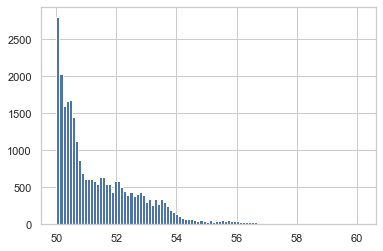

time: 153 ms (started: 2022-08-29 22:35:27 -07:00)


In [156]:
#view betting accuracy distribution with 50% betting accuracy minimum and 2% of games bet on minimum
df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results.loc[:, 'games_bet_on_winning_bet_percentage'].hist(bins=100)

<font size="4">Filter Betting Policy Results again, but now for the top 5% of betting policies by winning bet accuracy. </font>

In [157]:
#filter for the top 5% of betting policies by betting accuracy

row_count_5_percent = int(round(df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results.shape[0] *.05, 0))

df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent = \
df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results.head(row_count_5_percent)

p(df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent)


(1440, 14)


percent_confidence_interval_place_bet_yes_no  spread1_abs_lower_limit  \
0                                              100                      3.0   
1                                              100                      3.0   
2                                              100                      3.0   
3                                              100                      3.0   
4                                              100                      1.5   
1435                                            55                     13.0   
1436                                            56                     13.0   
1437                                            76                      8.5   
1438                                            79                      8.5   
1439                                            26                      4.0   

      price_break_even_upper_limit  number_of_games_bet_on  \
0                         0.555556                     143   
1                         0.591837                     143   
2                         0.549550                     143   
3                         1.000000                     143   
4                         0.555556                     163   
1435                      0.523810                     203   
1436                      0.523810                     203   
1437                      0.512195                     203   
1438                      0.509804                     179   
1439                      0.504950                     155   

      games_bet_on_percentage  games_bet_on_winning_bet_percentage  \
0                        2.03                                60.14   
1                        2.03                                60.14   
2                        2.03                                60.14   
3                        2.03                                60.14   
4                        2.32                                60.12   
1435                     2.89                                54.19   
1436                     2.89                                54.19   
1437                     2.89                                54.19   
1438                     2.54                                54.19   
1439                     2.20                                54.19   

      games_bet_on_winning_bet_percentage_push_adjusted  \
0                                                 60.99   
1                                                 60.99   
2                                                 60.99   
3                                                 60.99   
4                                                 60.87   
1435                                              55.84   
1436                                              55.84   
1437                                              55.56   
1438                                              55.75   
1439                                              55.26   

      winning_bet_no_streak  winning_bet_yes_streak  largest_bet_gain  \
0                         6                       7            172.76   
1                         6                       7            172.76   
2                         6                       7            172.76   
3                         6                       7            172.76   
4                         6                       8            205.15   
1435                      4                       7            111.97   
1436                      4                       7            111.97   
1437                      6                       9            159.28   
1438                      6                       8            149.00   
1439                      6                       8            108.20   

      largest_bet_loss  roi_min  roi_max  roi_final  
0              -194.90     0.00     2.90       2.06  
1              -194.90     0.00     2.90       2.06  
2              -194.90     0.00     2.90       2.06  
3           

time: 10.8 ms (started: 2022-08-29 22:35:27 -07:00)


<AxesSubplot:>

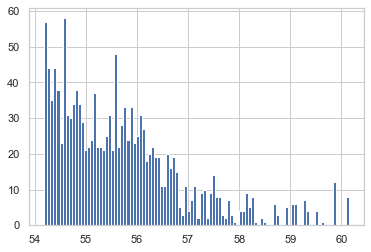

time: 160 ms (started: 2022-08-29 22:35:27 -07:00)


In [158]:
df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'games_bet_on_winning_bet_percentage'].hist(bins=100)


In [159]:
'''Select policies that have counts that stick out'''

'Select policies that have counts that stick out'

time: 1.28 ms (started: 2022-08-29 22:35:27 -07:00)


 7.5     245
 8.5     210
 8.0     202
 9.5     170
 10.5     82
 13.0     72
 10.0     64
 5.5      45
 7.0      44
 3.0      32
 6.0      30
 4.0      30
 4.5      26
 9.0      26
 3.5      21
 2.0      21
 2.5      19
 5.0      18
 11.0     16
 6.5      13
 12.5     13
-1.0      10
 1.5      10
 0.0      10
 1.0      10
 11.5      1
Name: spread1_abs_lower_limit, dtype: int64

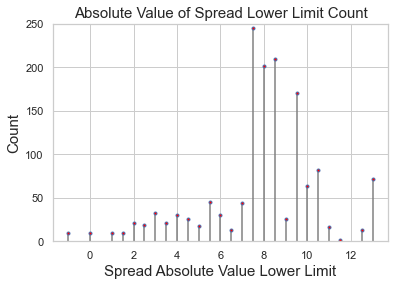

time: 1.02 s (started: 2022-08-29 22:35:27 -07:00)


In [160]:
x = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'spread1_abs_lower_limit'].value_counts().index.tolist()
y = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'spread1_abs_lower_limit'].value_counts().values.tolist()

markerline, stemlines, baseline = plt.stem(x, y, linefmt='grey', markerfmt='.', bottom=0, basefmt=' ')

markerline.set_markerfacecolor('red')

plt.xlabel("Spread Absolute Value Lower Limit", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.title('Absolute Value of Spread Lower Limit Count', fontsize=15)

plt.ylim([0,250])

plt.savefig('figure_learn_heuristic_times_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent_spread1_abs_lower_limit_count_stem_plot.png', bbox_inches='tight', dpi=1000)

#plt.show()
df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'spread1_abs_lower_limit'].value_counts()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


price_break_even_upper_limit_min: 0.504950495049505
price_break_even_upper_limit_max: 0.5939


0.509804    505
0.512195    481
0.507389    138
0.504950    137
0.523810     66
0.521531     20
0.519231     18
0.555556      8
0.543379      8
0.545455      8
0.541284      8
0.549550      8
0.591837      7
0.539171      7
0.526066      7
0.593900      7
0.528302      7
Name: price_break_even_upper_limit, dtype: int64

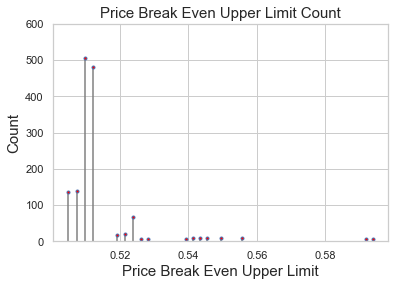

time: 918 ms (started: 2022-08-29 22:35:28 -07:00)


In [161]:
def fix_price_break_even_upper_limit(df):
    df.loc[:, 'price_break_even_upper_limit'] = df.loc[:, 'price_break_even_upper_limit'].replace({1:0.5939})
    return df

df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent = \
fix_price_break_even_upper_limit(df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent)

###
x = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts().index.tolist()
y = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts().values.tolist()

markerline, stemlines, baseline = plt.stem(x, y, linefmt='grey', markerfmt='.', bottom=0, basefmt=' ')

markerline.set_markerfacecolor('red')

plt.xlabel("Price Break Even Upper Limit", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.title('Price Break Even Upper Limit Count', fontsize=15)

plt.ylim([0,600])

plt.savefig('figure_learn_heuristic_times_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent_price_break_even_upper_limit_count_stem_plot.png', bbox_inches='tight', dpi=1000)

#plt.show()
price_break_even_upper_limit_min = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].min()
price_break_even_upper_limit_max = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].max()
print('price_break_even_upper_limit_min: ' + str(price_break_even_upper_limit_min) + '\n' + 'price_break_even_upper_limit_max: ' + str(price_break_even_upper_limit_max))

df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts()

100    70
9      24
8      24
11     23
10     23
7      21
12     21
50     20
4      20
3      19
67     19
49     19
48     19
5      19
6      19
13     19
14     18
2      18
53     18
52     18
Name: percent_confidence_interval_place_bet_yes_no, dtype: int64

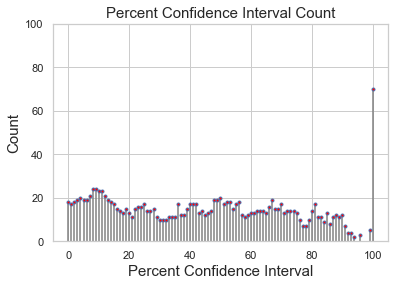

time: 968 ms (started: 2022-08-29 22:35:29 -07:00)


In [162]:
x = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().index.tolist()
y = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().values.tolist()

markerline, stemlines, baseline = plt.stem(x, y, linefmt='grey', markerfmt='.', bottom=0, basefmt=' ')

markerline.set_markerfacecolor('red')

plt.xlabel("Percent Confidence Interval", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.title('Percent Confidence Interval Count', fontsize=15)

plt.ylim([0,100])

plt.savefig('figure_learn_heuristic_times_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent_percent_confidence_interval_count_stem_plot.png', bbox_inches='tight', dpi=1000)

#plt.show()

df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().head(20)


In [163]:
#absolute value of spread1 lower limit selected is 9.5. it is in the neighborhood of top absolute value of spread1 lower limit values and directs betting against an extreme score difference.
spread1_abs_lower_limit_list = \
df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'spread1_abs_lower_limit'].value_counts().index[3:4]

if not isinstance(spread1_abs_lower_limit_list, list):
    spread1_abs_lower_limit_list = spread1_abs_lower_limit_list.to_list()



#100 and 9 are selected from the top 3 by value count, but 100 is removed for because of excessive game count drop. This leaves the 9 percent confidence interval.
percent_confidence_interval_place_bet_yes_no_list = \
df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().head(20).index[1:2]

if not isinstance(percent_confidence_interval_place_bet_yes_no_list, list):
    percent_confidence_interval_place_bet_yes_no_list = percent_confidence_interval_place_bet_yes_no_list.to_list()

percent_confidence_interval_place_bet_yes_no_list = \
[str(k) + '_percent_confidence_interval_place_bet_yes_no' for k in percent_confidence_interval_place_bet_yes_no_list]


#price break even upper limit .509803 and .512195, both with high value counts, are selected.
#top differentiated value counts of break_even values
price_break_even_upper_limit_list = df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts().index[0:2]

if not isinstance(price_break_even_upper_limit_list, list):
    price_break_even_upper_limit_list = price_break_even_upper_limit_list.to_list()



multiple_betting_policy = [percent_confidence_interval_place_bet_yes_no_list, spread1_abs_lower_limit_list, price_break_even_upper_limit_list]
multiple_betting_policy

[['9_percent_confidence_interval_place_bet_yes_no'],
 [9.5],
 [0.5098039215686274, 0.5121951219512195]]

time: 4.21 ms (started: 2022-08-29 22:35:30 -07:00)


<font size='4'>Betting Policy Sanity Check. Apply betting policy to folds 1 thru 7.</font>

In [164]:
#get multiple betting policy result with 5% of account balance betting over folds 1234567
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_050 = \
nsp.get_results_for_games_selected_by_policies(df = df_time_series_cross_validation_9_splits_folds_1234567_test,
                                               percent_confidence_interval_place_bet_yes_no = ['8_percent_confidence_interval_place_bet_yes_no'],
                                               spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                               price_break_even_upper_limit = price_break_even_upper_limit_list,
                                               percentage_of_account_balance_to_bet = .05,
                                               principal = 1000)

df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_050.columns = column_name_list_betting_policy_result
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_050 = df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_050.T
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_050.columns = ['betting_policy_050_and_result']



#get multiple betting policy result with 2.5% of account balance betting over folds 1234567
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_025 = \
nsp.get_results_for_games_selected_by_policies(df = df_time_series_cross_validation_9_splits_folds_1234567_test,
                                               percent_confidence_interval_place_bet_yes_no = percent_confidence_interval_place_bet_yes_no_list,
                                               spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                               price_break_even_upper_limit = price_break_even_upper_limit_list,
                                               percentage_of_account_balance_to_bet = .025,
                                               principal = 1000)

df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_025.columns = column_name_list_betting_policy_result
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_025 = df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_025.T
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_025.columns = ['betting_policy_025_and_result']




#get multiple betting policy result with 1% of account balance betting over folds 1234567
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_010 = \
nsp.get_results_for_games_selected_by_policies(df = df_time_series_cross_validation_9_splits_folds_1234567_test,
                                           percent_confidence_interval_place_bet_yes_no = percent_confidence_interval_place_bet_yes_no_list,
                                           spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                           price_break_even_upper_limit = price_break_even_upper_limit_list,
                                           percentage_of_account_balance_to_bet = .01,
                                           principal = 1000)

df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_010.columns = column_name_list_betting_policy_result
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_010 = df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_010.T
df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_010.columns = ['betting_policy_010_and_result']



pd.concat([df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_050,
           df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_025,
           df_time_series_cross_validation_9_splits_fold_1234567_test_multiple_betting_policy_result_percentage_betting_scheme_010],
           axis=1)

betting_policy_050_and_result  \
percent_confidence_interval_place_bet_yes_no                                              8   
spread1_abs_lower_limit                                                                 9.5   
price_break_even_upper_limit                       [0.5098039215686274, 0.5121951219512195]   
number_of_games_bet_on                                                                  467   
games_bet_on_percentage                                                                6.64   
games_bet_on_winning_bet_percentage                                                    56.1   
games_bet_on_winning_bet_percentage_push_adjusted                                     57.33   
winning_bet_no_streak                                                                    10   
winning_bet_yes_streak                                                                   23   
largest_bet_gain                                                                     797.99   
largest_bet_loss                                                                    -861.83   
roi_min                                                                               -0.13   
roi_max                                                                               16.24   
roi_final                                                                             11.25   

                                                              betting_policy_025_and_result  \
percent_confidence_interval_place_bet_yes_no                                              9   
spread1_abs_lower_limit                                                                 9.5   
price_break_even_upper_limit                       [0.5098039215686274, 0.5121951219512195]   
number_of_games_bet_on                                                                  463   
games_bet_on_percentage                                                                6.58   
games_bet_on_winning_bet_percentage                                                   56.16   
games_bet_on_winning_bet_percentage_push_adjusted                                      57.4   
winning_bet_no_streak                                                                    10   
winning_bet_yes_streak                                                                   23   
largest_bet_gain                                                                     108.55   
largest_bet_loss                                                                    -114.52   
roi_min                                                                               -0.06   
roi_max                                                                                3.58   
roi_final                                                                              3.03   

                                                              betting_policy_010_and_result  
percent_confidence_interval_place_bet_yes_no                                              9  
spread1_abs_lower_limit                                                                 9.5  
price_break_even_upper_limit                       [0.5098039215686274, 0.5121951219512195]  
number_of_games_bet_on                                                                  463  
games_bet_on_percentage                                                                6.58  
games_bet_on_winning_bet_percentage                                                   56.16  
games_bet_on_winning_bet_percentage_push_adjusted                                      57.4  
winning_bet_no_streak                                                                    10  
winning_bet_yes_streak                                                                   23  
largest_bet_gain                                                                      18.11  
largest_bet_loss                                                                      -18.8  
roi_min                                                                           

time: 78.7 ms (started: 2022-08-29 22:35:30 -07:00)


<font size="4">Learn Heuristic Test. </font>

In [165]:
df_readback = \
nsp.return_processed_data_file_if_it_exists(filename='36_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result_trial_7_percentage_betting_scheme.gz')

if df_readback.empty == False:
    df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result = df_readback

else:
    #get times series cross validation 9 splits fold 8 test betting policy features
    df_time_series_cross_validation_9_splits_fold_8_test_betting_policy_feature_collection = df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection[7]


    #times series cross validation 9 splits fold 8 test multiple betting policy result
    df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result = \
    nsp.get_results_for_games_selected_by_policies(df = df_time_series_cross_validation_9_splits_fold_8_test_betting_policy_feature_collection,
                                                   percent_confidence_interval_place_bet_yes_no = percent_confidence_interval_place_bet_yes_no_list,
                                                   spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                                   price_break_even_upper_limit = price_break_even_upper_limit_list,
                                                   percentage_of_account_balance_to_bet = .01,
                                                   principal = 1000)


    df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result.columns = column_name_list_betting_policy_result
    df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result = df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result.T
    df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result.columns = ['betting_policy_01_and_result']


    #save it
    df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result = \
    save_and_return_data_frame(
        df=df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result, 
        filename='36_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result_trial_7_percentage_betting_scheme.gz',
        index=True,
        parse_dates=False,
        index_label=[' '])

df_time_series_cross_validation_9_splits_fold_8_test_multiple_betting_policy_result



This file already exists


\
0        percent_confidence_interval_place_bet_yes_no   
1                             spread1_abs_lower_limit   
2                        price_break_even_upper_limit   
3                              number_of_games_bet_on   
4                             games_bet_on_percentage   
5                 games_bet_on_winning_bet_percentage   
6   games_bet_on_winning_bet_percentage_push_adjusted   
7                               winning_bet_no_streak   
8                              winning_bet_yes_streak   
9                                    largest_bet_gain   
10                                   largest_bet_loss   
11                                            roi_min   
12                                            roi_max   
13                                          roi_final   

                betting_policy_01_and_result  
0                                          9  
1                                        9.5  
2   [0.5098039215686274, 0.5121951219512195]  
3                                         35  
4                                        3.8  
5                                      62.86  
6                                      62.86  
7                                          4  
8                                         12  
9                                       10.7  
10                                    -11.02  
11                                     -0.02  
12                                       0.1  
13                                      0.09

time: 67.1 ms (started: 2022-08-29 22:35:30 -07:00)


<font size="5"><a id='[Betting_Policy_Test_Heuristic]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

<font size="6"><a id='[Betting_Policy_Test_Heuristic]'>Betting Policy: Test Heuristic</a> </font>

<font size='4'>Get Data Frame and Lists.</fold>

In [166]:
#get time series cross validation 9 split folds 12345678 test betting policy features
df_time_series_cross_validation_9_splits_folds_12345678_test = nsp.get_concat_of_first_n_of_test_collection(df_collection=df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection, n=8)


#get price break even and absolute value of spread uniques
price_break_even_upper_limit_list = list(set(df_time_series_cross_validation_9_splits_folds_12345678_test.loc[:, 'price_break_even'])) + [1]


spread1_abs_list = list(set(df_time_series_cross_validation_9_splits_folds_12345678_test.loc[:, 'spread1_abs'])) + [-1]


percent_confidence_interval_place_bet_yes_no_list = [k for k in list(df_time_series_cross_validation_9_splits_folds_12345678_test.columns) if '_percent_confidence_interval_place_bet_yes_no' in k]



time: 48.3 ms (started: 2022-08-29 22:35:30 -07:00)


In [167]:
df_readback = \
nsp.return_processed_data_file_if_it_exists(filename='36_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_trial_7_percentage_betting_scheme.gz')

if df_readback.empty == False:
    df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results = df_readback

else:
    df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results = pd.DataFrame()
    for a in percent_confidence_interval_place_bet_yes_no_list:
        for b in price_break_even_upper_limit_list:
            for c in spread1_abs_list:
                df_temp = nsp.get_results_for_games_selected_by_policy(df = df_time_series_cross_validation_9_splits_folds_12345678_test,
                                                                       percent_confidence_interval_place_bet_yes_no = a,
                                                                       spread1_abs_lower_limit = c,
                                                                       price_break_even_upper_limit = b,
                                                                       percentage_of_account_balance_to_bet = .01)
                df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results = pd.concat([df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results, df_temp])   

                
    df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results.columns = column_name_list_betting_policy_result
    
    #save it
    df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results = \
    save_and_return_data_frame(
        df=df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results, 
        filename='36_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_trial_7_percentage_betting_scheme.gz',
        index=False,
        parse_dates=False)

p(df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results)


This file already exists
(117261, 14)


percent_confidence_interval_place_bet_yes_no  spread1_abs_lower_limit  \
0                                                  0                      0.0   
1                                                  0                      1.0   
2                                                  0                      2.5   
3                                                  0                      2.0   
4                                                  0                      4.5   
117256                                           100                     18.0   
117257                                           100                     18.5   
117258                                           100                     19.5   
117259                                           100                     19.0   
117260                                           100                     -1.0   

        price_break_even_upper_limit  number_of_games_bet_on  \
0                           0.516908                    3635   
1                           0.516908                    3466   
2                           0.516908                    2920   
3                           0.516908                    3124   
4                           0.516908                    2151   
117256                      1.000000                       2   
117257                      1.000000                       2   
117258                      1.000000                       0   
117259                      1.000000                       1   
117260                      1.000000                     207   

        games_bet_on_percentage  games_bet_on_winning_bet_percentage  \
0                         45.69                                49.16   
1                         43.56                                49.39   
2                         36.70                                49.62   
3                         39.27                                49.71   
4                         27.04                                50.26   
117256                     0.03                                50.00   
117257                     0.03                                50.00   
117258                     0.00                                 0.00   
117259                     0.01                               100.00   
117260                     2.60                                57.00   

        games_bet_on_winning_bet_percentage_push_adjusted  \
0                                                   50.07   
1                                                   50.31   
2                                                   50.63   
3                                                   50.65   
4                                                   51.31   
117256                                              50.00   
117257                                              50.00   
117258                                               0.00   
117259                                             100.00   
117260                                              57.84   

        winning_bet_no_streak  winning_bet_yes_streak  largest_bet_gain  \
0                          10                      15             10.54   
1                           9                      14             10.67   
2                          11                      12             10.98   
3                           9                      13             10.85   
4                          12                      12             12.35   
117256                      1                       1              9.52   
117257                      1                       1              9.52   
117258                      0                       0              0.00   
117259                      0                       1              9.52   
117260                      6                       8             12.48   

        largest_bet_loss  roi_min  roi_max  roi_final  
0                 -10.96    -0.59     0.10      -0.52  
1       

time: 130 ms (started: 2022-08-29 22:35:30 -07:00)


<font size='4'>Select Betting Policy Results with at least a 50% winning percentage and 2% of games bet on. </fold>

In [168]:
def filter_dataframe_by_policy(df = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results,
                               games_bet_on_percentage_lower_limit = 1.99,
                               games_bet_on_winning_bet_percentage_lower_limit = 49.9999):
    df = df.loc[df.loc[:, 'games_bet_on_percentage'] > games_bet_on_percentage_lower_limit, :]
    
    df = df.loc[df.loc[:, 'games_bet_on_winning_bet_percentage'] > games_bet_on_winning_bet_percentage_lower_limit, :]
    
    return df

df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results = filter_dataframe_by_policy(df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results,
                                                                                                                 games_bet_on_percentage_lower_limit = 1.99,
                                                                                                                 games_bet_on_winning_bet_percentage_lower_limit = 49.9999)

df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results.sort_values(['games_bet_on_winning_bet_percentage', 'games_bet_on_percentage'], 
                                                                                        ascending=False)
df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results.reset_index(drop=True)
p(df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results)




(28136, 14)


percent_confidence_interval_place_bet_yes_no  spread1_abs_lower_limit  \
0                                                90                      7.5   
1                                                90                      7.5   
2                                                88                      7.5   
3                                                91                      7.5   
4                                                89                      7.5   
28131                                            73                     14.5   
28132                                            74                     14.5   
28133                                            74                     14.5   
28134                                            77                     14.5   
28135                                            77                     14.5   

       price_break_even_upper_limit  number_of_games_bet_on  \
0                          0.509804                     170   
1                          0.512195                     180   
2                          0.509804                     187   
3                          0.509804                     159   
4                          0.509804                     181   
28131                      0.549550                     162   
28132                      0.555556                     162   
28133                      0.549550                     162   
28134                      0.555556                     160   
28135                      0.549550                     160   

       games_bet_on_percentage  games_bet_on_winning_bet_percentage  \
0                         2.14                                60.59   
1                         2.26                                60.00   
2                         2.35                                59.89   
3                         2.00                                59.75   
4                         2.28                                59.67   
28131                     2.04                                50.00   
28132                     2.04                                50.00   
28133                     2.04                                50.00   
28134                     2.01                                50.00   
28135                     2.01                                50.00   

       games_bet_on_winning_bet_percentage_push_adjusted  \
0                                                  62.42   
1                                                  61.71   
2                                                  61.54   
3                                                  61.29   
4                                                  61.36   
28131                                              51.59   
28132                                              51.59   
28133                                              51.59   
28134                                              51.61   
28135                                              51.61   

       winning_bet_no_streak  winning_bet_yes_streak  largest_bet_gain  \
0                          6                       8             14.21   
1                          5                       9             14.18   
2                          6                       8             14.32   
3                          5                       7             13.41   
4                          6                       8             14.05   
28131                      7                       5             10.28   
28132                      7                       5             10.28   
28133                      7                       5             10.28   
28134                      7                       5             10.29   
28135                      7                       5             10.29   

       largest_bet_loss  roi_min  roi_max  roi_final  
0                -14.64    -0.01     0.46       0.46  
1                -14.60    -0.00     0.46       0.46  
2        

time: 23.1 ms (started: 2022-08-29 22:35:31 -07:00)


<AxesSubplot:>

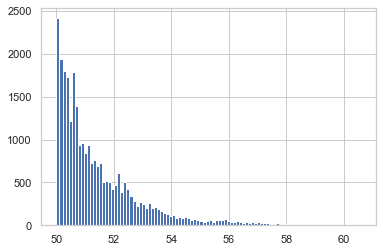

time: 157 ms (started: 2022-08-29 22:35:31 -07:00)


In [169]:
df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results.games_bet_on_winning_bet_percentage.hist(bins=100)

<AxesSubplot:>

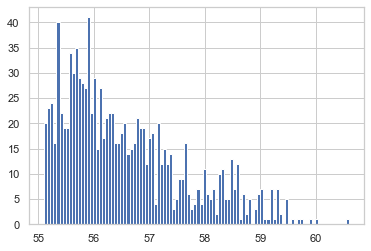

time: 164 ms (started: 2022-08-29 22:35:31 -07:00)


In [170]:
#take the approximately top 5% of policy's by betting accuracy
df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results.head(1100).games_bet_on_winning_bet_percentage.hist(bins=100)

In [171]:
df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent = \
df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results.head(1100)

p(df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent)


(1100, 14)


percent_confidence_interval_place_bet_yes_no  spread1_abs_lower_limit  \
0                                               90                      7.5   
1                                               90                      7.5   
2                                               88                      7.5   
3                                               91                      7.5   
4                                               89                      7.5   
1095                                            22                      7.5   
1096                                            35                      7.5   
1097                                            22                      8.5   
1098                                            90                      7.0   
1099                                            67                      7.0   

      price_break_even_upper_limit  number_of_games_bet_on  \
0                         0.509804                     170   
1                         0.512195                     180   
2                         0.509804                     187   
3                         0.509804                     159   
4                         0.509804                     181   
1095                      0.507389                     283   
1096                      0.507389                     254   
1097                      0.507389                     205   
1098                      0.512195                     205   
1099                      0.509804                     323   

      games_bet_on_percentage  games_bet_on_winning_bet_percentage  \
0                        2.14                                60.59   
1                        2.26                                60.00   
2                        2.35                                59.89   
3                        2.00                                59.75   
4                        2.28                                59.67   
1095                     3.56                                55.12   
1096                     3.19                                55.12   
1097                     2.58                                55.12   
1098                     2.58                                55.12   
1099                     4.06                                55.11   

      games_bet_on_winning_bet_percentage_push_adjusted  \
0                                                 62.42   
1                                                 61.71   
2                                                 61.54   
3                                                 61.29   
4                                                 61.36   
1095                                              56.12   
1096                                              56.22   
1097                                              56.50   
1098                                              56.50   
1099                                              56.15   

      winning_bet_no_streak  winning_bet_yes_streak  largest_bet_gain  \
0                         6                       8             14.21   
1                         5                       9             14.18   
2                         6                       8             14.32   
3                         5                       7             13.41   
4                         6                       8             14.05   
1095                      6                       7             13.36   
1096                      6                       7             13.02   
1097                      6                       7             12.36   
1098                      5                       9             12.56   
1099                      8                      12             13.60   

      largest_bet_loss  roi_min  roi_max  roi_final  
0               -14.64    -0.01     0.46       0.46  
1               -14.60    -0.00     0.46       0.46  
2               -14.74    -0.01     0.47       0.47  
3           

time: 10.3 ms (started: 2022-08-29 22:35:31 -07:00)


0.509804    438
0.512195    387
0.507389    111
0.504950     55
0.526066      9
0.539171      9
0.528302      9
0.543379      9
0.545455      9
0.541284      9
1.000000      9
0.549550      9
0.591837      9
0.567100      9
0.555556      9
0.523810      6
0.519231      3
0.521531      1
Name: price_break_even_upper_limit, dtype: int64

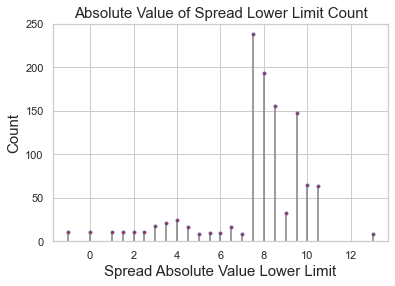

time: 963 ms (started: 2022-08-29 22:35:31 -07:00)


In [172]:

x = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'spread1_abs_lower_limit'].value_counts().index.tolist()
y = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'spread1_abs_lower_limit'].value_counts().values.tolist()

markerline, stemlines, baseline = plt.stem(x, y, linefmt='grey', markerfmt='.', bottom=0, basefmt=' ')

markerline.set_markerfacecolor('red')

plt.xlabel("Spread Absolute Value Lower Limit", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.title('Absolute Value of Spread Lower Limit Count', fontsize=15)

plt.ylim([0,250])

plt.savefig('figure_test_heuristic_betting_policy_results_top5_percent_spread1_abs_count_stem_plot.png', bbox_inches='tight', dpi=1000)

#plt.show()

df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


0.509804    438
0.512195    387
0.507389    111
0.504950     55
0.526066      9
0.539171      9
0.528302      9
0.543379      9
0.545455      9
0.541284      9
0.593900      9
0.549550      9
0.591837      9
0.567100      9
0.555556      9
0.523810      6
0.519231      3
0.521531      1
Name: price_break_even_upper_limit, dtype: int64

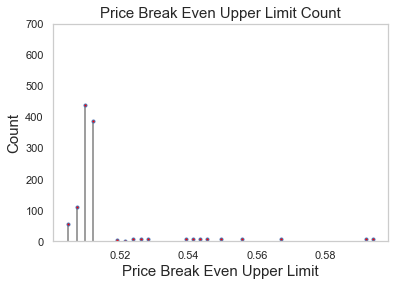

time: 924 ms (started: 2022-08-29 22:35:32 -07:00)


In [173]:
def fix_price_break_even_upper_limit(df):
    df.loc[:, 'price_break_even_upper_limit'] = \
    df.loc[:, 'price_break_even_upper_limit'].replace({1:0.5939})
    
    return df

df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent = \
fix_price_break_even_upper_limit(df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent)


###
x = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts().index.tolist()
y = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts().values.tolist()

markerline, stemlines, baseline = plt.stem(x, y, linefmt='grey', markerfmt='.', bottom=0, basefmt=' ')

markerline.set_markerfacecolor('red')

plt.grid(False)

plt.xlabel("Price Break Even Upper Limit", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.title('Price Break Even Upper Limit Count', fontsize=15)

#price_break_even_upper_limit_ = plt.axvline(.5122, color='dimgrey', linestyle='--', linewidth=1.5)

plt.ylim([0,700])

plt.savefig('figure_test_heuristic_price_break_even_stem_plot.png', bbox_inches='tight', dpi=1000)

#plt.show()

df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts()

100    99
9      16
5      15
8      15
11     15
10     15
7      15
6      15
36     15
3      14
4      14
39     14
40     13
61     13
42     13
23     13
41     13
59     13
60     13
67     13
Name: percent_confidence_interval_place_bet_yes_no, dtype: int64

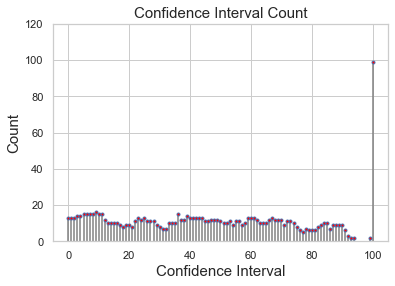

time: 931 ms (started: 2022-08-29 22:35:33 -07:00)


In [174]:
x = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().index.tolist()
y = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().values.tolist()

markerline, stemlines, baseline = plt.stem(x, y, linefmt='grey', markerfmt='.', bottom=0, basefmt=' ')

markerline.set_markerfacecolor('red')

plt.xlabel("Confidence Interval", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.title('Confidence Interval Count', fontsize=15)

plt.ylim([0,120])

plt.savefig('figure_test_heuristic_betting_policy_results_top5_percent_confidence_interval_count_stem_plot.png', bbox_inches='tight', dpi=1000)

#plt.show()

df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().head(20)

In [175]:
'''Select policies that have counts that stick out'''

'Select policies that have counts that stick out'

time: 1 ms (started: 2022-08-29 22:35:34 -07:00)


In [176]:
#price break even upper limit .509803 and .512195 both with high value counts are selected
price_break_even_upper_limit_list = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'price_break_even_upper_limit'].value_counts().index[0:2]

if not isinstance(price_break_even_upper_limit_list, list):
    price_break_even_upper_limit_list = price_break_even_upper_limit_list.to_list()


#100 and 9 are selected from the top 3 by value count, but 100 is removed for because of excessive game count drop. This leaves 9 percent confindence interval. 
percent_confidence_interval_place_bet_yes_no_list = \
df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'percent_confidence_interval_place_bet_yes_no'].value_counts().head(20).index[1:2]

if not isinstance(percent_confidence_interval_place_bet_yes_no_list, list):
    percent_confidence_interval_place_bet_yes_no_list = percent_confidence_interval_place_bet_yes_no_list.to_list()

percent_confidence_interval_place_bet_yes_no_list = \
[str(k) + '_percent_confidence_interval_place_bet_yes_no' for k in percent_confidence_interval_place_bet_yes_no_list]



#absolute value of spread1 lower limit selected is 9.5. it is in the neighbor of top absolute value of spread1 lower limit values and directs betting against an extreme score difference
spread1_abs_lower_limit_list = df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent.loc[:, 'spread1_abs_lower_limit'].value_counts().index[3:4]

if not isinstance(spread1_abs_lower_limit_list, list):
    spread1_abs_lower_limit_list = spread1_abs_lower_limit_list.to_list()

    
    
#get multiple_betting_policy
multiple_betting_policy = [percent_confidence_interval_place_bet_yes_no_list, spread1_abs_lower_limit_list, price_break_even_upper_limit_list]
multiple_betting_policy

[['9_percent_confidence_interval_place_bet_yes_no'],
 [9.5],
 [0.5098039215686274, 0.5121951219512195]]

time: 4.02 ms (started: 2022-08-29 22:35:34 -07:00)


In [177]:
column_name_list_betting_policy_result2 = ['percentage_of_account_balance_per_bet',
                                           'percent_confidence_interval_place_bet_yes_no', 'spread1_abs_lower_limit', 'price_break_even_upper_limit', 
                                           'number_of_bets_placed', 'game_bet_opportunities_bet_on_percentage', 'games_bet_on_winning_bet_percentage', 
                                           'games_bet_on_winning_bet_percentage_push_adjusted', 'winning_bet_no_streak', 'winning_bet_yes_streak', 
                                           'largest_bet_gain', 'largest_bet_loss',
                                           'roi_min', 'roi_max', 'roi_final']

pl(column_name_list_betting_policy_result2)

15


['percentage_of_account_balance_per_bet',
 'percent_confidence_interval_place_bet_yes_no',
 'spread1_abs_lower_limit',
 'price_break_even_upper_limit',
 'number_of_bets_placed',
 'game_bet_opportunities_bet_on_percentage',
 'games_bet_on_winning_bet_percentage',
 'games_bet_on_winning_bet_percentage_push_adjusted',
 'winning_bet_no_streak',
 'winning_bet_yes_streak',
 'largest_bet_gain',
 'largest_bet_loss',
 'roi_min',
 'roi_max',
 'roi_final']

time: 1.76 ms (started: 2022-08-29 22:35:34 -07:00)


In [178]:
#multiple betting policy applied to all but last hold out set


#################################################################################################
df_time_series_cross_validation_9_splits_folds_12345678_test = nsp.get_concat_of_first_n_of_test_collection(df_collection=df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection, n=8)



#adjusting betting policy confidence interval####################################################

percent_confidence_interval_place_bet_yes_no_list = ['9_percent_confidence_interval_place_bet_yes_no']

#percent_confidence_interval_place_bet_yes_no_list = ['6_percent_confidence_interval_place_bet_yes_no']

#percent_confidence_interval_place_bet_yes_no_list = ['27_percent_confidence_interval_place_bet_yes_no']

#################################################################################################


df_time_series_cross_validation_9_splits_folds_12345678_test_multiple_policy_result = \
nsp.get_results_for_games_selected_by_policies2(df = df_time_series_cross_validation_9_splits_folds_12345678_test,
                                                percent_confidence_interval_place_bet_yes_no = percent_confidence_interval_place_bet_yes_no_list,
                                                spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                                price_break_even_upper_limit = price_break_even_upper_limit_list,
                                                percentage_of_account_balance_to_bet = 1,
                                                principal = 1000)

df_time_series_cross_validation_9_splits_folds_12345678_test_multiple_policy_result.columns = column_name_list_betting_policy_result2
df_time_series_cross_validation_9_splits_folds_12345678_test_multiple_policy_result = df_time_series_cross_validation_9_splits_folds_12345678_test_multiple_policy_result.T
df_time_series_cross_validation_9_splits_folds_12345678_test_multiple_policy_result.columns = ['betting_policy_010_and_result']

#################################################################################################

df_time_series_cross_validation_9_splits_folds_12345678_test_multiple_policy_result

betting_policy_010_and_result
percentage_of_account_balance_per_bet                                                     1
percent_confidence_interval_place_bet_yes_no                                              9
spread1_abs_lower_limit                                                                 9.5
price_break_even_upper_limit                       [0.5098039215686274, 0.5121951219512195]
number_of_bets_placed                                                                   498
game_bet_opportunities_bet_on_percentage                                               6.26
games_bet_on_winning_bet_percentage                                                   56.63
games_bet_on_winning_bet_percentage_push_adjusted                                     57.79
winning_bet_no_streak                                                                    10
winning_bet_yes_streak                                                                   23
largest_bet_gain                                                                      19.31
largest_bet_loss                                                                     -19.89
roi_min                                                                               -2.33
roi_max                                                                               98.92
roi_final                                                                             96.24

time: 68.9 ms (started: 2022-08-29 22:35:34 -07:00)


<font size='4'> Test the Heuristic. Get the Betting Policy Result on Fold 9 </font>

roi_min: -1.163959397296901%
roi_max: 45.1%
roi_final: 44.9%



/Users/pauljacob/Documents/Github/DSCapstone2_Final/01_Start/NBA_Game_Score_Difference_Prediction.py:7917: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figure_time_series_cross_validation_9_splits_fold_9_ROI_chart_percentage_betting_scheme' + \


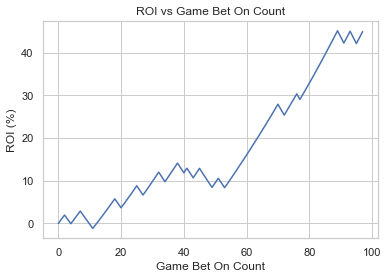

This file already exists.


initial conditions percentage_of_account_balance_per_bet                                                     1
                   percent_confidence_interval_place_bet_yes_no                                              9
                   spread1_abs_lower_limit                                                                 9.5
                   price_break_even_upper_limit                       [0.5098039215686274, 0.5121951219512195]
results            number_of_bets_placed                                                                    97
                   game_bet_opportunities_bet_on_percentage                                               9.45
                   games_bet_on_winning_bet_percentage                                                    70.1
                   games_bet_on_winning_bet_percentage_push_adjusted                                      70.1
                   winning_bet_no_streak                                                                     4
                   winning_bet_yes_streak                                                                   17
                   largest_bet_gain                                                                      14.09
                   largest_bet_loss                                                                     -14.51
                   roi_min                                                                               -0.01
                   roi_max                                                                                0.45
                   roi_final                                                                              0.45

time: 924 ms (started: 2022-08-29 22:35:34 -07:00)


In [179]:
df_readback = nsp.return_processed_data_file_if_it_exists(filename='36_time_series_cross_validation_9_splits_fold_9_test_multiple_betting_policy_result_trial_7_percentage_betting_scheme.gz')

if df_readback.empty == False:
    df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result = df_readback

else:
    df_time_series_cross_validation_9_splits_fold_9_test = df_time_series_cross_validation_9_splits_folds_123456789_test_betting_policy_feature_collection[8]
    
    df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result = \
    nsp.get_results_for_games_selected_by_policies2(df = df_time_series_cross_validation_9_splits_fold_9_test,
                                                    percent_confidence_interval_place_bet_yes_no = percent_confidence_interval_place_bet_yes_no_list,
                                                    spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                                    price_break_even_upper_limit = price_break_even_upper_limit_list,
                                                    percentage_of_account_balance_to_bet = 1,
                                                    principal = 1000,
                                                    return_graph_true_false=True)

    df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result = df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result.T

    
    
    df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result = nsp.index_policy_initial_conditions_and_results(df = df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result,
                                                                                                                                  column_name_list = column_name_list_betting_policy_result2)

    #save it
    df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result = \
    save_and_return_data_frame(
        df=df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result, 
        filename='36_time_series_cross_validation_9_splits_fold_9_test_multiple_betting_policy_result_trial_7_percentage_betting_scheme.csv',
        index=True,
        parse_dates=False,
        index_label=['  ', '   '])

df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result
#df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result.head(4)
#df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result.tail(11)


In [180]:
df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result2 = \
nsp.get_results_for_games_selected_by_policies2(df = df_time_series_cross_validation_9_splits_fold_9_test,
                                                percent_confidence_interval_place_bet_yes_no = percent_confidence_interval_place_bet_yes_no_list,
                                                spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                                price_break_even_upper_limit = price_break_even_upper_limit_list,
                                                percentage_of_account_balance_to_bet = 1,
                                                principal = 1000,
                                                return_graph_true_false=False)

df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result2.columns = column_name_list_betting_policy_result2

df_time_series_cross_validation_9_splits_fold_9_test_multiple_policy_result2

percentage_of_account_balance_per_bet  \
0                                     1   

  percent_confidence_interval_place_bet_yes_no spread1_abs_lower_limit  \
0                                            9                     9.5   

               price_break_even_upper_limit number_of_bets_placed  \
0  [0.5098039215686274, 0.5121951219512195]                    97   

  game_bet_opportunities_bet_on_percentage  \
0                                     9.45   

  games_bet_on_winning_bet_percentage  \
0                                70.1   

  games_bet_on_winning_bet_percentage_push_adjusted winning_bet_no_streak  \
0                                              70.1                     4   

  winning_bet_yes_streak largest_bet_gain largest_bet_loss roi_min roi_max  \
0                     17            14.09           -14.51   -1.16    45.1   

  roi_final  
0      44.9

time: 22.8 ms (started: 2022-08-29 22:35:35 -07:00)


In [181]:
number_range = 10000

#get ROI for sampled df_time_series_cross_validation_9_splits_fold_9_test

np.random.seed(364)

#get 10000 samples
df_tscv9_test_9_sampled_collection = {}

for i in range(number_range):
    df_tscv9_test_9_sampled_collection[i] = df_time_series_cross_validation_9_splits_fold_9_test.sample(n=df_time_series_cross_validation_9_splits_fold_9_test.shape[0], 
                                                                                                        replace = True)


time: 9.47 s (started: 2022-08-29 22:35:35 -07:00)


In [182]:
df_readback = nsp.return_processed_collection_if_it_exists(filename='181_df_time_series_cross_validation_fold_9_test_9_multiple_policy_result_collection.pkl',
                                                           parse_dates=False)

if df_readback != None:
    df_tscv9_test_9_multiple_policy_result_collection = df_readback

else:
    df_tscv9_test_9_multiple_policy_result_collection = {}

    for i in range(number_range):
        df_tscv9_test_9_multiple_policy_result_collection[i] = \
        nsp.get_results_for_games_selected_by_policies2(df = df_tscv9_test_9_sampled_collection[i],
                                                        percent_confidence_interval_place_bet_yes_no = percent_confidence_interval_place_bet_yes_no_list,
                                                        spread1_abs_lower_limit = spread1_abs_lower_limit_list,
                                                        price_break_even_upper_limit = price_break_even_upper_limit_list,
                                                        percentage_of_account_balance_to_bet = 1,
                                                        principal = 1000,
                                                        return_graph_true_false=False)

        df_tscv9_test_9_multiple_policy_result_collection[i].columns = column_name_list_betting_policy_result2
        df_tscv9_test_9_multiple_policy_result_collection[i] = df_tscv9_test_9_multiple_policy_result_collection[i].T
        df_tscv9_test_9_multiple_policy_result_collection[i].columns = ['betting_policy_01_and_result']
        df_tscv9_test_9_multiple_policy_result_collection[i] = df_tscv9_test_9_multiple_policy_result_collection[i].T

    df_tscv9_test_9_multiple_policy_result_collection = \
    nsp.save_and_return_collection(data_frame_collection=df_tscv9_test_9_multiple_policy_result_collection, 
                                   filename='181_df_time_series_cross_validation_fold_9_test_9_multiple_policy_result_collection.pkl',
                                   index=False,
                                   parse_dates=False)

df_tscv9_test_9_multiple_policy_result_collection[0]

This file already exists


percentage_of_account_balance_per_bet  \
betting_policy_01_and_result                                     1   

                             percent_confidence_interval_place_bet_yes_no  \
betting_policy_01_and_result                                            9   

                             spread1_abs_lower_limit  \
betting_policy_01_and_result                     9.5   

                                          price_break_even_upper_limit  \
betting_policy_01_and_result  [0.5098039215686274, 0.5121951219512195]   

                             number_of_bets_placed  \
betting_policy_01_and_result                   103   

                             game_bet_opportunities_bet_on_percentage  \
betting_policy_01_and_result                                    10.04   

                             games_bet_on_winning_bet_percentage  \
betting_policy_01_and_result                               77.67   

                             games_bet_on_winning_bet_percentage_push_adjusted  \
betting_policy_01_and_result                                             77.67   

                             winning_bet_no_streak winning_bet_yes_streak  \
betting_policy_01_and_result                     6                     20   

                             largest_bet_gain largest_bet_loss roi_min  \
betting_policy_01_and_result            17.31           -17.66     0.0   

                             roi_max roi_final  
betting_policy_01_and_result   76.58     72.83

time: 963 ms (started: 2022-08-29 22:35:44 -07:00)


/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_11797/102301949.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figure_roi_distribution_percentage_betting_scheme_01_<12_gray_>=12_green_w_vertical_at_12_v1.png', dpi=900, tight=True)


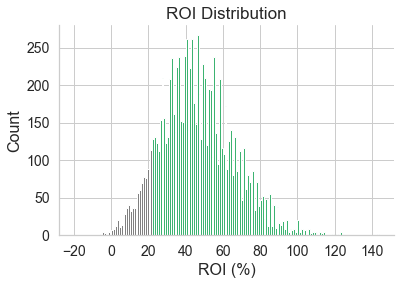

time: 1.84 s (started: 2022-08-29 22:35:45 -07:00)


In [183]:
values_list = nsp.get_values_list_from_collection(df_collection=df_tscv9_test_9_multiple_policy_result_collection,
                                                  column_name='roi_final',
                                                  number_range=number_range)
values_list.sort()

ten_percentile_roi_value = np.percentile(values_list, 10)


bin_count = max(values_list) - min(values_list) + 1
N, bins, patches = plt.hist(values_list, int(bin_count))


cmap = plt.get_cmap('jet')
low = cmap(0.5)
medium =cmap(0.2)
high = cmap(0.7)


for i in range(0, 42):
    patches[i].set_facecolor('gray')
for i in range(42,144):
    patches[i].set_facecolor('mediumseagreen')

#print(ten_percentile_roi_value)

#_ = plt.axvline(ten_percentile_roi_value, color='r', linestyle='--')


plt.xlabel("ROI (%)", fontsize=16)  
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

plt.title('ROI Distribution', fontsize=17)

plt.subplots_adjust(bottom=0.15)

plt.savefig('figure_roi_distribution_percentage_betting_scheme_01_<12_gray_>=12_green_w_vertical_at_12_v1.png', dpi=900, tight=True)

plt.show()



In [184]:
#get random forest, gradient boosting, and linear regression MAE and MAPE table.

time: 172 µs (started: 2022-08-29 22:35:47 -07:00)


In [185]:
#df_features_test_fold_9

time: 174 µs (started: 2022-08-29 22:35:47 -07:00)


In [186]:
#get random forest time series cross validation metrics for folds 1 thru 7 on fold 8

random_forest_regressor_fold_9_spread_a_predicted = model_180_random_forest_time_series_cross_validation_9_splits_collection_trial_6['estimator'][8].predict(df_features_test_fold_9)

random_forest_regressor_fold_9_mae = mean_absolute_error(df_spread_a_test_fold_9.to_numpy(), random_forest_regressor_fold_9_spread_a_predicted)

random_forest_regressor_fold_9_mape = nsp.MAPE(df_spread_a_test_fold_9.to_numpy(), random_forest_regressor_fold_9_spread_a_predicted)

print('MAE: ' + str(random_forest_regressor_fold_9_mae) + '\n' + 'MAPE: ' +str(random_forest_regressor_fold_9_mape))



MAE: 9.686973684210525
MAPE: 134.83837804597783
time: 30.4 ms (started: 2022-08-29 22:35:47 -07:00)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [187]:
model_readback = nsp.return_saved_model_if_it_exists(filename='172_gradient_boosting_regressor_folds_012345678_trial_1.pkl')


if model_readback != None:
    model_172_gradient_boosting_regressor_folds_012345678_trial_1 = model_readback
    
else:
    
    #build gradient boosting regressor
    gradient_boosting_regressor_grid_search_cross_validation_folds_012345678 = nsp.get_gradient_boosting_regressor_grid_search_cross_validation(X_train=df_features_train_folds_012345678,
                                                                                                                                                y_train=df_spread_a_train_folds_012345678.loc[:, 'spread_a'],
                                                                                                                                                X_test=df_features_test_fold_9,
                                                                                                                                                y_test=df_spread_a_test_fold_9.loc[:, 'spread_a'])

    #save the best model
    from sklearn import __version__ as sklearn_version
    import datetime
    import pickle
    
    best_model = gradient_boosting_regressor_grid_search_cross_validation_folds_012345678.best_estimator_
    best_model.version = '1.0'
    best_model.pandas_version = pd.__version__
    best_model.numpy_version = np.__version__
    best_model.sklearn_version = sklearn_version
    best_model.X_columns = [col for col in df_features_train_folds_012345678.columns]
    best_model.build_datetime = datetime.datetime.now()

    model_172_gradient_boosting_regressor_folds_012345678_trial_1 = nsp.save_and_return_model(best_model, '172_gradient_boosting_regressor_folds_012345678_trial_1.pkl')
    


gradient_boosting_regressor_fold_9_mae = mean_absolute_error(df_spread_a_test_fold_9.to_numpy(), model_172_gradient_boosting_regressor_folds_012345678_trial_1.predict(df_features_test_fold_9))

gradient_boosting_regressor_fold_9_mape = nsp.MAPE(df_spread_a_test_fold_9.to_numpy(), model_172_gradient_boosting_regressor_folds_012345678_trial_1.predict(df_features_test_fold_9))

print('MAE: ' + str(gradient_boosting_regressor_fold_9_mae) + '\n' + 'MAPE: ' +str(gradient_boosting_regressor_fold_9_mape))

model_172_gradient_boosting_regressor_folds_012345678_trial_1


This file already exists
MAE: 9.685200810297726
MAPE: 133.4907327542023


GradientBoostingRegressor(max_depth=1, random_state=1, subsample=0.75)

time: 14.7 ms (started: 2022-08-29 22:35:47 -07:00)


In [188]:
model_readback = nsp.return_saved_model_if_it_exists(filename='172_grid_search_cross_validation_5_folds_linear_regression_select_k_best_model_folds_012345678_trial_1.pkl')

if model_readback != None:
    linear_regression_grid_search_cross_validation_folds_012345678 = model_readback
else:
    from sklearn.feature_selection import SelectKBest, f_regression
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.model_selection import GridSearchCV, learning_curve#, train_test_split, cross_validate,
    from sklearn import __version__ as sklearn_version
    import datetime

    pipe = make_pipeline(SelectKBest(score_func=f_regression), LinearRegression())

    k = [k+1 for k in range(len(df_features_train_folds_012345678.columns))]

    grid_params = {'selectkbest__k': k}

    #get grid search cross validation object
    linear_regression_grid_search_cross_validation_folds_012345678 = GridSearchCV(pipe, param_grid=grid_params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

    #fit data on grid search cross validation object
    linear_regression_grid_search_cross_validation_folds_012345678.fit(df_features_train_folds_012345678, df_spread_a_train_folds_012345678.loc[:, 'spread_a'])
    
    linear_regression_grid_search_cross_validation_folds_012345678 = nsp.save_and_return_model(model=linear_regression_grid_search_cross_validation_folds_012345678, 
                                                                                               filename='172_grid_search_cross_validation_5_folds_linear_regression_select_k_best_model_folds_012345678_trial_1.pkl')


#get the K-best Linear Regressor
model_readback = nsp.return_saved_model_if_it_exists(filename='172_linear_regression_select_k_best_model_folds_012345678_trial_1.pkl')

if model_readback != None:
    linear_regression_select_k_best_model_folds_012345678_trial_1 = model_readback

else:    
    #get best model and meta data
    best_model = linear_regression_grid_search_cross_validation_folds_012345678.best_estimator_
    best_model.version = '1.0'
    best_model.pandas_version = pd.__version__
    best_model.numpy_version = np.__version__
    best_model.sklearn_version = sklearn_version
    best_model.X_columns = [col for col in df_features_train_folds_012345678.columns]
    best_model.build_datetime = datetime.datetime.now()

    linear_regression_select_k_best_model_folds_012345678_trial_1 = nsp.save_and_return_model(model=best_model, filename='172_linear_regression_select_k_best_model_folds_012345678_trial_1.pkl')

    
linear_regression_k_best_fold_9_mae = mean_absolute_error(df_spread_a_test_fold_9, linear_regression_select_k_best_model_trial_1.predict(df_features_test_fold_9))

linear_regression_k_best_fold_9_mape = nsp.MAPE(df_spread_a_test_fold_9, linear_regression_select_k_best_model_trial_1.predict(df_features_test_fold_9))[0]

print('MAE: ' + str(linear_regression_k_best_fold_9_mae) + '\n' +'MAPE: '+ str(linear_regression_k_best_fold_9_mape))
    
linear_regression_select_k_best_model_folds_012345678_trial_1



This file already exists
This file already exists
MAE: 9.707561330121777
MAPE: 111.22198891661958


Pipeline(steps=[('selectkbest',
                 SelectKBest(k=66,
                             score_func=<function f_regression at 0x7fb7e90fac10>)),
                ('linearregression', LinearRegression())])

time: 15.9 ms (started: 2022-08-29 22:35:47 -07:00)


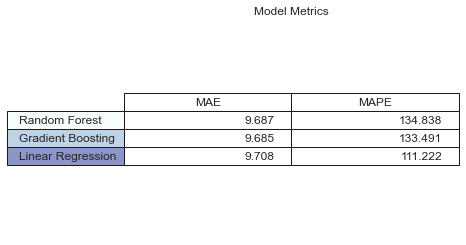

time: 389 ms (started: 2022-08-29 22:35:47 -07:00)


In [189]:
df_rf = pd.DataFrame({'Random Forest': [random_forest_regressor_fold_9_mae, random_forest_regressor_fold_9_mape]})
df_gb = pd.DataFrame({'Gradient Boosting': [gradient_boosting_regressor_fold_9_mae, gradient_boosting_regressor_fold_9_mape]})
df_lr = pd.DataFrame({'Linear Regression': [linear_regression_k_best_fold_9_mae, linear_regression_k_best_fold_9_mape]})

df_rf_list = list(np.round(df_rf.loc[:, 'Random Forest'].values, 3))
df_gb_list = list(np.round(df_gb.loc[:, 'Gradient Boosting'].values, 3))
df_lr_list = list(np.round(df_lr.loc[:, 'Linear Regression'].values, 3))


data = [df_rf_list,
        df_gb_list,
        df_lr_list]

columns = ('MAE', 'MAPE')

rows = [x for x in (list(df_rf.columns) + list(df_gb.columns) +  list(df_lr.columns))]



colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
the_table = plt.table(cellText = data,
                      rowLabels = rows,
                      rowColours = colors,
                      colLabels = columns,
                      loc='center')


plt.xticks([])

plt.box(on=None)
fig = plt.gcf()
the_table.scale(1, 1.5)


ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Model Metrics')

#save model metrics figure
plt.savefig('figure_random_forest_gradient_boosting_linear_regression_fold_9_mae_mape.png', bbox_inches='tight', dpi=600)

plt.show()




<font size="5"><a id='[Sources]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Betting_Policy_Data_Wrangling_Feature_Engineering](#[Betting_Policy_Data_Wrangling_Feature_Engineering])</font> <font size="2">[Betting_Policy_Learn_Heuristic](#[Betting_Policy_Learn_Heuristic])</font> <font size="2">[Betting_Policy_Test_Heuristic](#[Betting_Policy_Test_Heuristic])</font> 

<p>Sources </p>
<a id='[1]'>[1]</a> 
<a href="https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games.csv">https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games.csv</a>

<a id='[2]'>[2]</a> 
<a href="https://www.kaggle.com/datasets/ehallmar/nba-historical-stats-and-betting-data?select=nba_games_all.csv">https://www.kaggle.com/datasets/ehallmar/nba-historical-stats-and-betting-data?select=nba_games_all.csv</a>


<a id='[3]'>[3]</a> 
<a href="https://www.kaggle.com/datasets/ehallmar/nba-historical-stats-and-betting-data?select=nba_betting_spread.csv">https://www.kaggle.com/datasets/ehallmar/nba-historical-stats-and-betting-data?select=nba_betting_spread.csv</a>


<a id='[4]'>[4]</a> 
<a href="https://github.com/swar/nba_api">https://github.com/swar/nba_api</a>

<a id='[5]'>[5]</a> 
<a href="https://www.kaggle.com/datasets/ghopkins/nba-injuries-2010-2018">https://www.kaggle.com/datasets/ghopkins/nba-injuries-2010-2018</a>

<a id='[6]'>[6]</a> 
<a href="https://www.kaggle.com/datasets/gabrielmanfredi/nba-retro-1995-to-2000-full-basketball-datasets">https://www.kaggle.com/datasets/gabrielmanfredi/nba-retro-1995-to-2000-full-basketball-datasets</a>


<a id='[7]'>[7]</a> 
<a href="https://www.kaggle.com/datasets/wyattowalsh/basketball">https://www.kaggle.com/datasets/wyattowalsh/basketball</a>



<a id='[8]'>[8]</a> 
<a href="https://en.wikipedia.org/wiki/List_of_cities_by_GDP">https://en.wikipedia.org/wiki/List_of_cities_by_GDP</a>

In [190]:
data_frames = [k for k in dir() if isinstance(eval(k), pd.core.frame.DataFrame)]

data_frames

['X_time_series_cross_validation_index_8_train',
 'Y_time_series_cross_validation_index_8_train',
 '_10',
 '_100',
 '_101',
 '_103',
 '_106',
 '_11',
 '_112',
 '_115',
 '_116',
 '_121',
 '_122',
 '_125',
 '_13',
 '_14',
 '_142',
 '_144',
 '_152',
 '_154',
 '_155',
 '_157',
 '_16',
 '_164',
 '_165',
 '_167',
 '_168',
 '_17',
 '_171',
 '_178',
 '_179',
 '_18',
 '_180',
 '_182',
 '_20',
 '_22',
 '_23',
 '_24',
 '_26',
 '_27',
 '_28',
 '_29',
 '_30',
 '_31',
 '_33',
 '_34',
 '_35',
 '_36',
 '_39',
 '_40',
 '_41',
 '_42',
 '_43',
 '_46',
 '_47',
 '_52',
 '_57',
 '_58',
 '_59',
 '_6',
 '_60',
 '_65',
 '_67',
 '_68',
 '_71',
 '_72',
 '_73',
 '_74',
 '_77',
 '_78',
 '_8',
 '_80',
 '_81',
 '_83',
 '_84',
 '_85',
 '_86',
 '_87',
 '_89',
 '_90',
 '_91',
 '_96',
 '_98',
 '___',
 'corr',
 'df',
 'df_01',
 'df_BOS_1011',
 'df_MIA_1011',
 'df_city_proper_metro_area_gdp_latitude_longitude_travel_distance_away_home_game_percentage_day_window_future_away_home_game_percentage_day_window',
 'df_corr',
 'd

time: 6.29 ms (started: 2022-08-29 22:35:48 -07:00)


In [191]:
df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28136 entries, 0 to 28135
Data columns (total 14 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   percent_confidence_interval_place_bet_yes_no       28136 non-null  int64  
 1   spread1_abs_lower_limit                            28136 non-null  float64
 2   price_break_even_upper_limit                       28136 non-null  float64
 3   number_of_games_bet_on                             28136 non-null  int64  
 4   games_bet_on_percentage                            28136 non-null  float64
 5   games_bet_on_winning_bet_percentage                28136 non-null  float64
 6   games_bet_on_winning_bet_percentage_push_adjusted  28136 non-null  float64
 7   winning_bet_no_streak                              28136 non-null  int64  
 8   winning_bet_yes_streak                             28136 non-null  int64  
 9   larges

In [192]:
del [df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results, 
     df_time_series_cross_validation_9_splits_folds_1234567_test_betting_policy_results, 
     df_BOS_1011, 
     df_MIA_1011, 
     df_time_series_cross_validation_9_splits_folds_12345678_test_betting_policy_results_top5_percent]
    

time: 517 µs (started: 2022-08-29 22:35:48 -07:00)


In [193]:
if 'df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means' in locals():
    del df_time_series_cross_validation_9_splits_folds_123456789_test_random_forest_regressor_decision_tree_prediction_bootstrap_means

time: 28.1 ms (started: 2022-08-29 22:35:48 -07:00)
